In [1]:
library(ggplot2)        # plotting & data
library(dplyr)          # data manipulation
library(tidyr)          # data re-shaping
library(magrittr)       # pipe operator
library(gridExtra)      # provides side-by-side plotting
library(dplyr)          # dplyr for pipe operations
library(moments)        # bonett.test for normality
library(ggQC)           # to create xMR and iMR charts
library(repr)           # change plot size
library(nortest)        # anderson darling test


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
#install.packages('nortest_1.0-4.tar.gz', repos = NULL, type = "source")

Warning message in install.packages("nortest_1.0-4.tar.gz", repos = NULL, type = "source"):
“installation of package ‘nortest_1.0-4.tar.gz’ had non-zero exit status”


In [2]:
# Change plot size to 12 x 6
options(repr.plot.width=22, repr.plot.height=12)

### 96 CORE HEAD COMPARISON 

In [2]:
dfl_8chl <- list()
dfl_96cr <- list()
chl8_file <- "rscript_data/2021-06-18_CELL_COUNT_8CHL_Plate"
cr96_file <- "rscript_data/2021-06-18_CELL_COUNT_96CR_Plate"
fi_suffix <- ".csv"
ratio_factor <- 30/50 # 30ul/50ul due to first well injection testing

for (i in seq(3)) {
    dfl_8chl[[i]] <- read.csv(paste0(chl8_file, i, fi_suffix))
    # scale down the first A1 well
    dfl_8chl[[i]][1,"Z"] <- dfl_8chl[[1]][1,"Z"]*ratio_factor
    dfl_96cr[[i]] <- read.csv(paste0(cr96_file, i, fi_suffix))
    dfl_96cr[[i]][1,"Z"] <- dfl_96cr[[1]][1,"Z"]*ratio_factor
    }

#### compare two groups at a time for the variance using F test

In [3]:
cell_cnts_8chl <- list()
cell_cnts_96cr <- list()

# discount first well since it was testing at 50 ul injection
for (i in seq(3)) {
    cell_cnts_8chl[[i]] <- dfl_8chl[[i]][dfl_8chl[[i]]$Z>100,]$Z[2:64]
    cell_cnts_96cr[[i]] <- dfl_96cr[[i]][dfl_96cr[[i]]$Z>100,]$Z[2:64]
    }

In [535]:
#check lengths are equal
length(unique(sapply(cell_cnts_8chl, length))) == 1

[1] TRUE

In [4]:
# merge set 1 and 2 from 8 chl ds
df_cmpr12 <- data.frame(`counts` = c(cell_cnts_8chl[[1]], cell_cnts_8chl[[2]]), `group` = c(rep(1, 63), rep(2, 63)))
head(df_cmpr12)

counts group
1 2500   1    
2 2422   1    
3 2821   1    
4 2429   1    
5 2451   1    
6 3022   1

In [5]:
# merge set 2 and 3 from 8 chl ds
df_cmpr23 <- data.frame(`counts` = c(cell_cnts_8chl[[2]], cell_cnts_8chl[[3]]), `group` = c(rep(1, 63), rep(2, 63)))
head(df_cmpr23)

counts group
1 1613   1    
2 1897   1    
3 1698   1    
4 1711   1    
5 1703   1    
6 1814   1

In [6]:
# merge set 1 and 3 from 8 chl ds
df_cmpr13 <- data.frame(`counts` = c(cell_cnts_8chl[[1]], cell_cnts_8chl[[3]]), `group` = c(rep(1, 63), rep(2, 63)))
head(df_cmpr13)

counts group
1 2500   1    
2 2422   1    
3 2821   1    
4 2429   1    
5 2451   1    
6 3022   1

In [7]:
df_cmpr_9v8_11 <- data.frame(`counts` = c(cell_cnts_96cr[[1]], cell_cnts_8chl[[1]]), `group` = rep("1", 63)) %>% mutate(method = c(rep("96 CR", 63),rep("8 CHL", 63)))
head(df_cmpr_9v8_11)

counts group method
1 3222   1     96 CR 
2 3310   1     96 CR 
3 3062   1     96 CR 
4 3123   1     96 CR 
5 3143   1     96 CR 
6 2992   1     96 CR

In [8]:
df_cmpr_9v8_22 <- data.frame(`counts` = c(cell_cnts_96cr[[2]], cell_cnts_8chl[[2]]), `group` = rep("2", 2*63)) %>% mutate(method = c(rep("96 CR", 63),rep("8 CHL", 63)))
head(df_cmpr_9v8_22)

counts group method
1 2588   2     96 CR 
2 2700   2     96 CR 
3 2492   2     96 CR 
4 2551   2     96 CR 
5 2554   2     96 CR 
6 2517   2     96 CR

In [9]:
df_cmpr_9v8_33 <- data.frame(`counts` = c(cell_cnts_96cr[[3]], cell_cnts_8chl[[3]]), `group` = rep("3", 63*2)) %>% mutate(method = c(rep("96 CR", 63),rep("8 CHL", 63)))
head(df_cmpr_9v8_33)

counts group method
1 1666   3     96 CR 
2 1712   3     96 CR 
3 1606   3     96 CR 
4 1741   3     96 CR 
5 1635   3     96 CR 
6 1784   3     96 CR

- The p values get smaller, meaning the variances change more so from plate 1 to 3
- Run F-test when you want to perform a two samples t-test to check the equality of the variances of the two samples

In [12]:
# cmpr 1 & 1 for 96 vs 8
var.test(counts ~ method, df_cmpr_9v8_11)


	F test to compare two variances

data:  counts by method
F = 0.88692, num df = 62, denom df = 62, p-value = 0.6381
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5366362 1.4658576
sample estimates:
ratio of variances 
         0.8869229 


In [41]:
# cmpr 2 & 2 for 96 vs 8
var.test(counts ~ method, df_cmpr_9v8_22)


	F test to compare two variances

data:  counts by method
F = 0.71221, num df = 62, denom df = 62, p-value = 0.1843
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.4309238 1.1770971
sample estimates:
ratio of variances 
         0.7122072 


In [21]:
# cmpr 3 & 3 for 96 vs 8
var.test(counts ~ method, df_cmpr_9v8_33)


	F test to compare two variances

data:  counts by method
F = 0.80266, num df = 62, denom df = 62, p-value = 0.3892
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.4856501 1.3265856
sample estimates:
ratio of variances 
         0.8026558 


In [539]:
# cmpr 1 & 3
var.test(counts ~ group, df_cmpr13)


	F test to compare two variances

data:  counts by group
F = 3.4765, num df = 62, denom df = 62, p-value = 2.127e-06
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.103494 5.745835
sample estimates:
ratio of variances 
           3.47654 


In [540]:
# cmpr 1 & 2
var.test(counts ~ group, df_cmpr12)


	F test to compare two variances

data:  counts by group
F = 2.5391, num df = 62, denom df = 62, p-value = 0.0003294
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.536297 4.196498
sample estimates:
ratio of variances 
          2.539108 


In [541]:
# cmpr 2 & 3
var.test(counts ~ group, df_cmpr23)


	F test to compare two variances

data:  counts by group
F = 1.3692, num df = 62, denom df = 62, p-value = 0.2188
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.8284384 2.2629349
sample estimates:
ratio of variances 
          1.369198 


### Shapiro test
the shapiro.test, the null hypothesis assumes that the data is drawn from a normal distribution. Since the p-value > 0.05, we fail to reject the null hypothesis, meaning that it is likely that the data is drawn from a normal distribution

In [17]:
df_stats = data.frame() 

for (i in seq(3)) {
   data = c(cell_cnts_8chl[[i]], cell_cnts_96cr[[i]])
   stat <- var.test(cell_cnts_8chl[[i]], cell_cnts_96cr[[i]])
   df_stats[i, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
   print(stat)
   stat <- ad.test(data)
   df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
   print(stat)
   stat <- shapiro.test(data)
   df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_S"] = stat$p.value > 0.05
   print(stat)
   stat <- bonett.test(data)
   df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_B"] = stat$p.value > 0.05
   print(stat)
   print("geary result:")
   stat <- geary(data)
   df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
   df_stats[i, "GT_PI"] = stat > 0.7979
   print(stat)
}
df_stats
#write.csv(df_stats, paste0("96v8_june_pair_3plts_stats_cnt.csv"), row.names = FALSE)


	F test to compare two variances

data:  cell_cnts_8chl[[i]] and cell_cnts_96cr[[i]]
F = 0.88692, num df = 62, denom df = 62, p-value = 0.6381
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5366362 1.4658576
sample estimates:
ratio of variances 
         0.8869229 


	Anderson-Darling normality test

data:  data
A = 0.26876, p-value = 0.6765


	Shapiro-Wilk normality test

data:  data
W = 0.99194, p-value = 0.6833


	Bonett-Seier test for Geary kurtosis

data:  data
tau = 377.61565, z = -0.53457, p-value = 0.5929
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "geary result:"
[1] 0.8080366

	F test to compare two variances

data:  cell_cnts_8chl[[i]] and cell_cnts_96cr[[i]]
F = 0.71221, num df = 62, denom df = 62, p-value = 0.1843
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.4309238 1.1770971
sample estimates:
ratio of variances 
         0.7122072 


	Anderso

F_TEST   GT_A_FT AD_TEST  GT_A_AD SHAPIRO_TEST GT_A_S BONETT_TEST GT_A_B
1 6.38e-01 TRUE    6.76e-01  TRUE   6.83e-01      TRUE  5.93e-01    TRUE  
2 1.84e-01 TRUE    4.93e-02 FALSE   2.41e-02     FALSE  3.53e-01    TRUE  
3 3.89e-01 TRUE    4.46e-01  TRUE   3.40e-03     FALSE  2.43e-01    TRUE  
  GEARY    GT_PI
1 8.08e-01  TRUE
2 7.81e-01 FALSE
3 7.76e-01 FALSE

In [542]:
shapiro.test(cell_cnts_8chl[[1]])


	Shapiro-Wilk normality test

data:  cell_cnts_8chl[[1]]
W = 0.98852, p-value = 0.8253


In [543]:
shapiro.test(cell_cnts_8chl[[2]])


	Shapiro-Wilk normality test

data:  cell_cnts_8chl[[2]]
W = 0.97913, p-value = 0.3604


In [544]:
shapiro.test(cell_cnts_8chl[[3]])


	Shapiro-Wilk normality test

data:  cell_cnts_8chl[[3]]
W = 0.98076, p-value = 0.4282


In [24]:
shapiro.test(cell_cnts_96cr[[1]])


	Shapiro-Wilk normality test

data:  cell_cnts_96cr[[1]]
W = 0.98852, p-value = 0.825


In [23]:
shapiro.test(cell_cnts_96cr[[2]])


	Shapiro-Wilk normality test

data:  cell_cnts_96cr[[2]]
W = 0.93454, p-value = 0.00234


In [22]:
shapiro.test(cell_cnts_96cr[[3]])


	Shapiro-Wilk normality test

data:  cell_cnts_96cr[[3]]
W = 0.92456, p-value = 0.0008591


### Anderson-Darling test

In [662]:
ad.test(cell_cnts_8chl[[1]])


	Anderson-Darling normality test

data:  cell_cnts_8chl[[1]]
A = 0.20368, p-value = 0.8702


In [663]:
ad.test(cell_cnts_8chl[[2]])


	Anderson-Darling normality test

data:  cell_cnts_8chl[[2]]
A = 0.29313, p-value = 0.5919


In [664]:
ad.test(cell_cnts_8chl[[3]])


	Anderson-Darling normality test

data:  cell_cnts_8chl[[3]]
A = 0.34929, p-value = 0.4639


In [666]:
ad.test(cell_cnts_96cr[[1]])


	Anderson-Darling normality test

data:  cell_cnts_96cr[[1]]
A = 0.256, p-value = 0.7141


In [665]:
ad.test(cell_cnts_96cr[[2]])


	Anderson-Darling normality test

data:  cell_cnts_96cr[[2]]
A = 1.5253, p-value = 0.0005652


In [667]:
ad.test(cell_cnts_96cr[[3]])


	Anderson-Darling normality test

data:  cell_cnts_96cr[[3]]
A = 0.73269, p-value = 0.05333


### qq-plot
Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that's roughly straight

In [25]:
p_qq_8chl_ls <- list()
p_qq_96cr_ls <- list()

for (i in seq(3)) {
    p_qq_8chl_ls[[i]] <- ggplot(data.frame(cnt = cell_cnts_8chl[[i]]), aes(sample = cnt)) + 
                    stat_qq() + stat_qq_line()
    p_qq_96cr_ls[[i]] <- ggplot(data.frame(cnt = cell_cnts_96cr[[i]]), aes(sample = cnt)) + 
                    stat_qq() + stat_qq_line()
    }

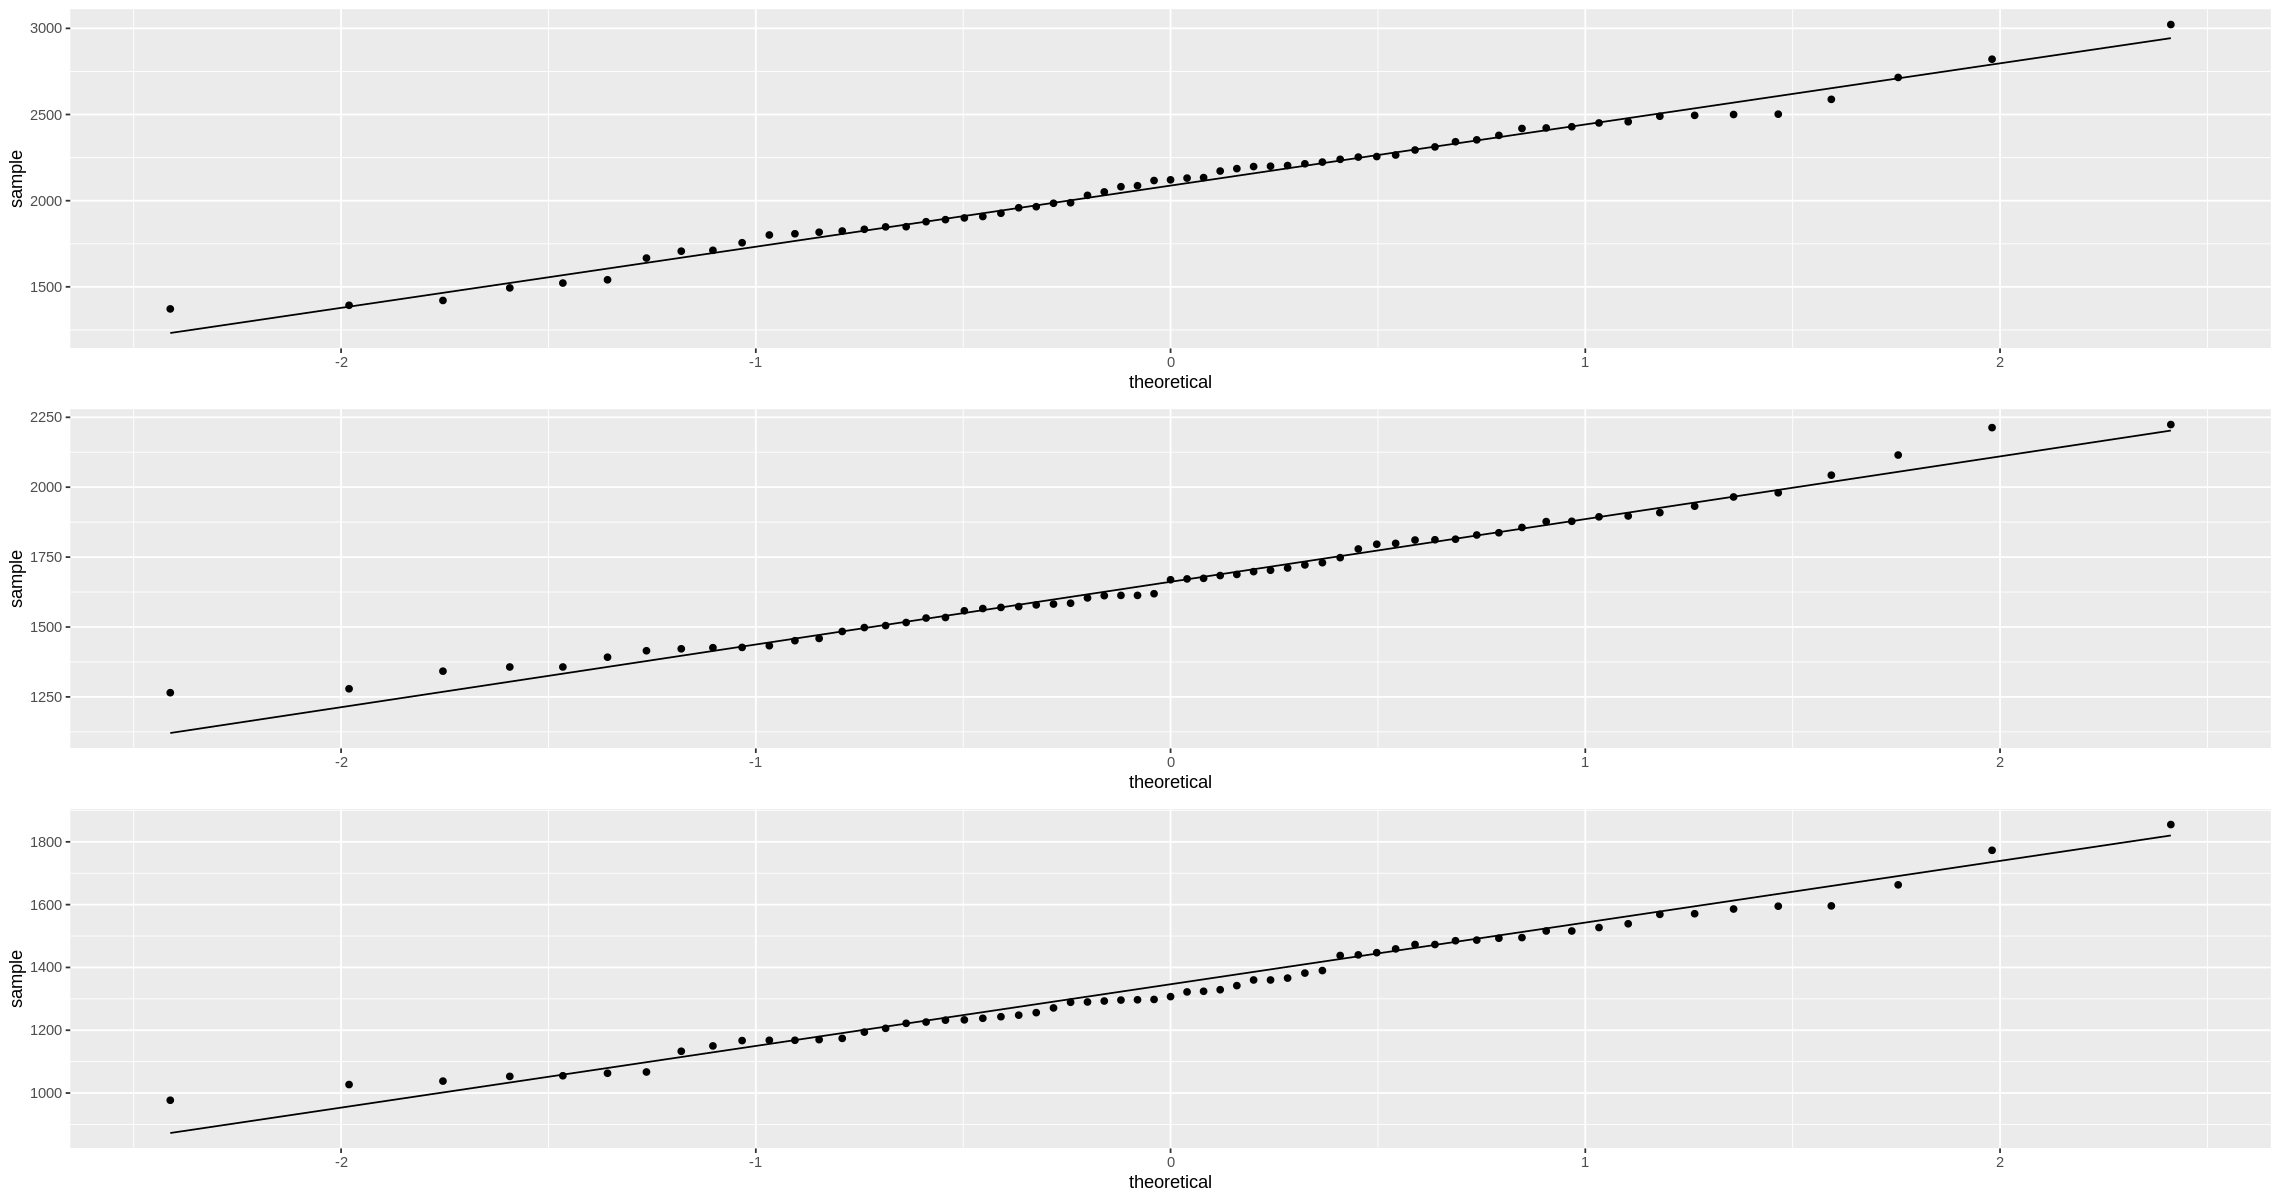

In [26]:
# 8 chl qq plots
grid.arrange(p_qq_8chl_ls[[1]],p_qq_8chl_ls[[2]], p_qq_8chl_ls[[3]], nrow = 3)

In [113]:
pp<-arrangeGrob(grobs = p_qq_8chl_ls, ncol=1)
ggsave(filename = 'grid_qq_8chl.png', plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

Saving 350 x 169 mm image



As all the points fall approximately along this reference line, we can assume normality.

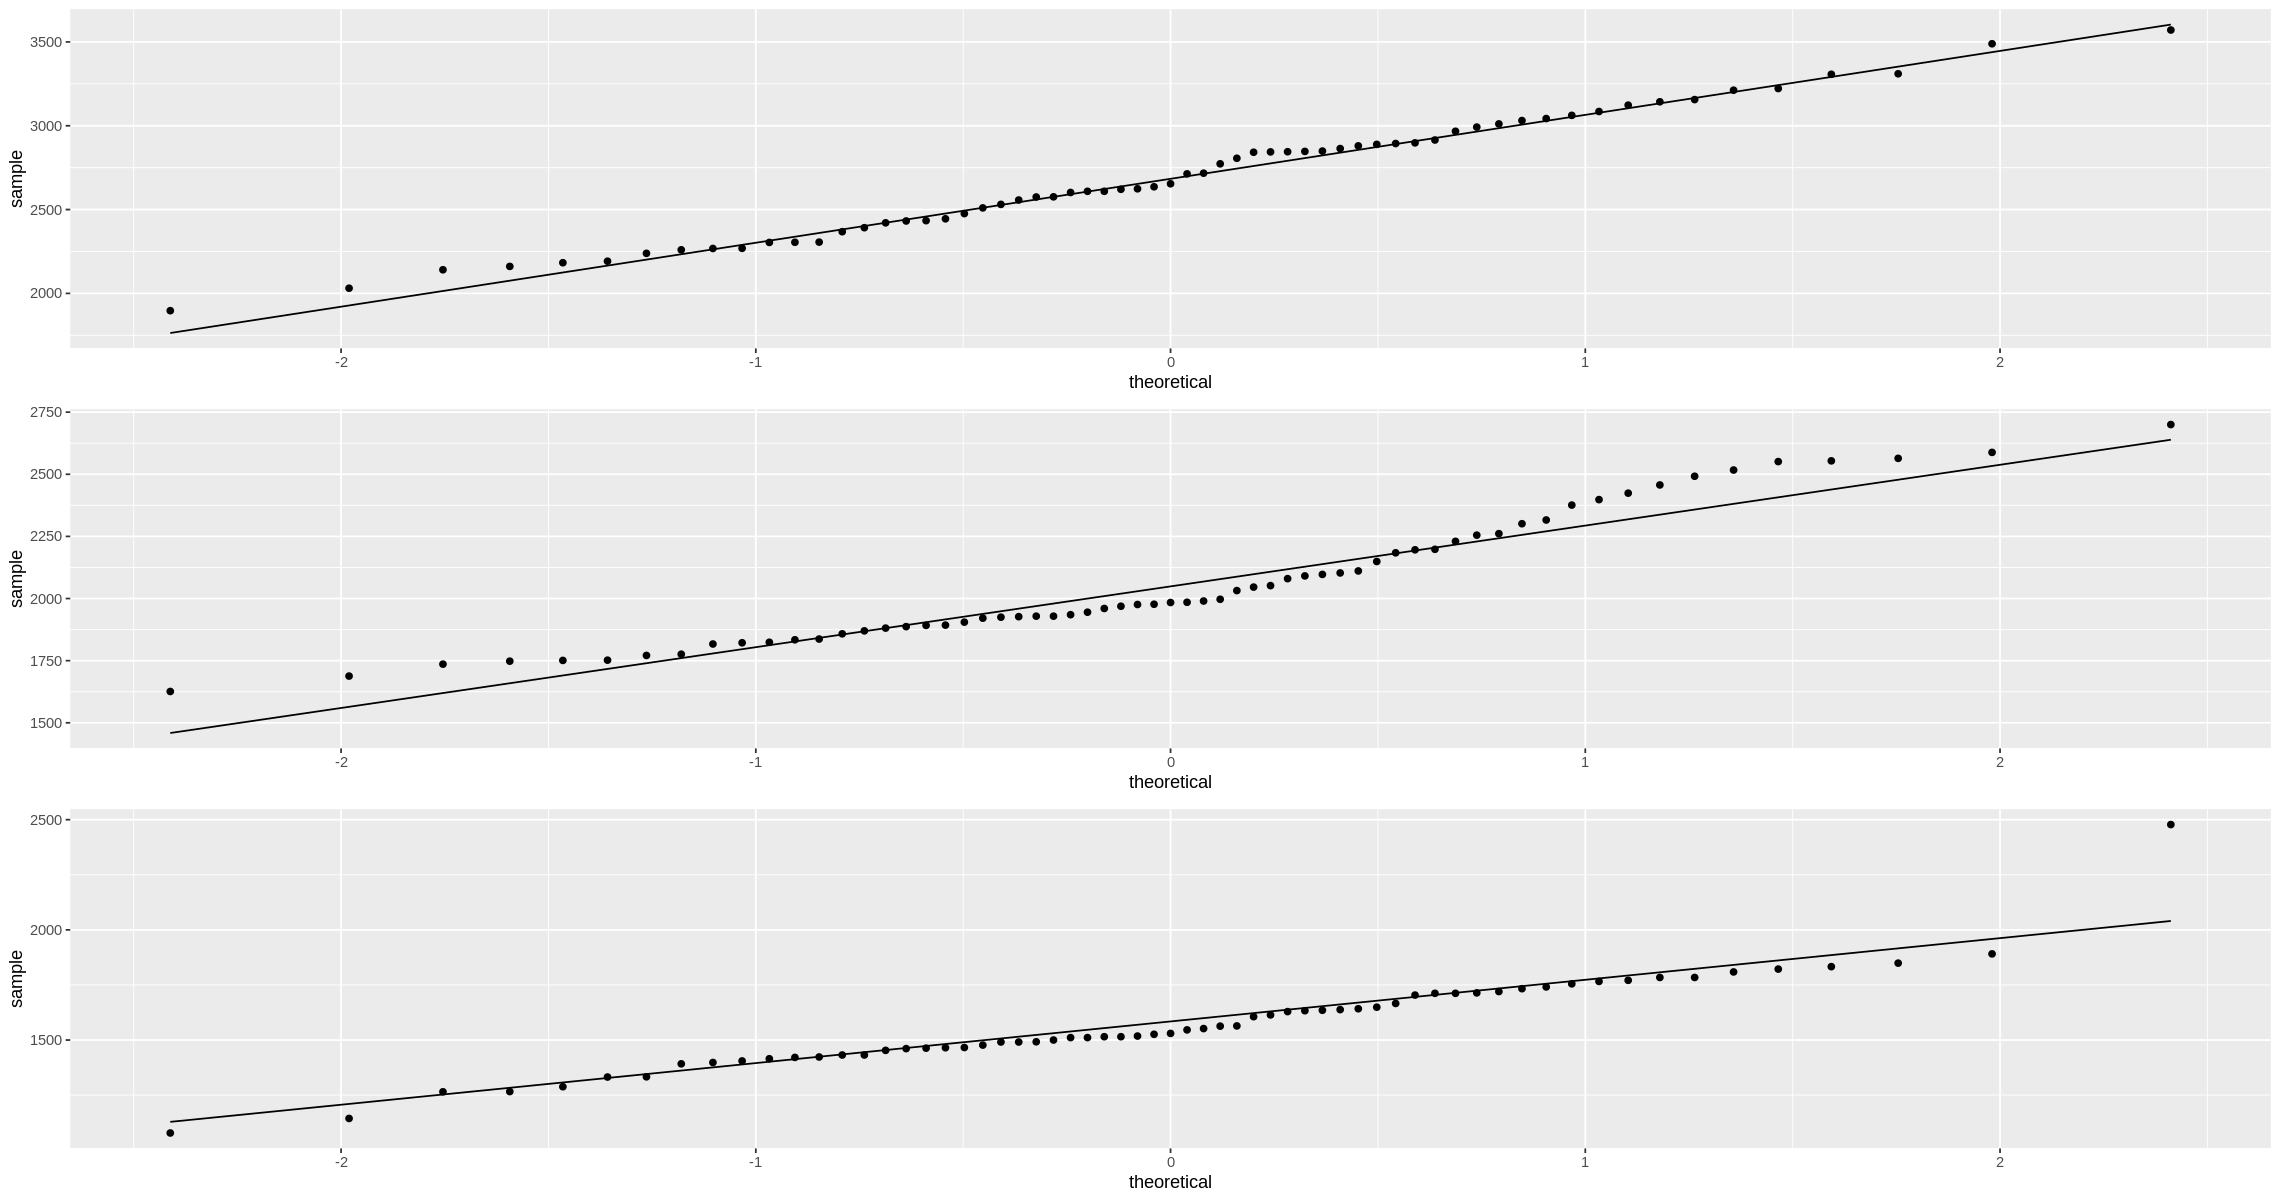

In [27]:
# 96 CORE qq plots
grid.arrange(p_qq_96cr_ls[[1]],p_qq_96cr_ls[[2]], p_qq_96cr_ls[[3]], nrow = 3)

### Histogram with density line plot

In [652]:
p_hst_8chl <- list()
p_hst_96cr <- list()

for (i in seq(3)) {
    dfh <- data.frame(cnt = cell_cnts_8chl[[i]])
    #p_hst_8chl[[i]] <- ggplot(data.frame(`cnt`=cell_cnts_8chl[[i]]), aes(cnt)) +
    #        geom_histogram(bins = 15)
    p_hst_8chl[[i]] <- ggplot(dfh, aes(cnt)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(dfh$cnt), sd = sd(dfh$cnt)), 
        lwd = 2, 
        col = '#1F629F'
      )
    #p_hst_96cr[[i]] <- ggplot(data.frame(`cnt`=cell_cnts_96cr[[i]]), aes(cnt)) +
    #        geom_histogram(bins = 15)
    dfh <- data.frame(cnt = cell_cnts_96cr[[i]])
    p_hst_96cr[[i]] <- ggplot(dfh, aes(cnt)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(dfh$cnt), sd = sd(dfh$cnt)), 
        lwd = 2, 
        col = '#1F629F'
      )
    }

#### We also see similar skewness within the sample distributions.

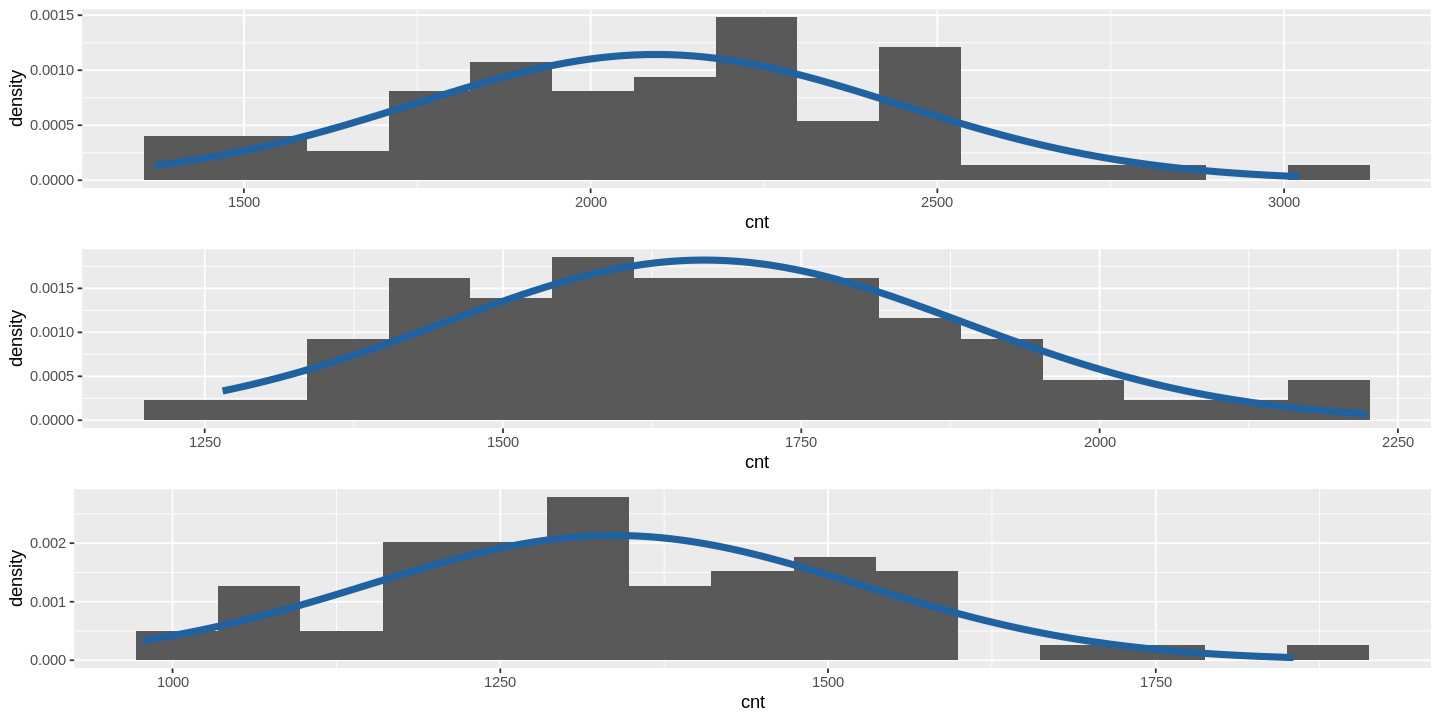

In [653]:
grid.arrange(p_hst_8chl[[1]], p_hst_8chl[[2]], p_hst_8chl[[3]], nrow = 3)

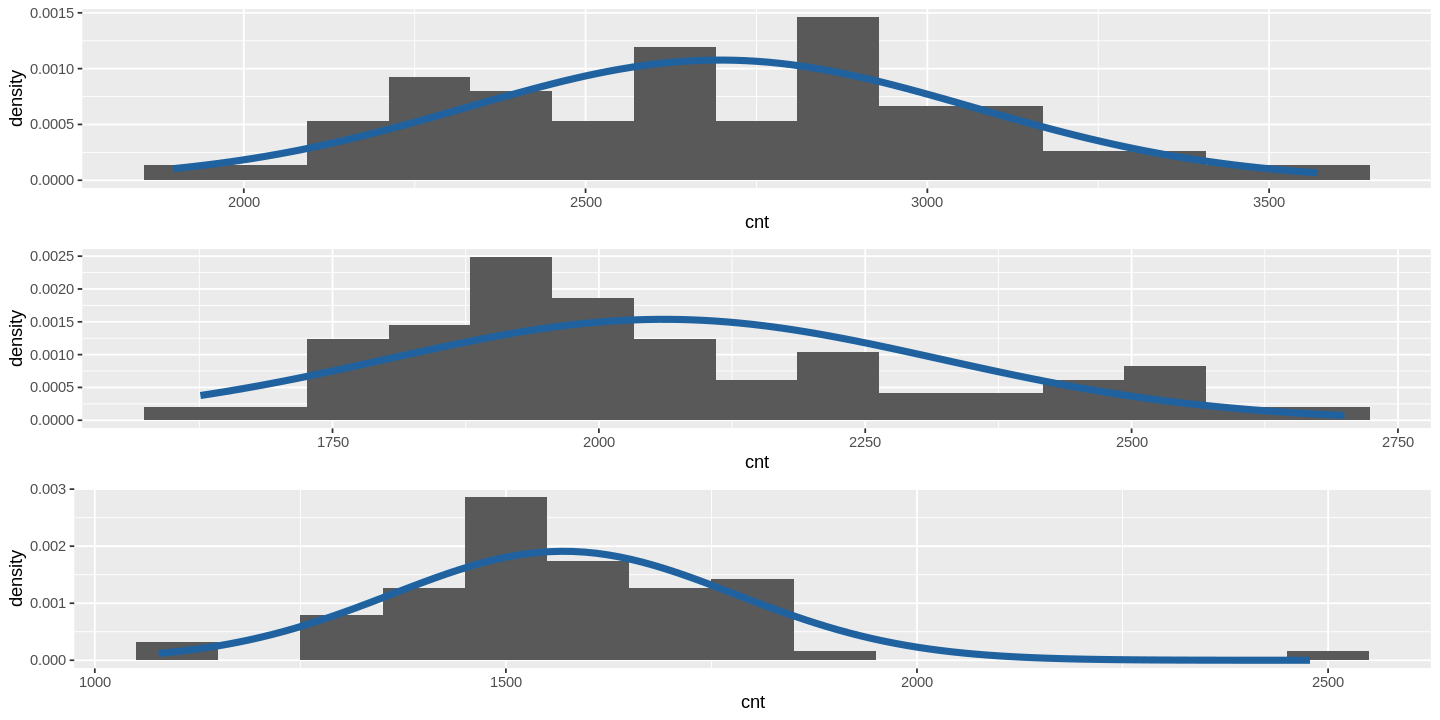

In [654]:
grid.arrange(p_hst_96cr[[1]], p_hst_96cr[[2]], p_hst_96cr[[3]], nrow = 3)

### Wilcoxon rank test

- check that the median of pairwise differences is different 
- non-parametric statistical test to compare 2 related samples, matched samples or repeated measurements on single sample to assess whether their population mean ranks differ 
- an alternative to t-test; this is when we can't assume the two populatios are normally distributed; determine wheterh two dependent samples were selected from populations have the same distribution
- analysis below shows using both wilcox and t-test the sample mean for intra-plate is very different

In [28]:
pair_test <- function(x, y) {
    print(wilcox.test(x = x, y = y,
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) )
    print(t.test(x = x, y = y,
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) )
}

In [29]:
for (i in seq(3)) {
    pair_test(cell_cnts_8chl[[i]], cell_cnts_96cr[[i]])
}


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 462.5, p-value = 1.139e-13
alternative hypothesis: true location shift is not equal to 0


	Welch Two Sample t-test

data:  x and y
t = -9.4096, df = 123.56, p-value = 3.488e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -730.1505 -476.3574
sample estimates:
mean of x mean of y 
 2094.016  2697.270 


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 448.5, p-value = 6.779e-14
alternative hypothesis: true location shift is not equal to 0


	Welch Two Sample t-test

data:  x and y
t = -9.1719, df = 120.59, p-value = 1.551e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -476.9449 -307.5947
sample estimates:
mean of x mean of y 
 1668.683  2060.952 


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 781, p-value = 4.364e-09
alternative hypothesis: true location shi

In [551]:
# assume not normal distribution
wilcox.test(x = cell_cnts_8chl[[1]], y = cell_cnts_8chl[[2]],
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Wilcoxon rank sum test with continuity correction

data:  cell_cnts_8chl[[1]] and cell_cnts_8chl[[2]]
W = 3355.5, p-value = 2.278e-11
alternative hypothesis: true location shift is not equal to 0


In [552]:
wilcox.test(x = cell_cnts_8chl[[2]], y = cell_cnts_8chl[[3]],
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Wilcoxon rank sum test with continuity correction

data:  cell_cnts_8chl[[2]] and cell_cnts_8chl[[3]]
W = 3480, p-value = 2.997e-13
alternative hypothesis: true location shift is not equal to 0


In [553]:
wilcox.test(x = cell_cnts_8chl[[1]], y = cell_cnts_8chl[[3]],
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Wilcoxon rank sum test with continuity correction

data:  cell_cnts_8chl[[1]] and cell_cnts_8chl[[3]]
W = 3855, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


#### t test for inter plate sets

In [554]:
t.test(x = cell_cnts_8chl[[1]], y = cell_cnts_8chl[[2]],
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  cell_cnts_8chl[[1]] and cell_cnts_8chl[[2]]
t = 8.1965, df = 104.28, p-value = 6.738e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 322.4330 528.2337
sample estimates:
mean of x mean of y 
 2094.016  1668.683 


In [555]:
t.test(x = cell_cnts_8chl[[2]], y = cell_cnts_8chl[[3]],
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  cell_cnts_8chl[[2]] and cell_cnts_8chl[[3]]
t = 9.146, df = 121.06, p-value = 1.737e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 260.0229 403.6914
sample estimates:
mean of x mean of y 
 1668.683  1336.825 


In [556]:
t.test(x = cell_cnts_8chl[[1]], y = cell_cnts_8chl[[3]],
       alternative = "two.sided",
       paired = FALSE, var.equal = T,
       conf.level = 0.95) 


	Two Sample t-test

data:  cell_cnts_8chl[[1]] and cell_cnts_8chl[[3]]
t = 15.181, df = 124, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 658.4721 855.9089
sample estimates:
mean of x mean of y 
 2094.016  1336.825 


In [30]:
df.8chl.cmb <- data.frame(`count` = unlist(cell_cnts_8chl), 
                          `group` = c(rep("Plate 1", 63), 
                                      rep("Plate 2", 63), 
                                      rep("Plate 3", 63)))
head(df.8chl.cmb)

count group  
1 2500  Plate 1
2 2422  Plate 1
3 2821  Plate 1
4 2429  Plate 1
5 2451  Plate 1
6 3022  Plate 1

In [31]:
df.96cr.cmb <- data.frame(`count` = unlist(cell_cnts_96cr),
                          `group` = c(rep("Plate 1", 63),
                                      rep("Plate 2", 63),
                                      rep("Plate 3", 63)))
head(df.96cr.cmb)

count group  
1 3222  Plate 1
2 3310  Plate 1
3 3062  Plate 1
4 3123  Plate 1
5 3143  Plate 1
6 2992  Plate 1

In [559]:
summary(df.96cr.cmb$count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1078    1704    1984    2109    2517    3571 

In [560]:
summary(df.8chl.cmb$count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    977    1392    1613    1700    1932    3022 

#### Box plots for n=3 plates

In [57]:
df.t <- rbind(df_cmpr_9v8_11, df_cmpr_9v8_22, df_cmpr_9v8_33)

In [58]:
head(df.t)

counts group method
1 3222   1     96 CR 
2 3310   1     96 CR 
3 3062   1     96 CR 
4 3123   1     96 CR 
5 3143   1     96 CR 
6 2992   1     96 CR

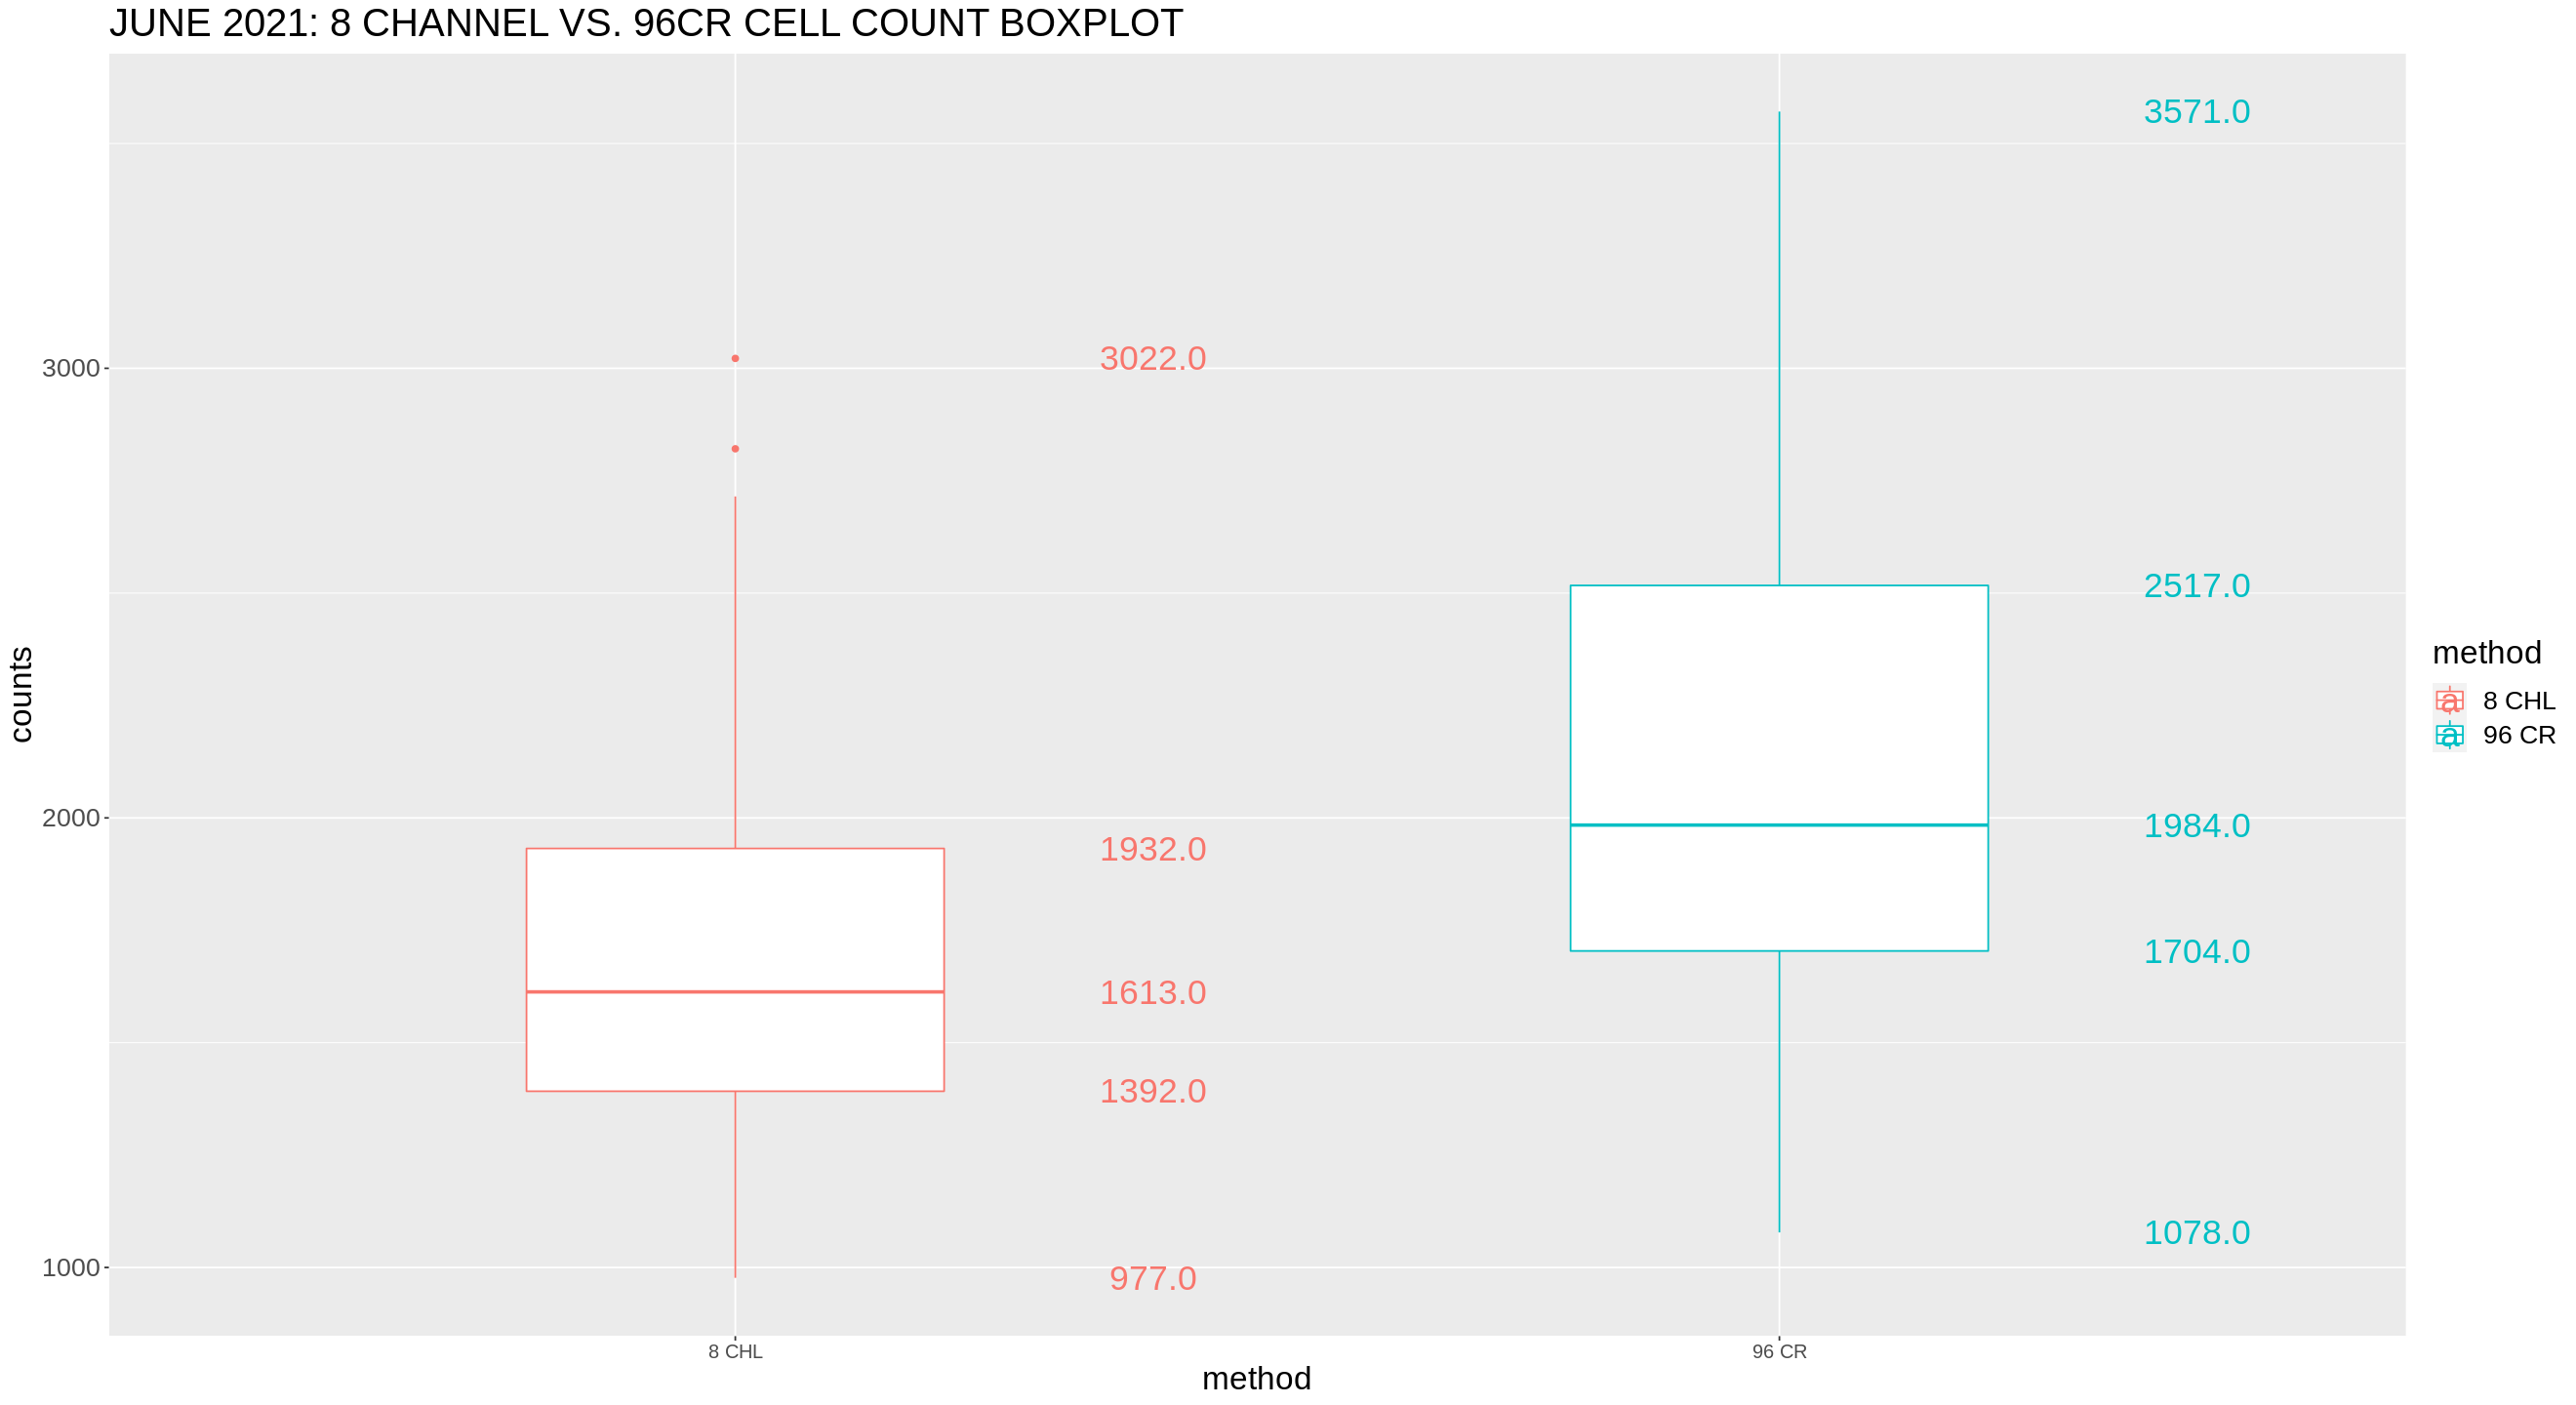

In [73]:
# pooled
ggplot(df.t, aes(method, counts)) +
    geom_boxplot(width = 0.4, aes(colour=method)) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), colour = method),
           position=position_nudge(x=0.4), size=7.5) +
    ggtitle("JUNE 2021: 8 CHANNEL VS. 96CR CELL COUNT BOXPLOT") + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

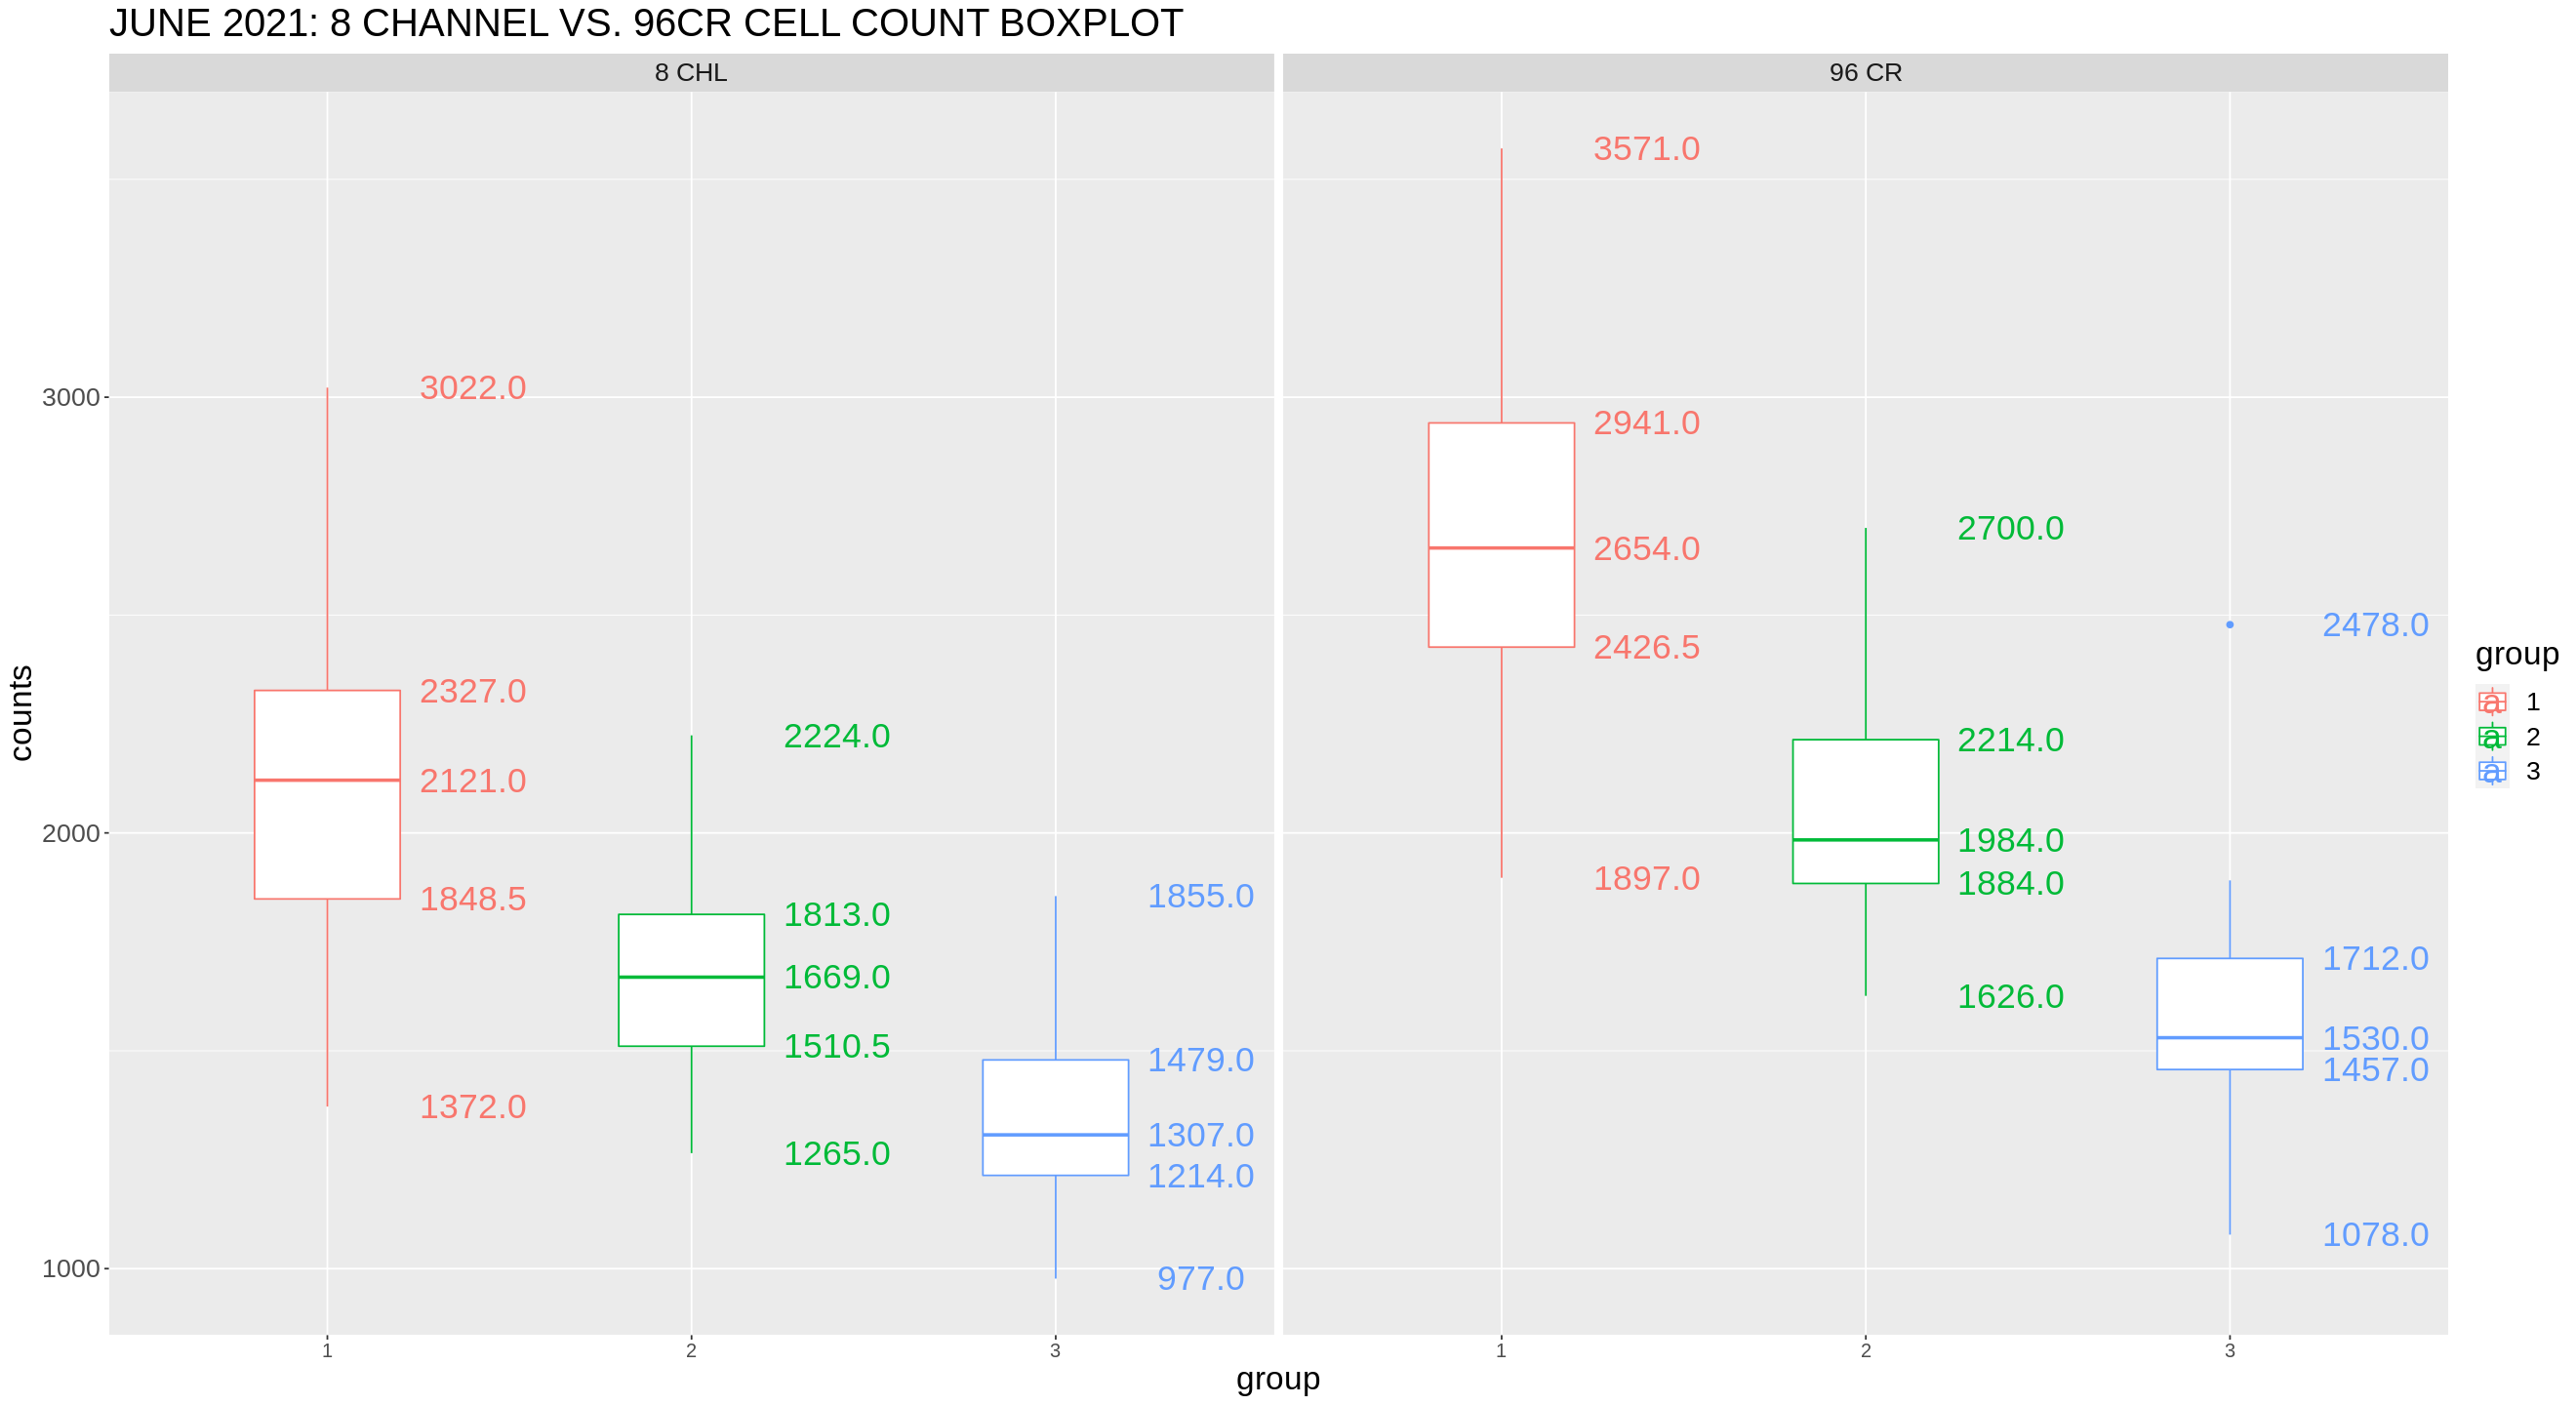

In [63]:
# parired 
ggplot(df.t, aes(group, counts)) +
    geom_boxplot(width = 0.4, aes(group = group, colour = group)) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=group),
           position=position_nudge(x=0.4), size=7.5) +
    ggtitle("JUNE 2021: 8 CHANNEL VS. 96CR CELL COUNT BOXPLOT") + 
    facet_wrap(~method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

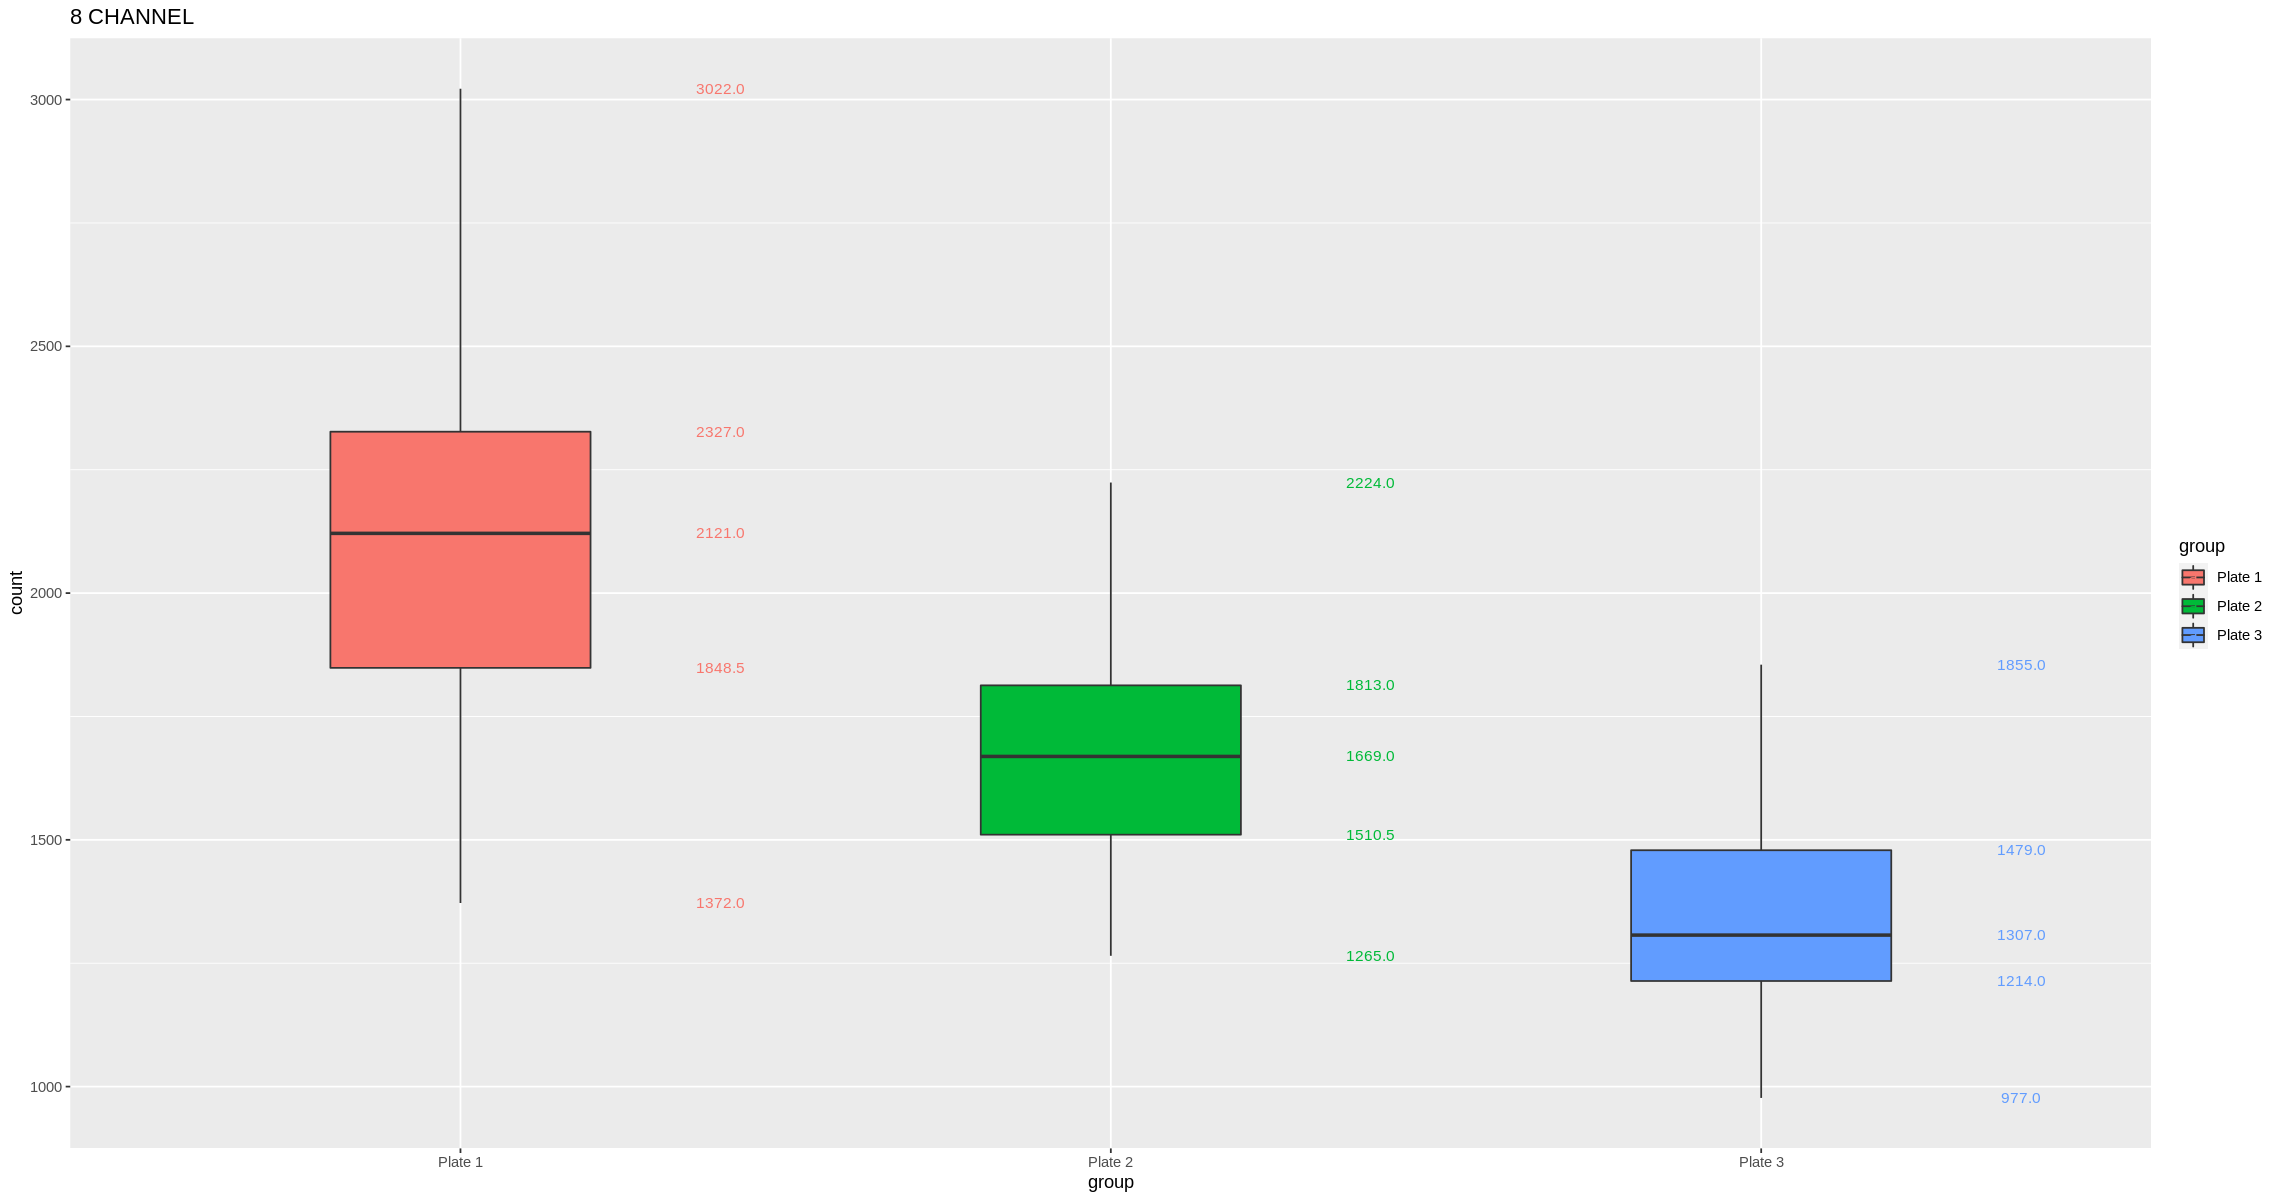

In [34]:
ggplot(df.8chl.cmb, aes(group, count,fill=group)) +
    geom_boxplot(width = 0.4) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=group),
           position=position_nudge(x=0.4), size=3.25) +
    ggtitle("8 CHANNEL")

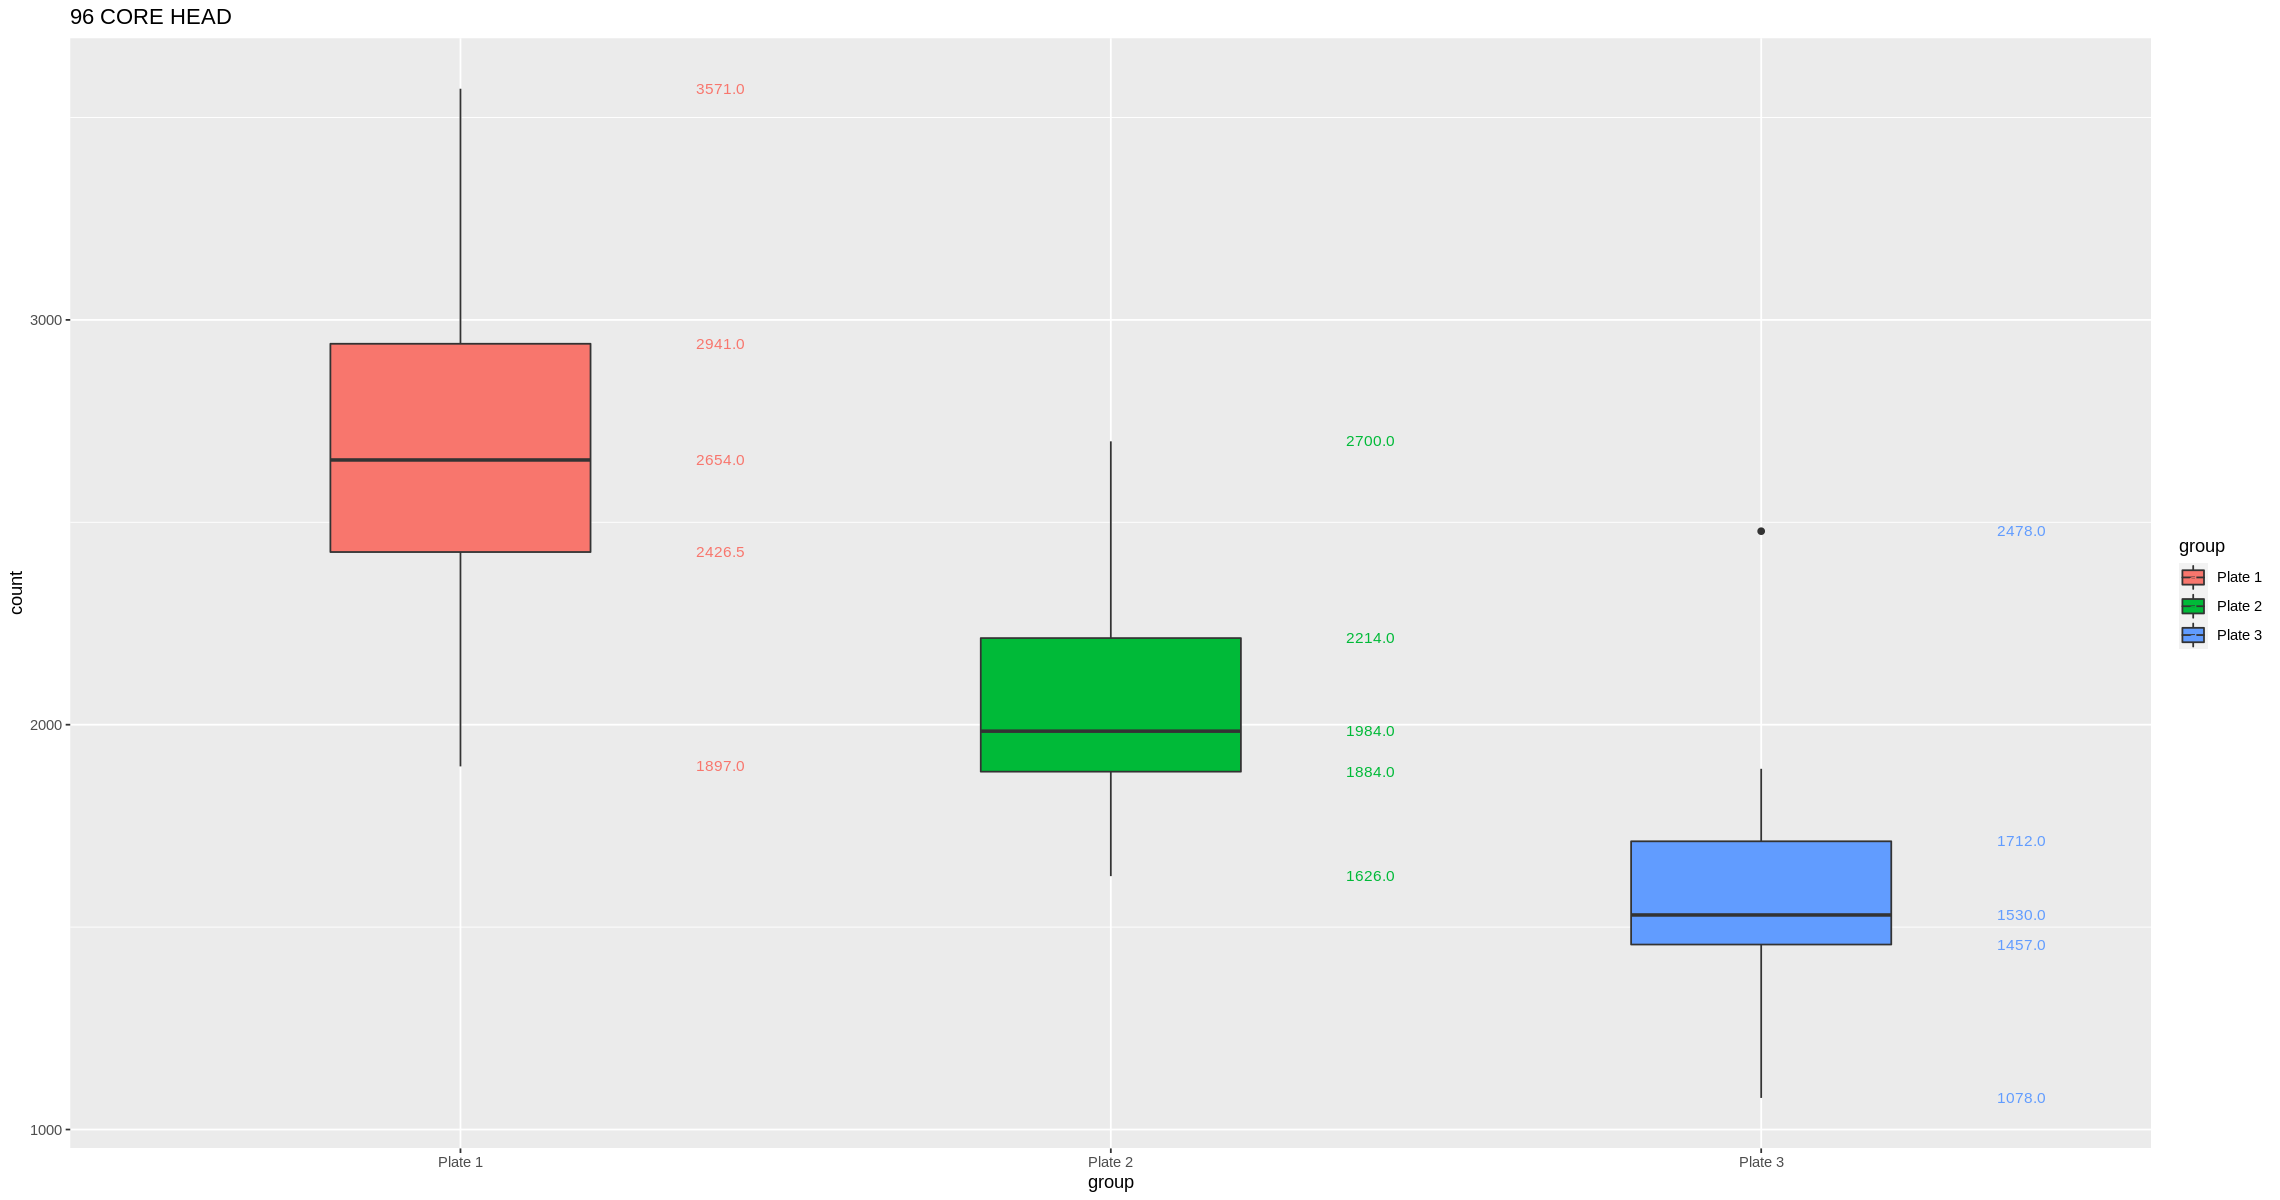

In [33]:
ggplot(df.96cr.cmb, aes(group, count, fill=group)) +
    geom_boxplot(width = 0.4) +
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=group),
           position=position_nudge(x=0.4), size=3.25) +
    ggtitle("96 CORE HEAD")

In [260]:
wellids_src <- rep(paste0(rep(LETTERS[1:8], each = 8), rep(seq(8), times = 8)), round(nrow(df.t)/64,0))
wellids_src <- wellids_src[sapply(wellids_src, function(x) {!grepl(pattern = "A1",x = x)}, USE.NAMES = F)]
wellids_src

[1] "A2" "A3" "A4" "A5" "A6" "A7" "A8" "B1" "B2" "B3" "B4" "B5" "B6" "B7" "B8"
 [16] "C1" "C2" "C3" "C4" "C5" "C6" "C7" "C8" "D1" "D2" "D3" "D4" "D5" "D6" "D7"
 [31] "D8" "E1" "E2" "E3" "E4" "E5" "E6" "E7" "E8" "F1" "F2" "F3" "F4" "F5" "F6"
 [46] "F7" "F8" "G1" "G2" "G3" "G4" "G5" "G6" "G7" "G8" "H1" "H2" "H3" "H4" "H5"
 [61] "H6" "H7" "H8" "A2" "A3" "A4" "A5" "A6" "A7" "A8" "B1" "B2" "B3" "B4" "B5"
 [76] "B6" "B7" "B8" "C1" "C2" "C3" "C4" "C5" "C6" "C7" "C8" "D1" "D2" "D3" "D4"
 [91] "D5" "D6" "D7" "D8" "E1" "E2" "E3" "E4" "E5" "E6" "E7" "E8" "F1" "F2" "F3"
[106] "F4" "F5" "F6" "F7" "F8" "G1" "G2" "G3" "G4" "G5" "G6" "G7" "G8" "H1" "H2"
[121] "H3" "H4" "H5" "H6" "H7" "H8" "A2" "A3" "A4" "A5" "A6" "A7" "A8" "B1" "B2"
[136] "B3" "B4" "B5" "B6" "B7" "B8" "C1" "C2" "C3" "C4" "C5" "C6" "C7" "C8" "D1"
[151] "D2" "D3" "D4" "D5" "D6" "D7" "D8" "E1" "E2" "E3" "E4" "E5" "E6" "E7" "E8"
[166] "F1" "F2" "F3" "F4" "F5" "F6" "F7" "F8" "G1" "G2" "G3" "G4" "G5" "G6" "G7"
[181] "G8" "H1" "H2" "H3" "H4" "H5" "H6" "H7" "H8" "A2" "A3" "A4" "A5" "A6" "A7"
[196] "A8" "B1" "B2" "B3" "B4" "B5" "B6" "B7" "B8" "C1" "C2" "C3" "C4" "C5" "C6"
[211] "C7" "C8" "D1" "D2" "D3" "D4" "D5" "D6" "D7" "D8" "E1" "E2" "E3" "E4" "E5"
[226] "E6" "E7" "E8" "F1" "F2" "F3" "F4" "F5" "F6" "F7" "F8" "G1" "G2" "G3" "G4"
[241] "G5" "G6" "G7" "G8" "H1" "H2" "H3" "H4" "H5" "H6" "H7" "H8" "A2" "A3" "A4"
[256] "A5" "A6" "A7" "A8" "B1" "B2" "B3" "B4" "B5" "B6" "B7" "B8" "C1" "C2" "C3"
[271] "C4" "C5" "C6" "C7" "C8" "D1" "D2" "D3" "D4" "D5" "D6" "D7" "D8" "E1" "E2"
[286] "E3" "E4" "E5" "E6" "E7" "E8" "F1" "F2" "F3" "F4" "F5" "F6" "F7" "F8" "G1"
[301] "G2" "G3" "G4" "G5" "G6" "G7" "G8" "H1" "H2" "H3" "H4" "H5" "H6" "H7" "H8"
[316] "A2" "A3" "A4" "A5" "A6" "A7" "A8" "B1" "B2" "B3" "B4" "B5" "B6" "B7" "B8"
[331] "C1" "C2" "C3" "C4" "C5" "C6" "C7" "C8" "D1" "D2" "D3" "D4" "D5" "D6" "D7"
[346] "D8" "E1" "E2" "E3" "E4" "E5" "E6" "E7" "E8" "F1" "F2" "F3" "F4" "F5" "F6"
[361] "F7" "F8" "G1" "G2" "G3" "G4" "G5" "G6" "G7" "G8" "H1" "H2" "H3" "H4" "H5"
[376] "H6" "H7" "H8"

In [263]:
dft <- df.t %>% mutate(wellid = wellids_src) 
head(dft)

counts group method wellid
1 3222   1     96 CR  A2    
2 3310   1     96 CR  A3    
3 3062   1     96 CR  A4    
4 3123   1     96 CR  A5    
5 3143   1     96 CR  A6    
6 2992   1     96 CR  A7

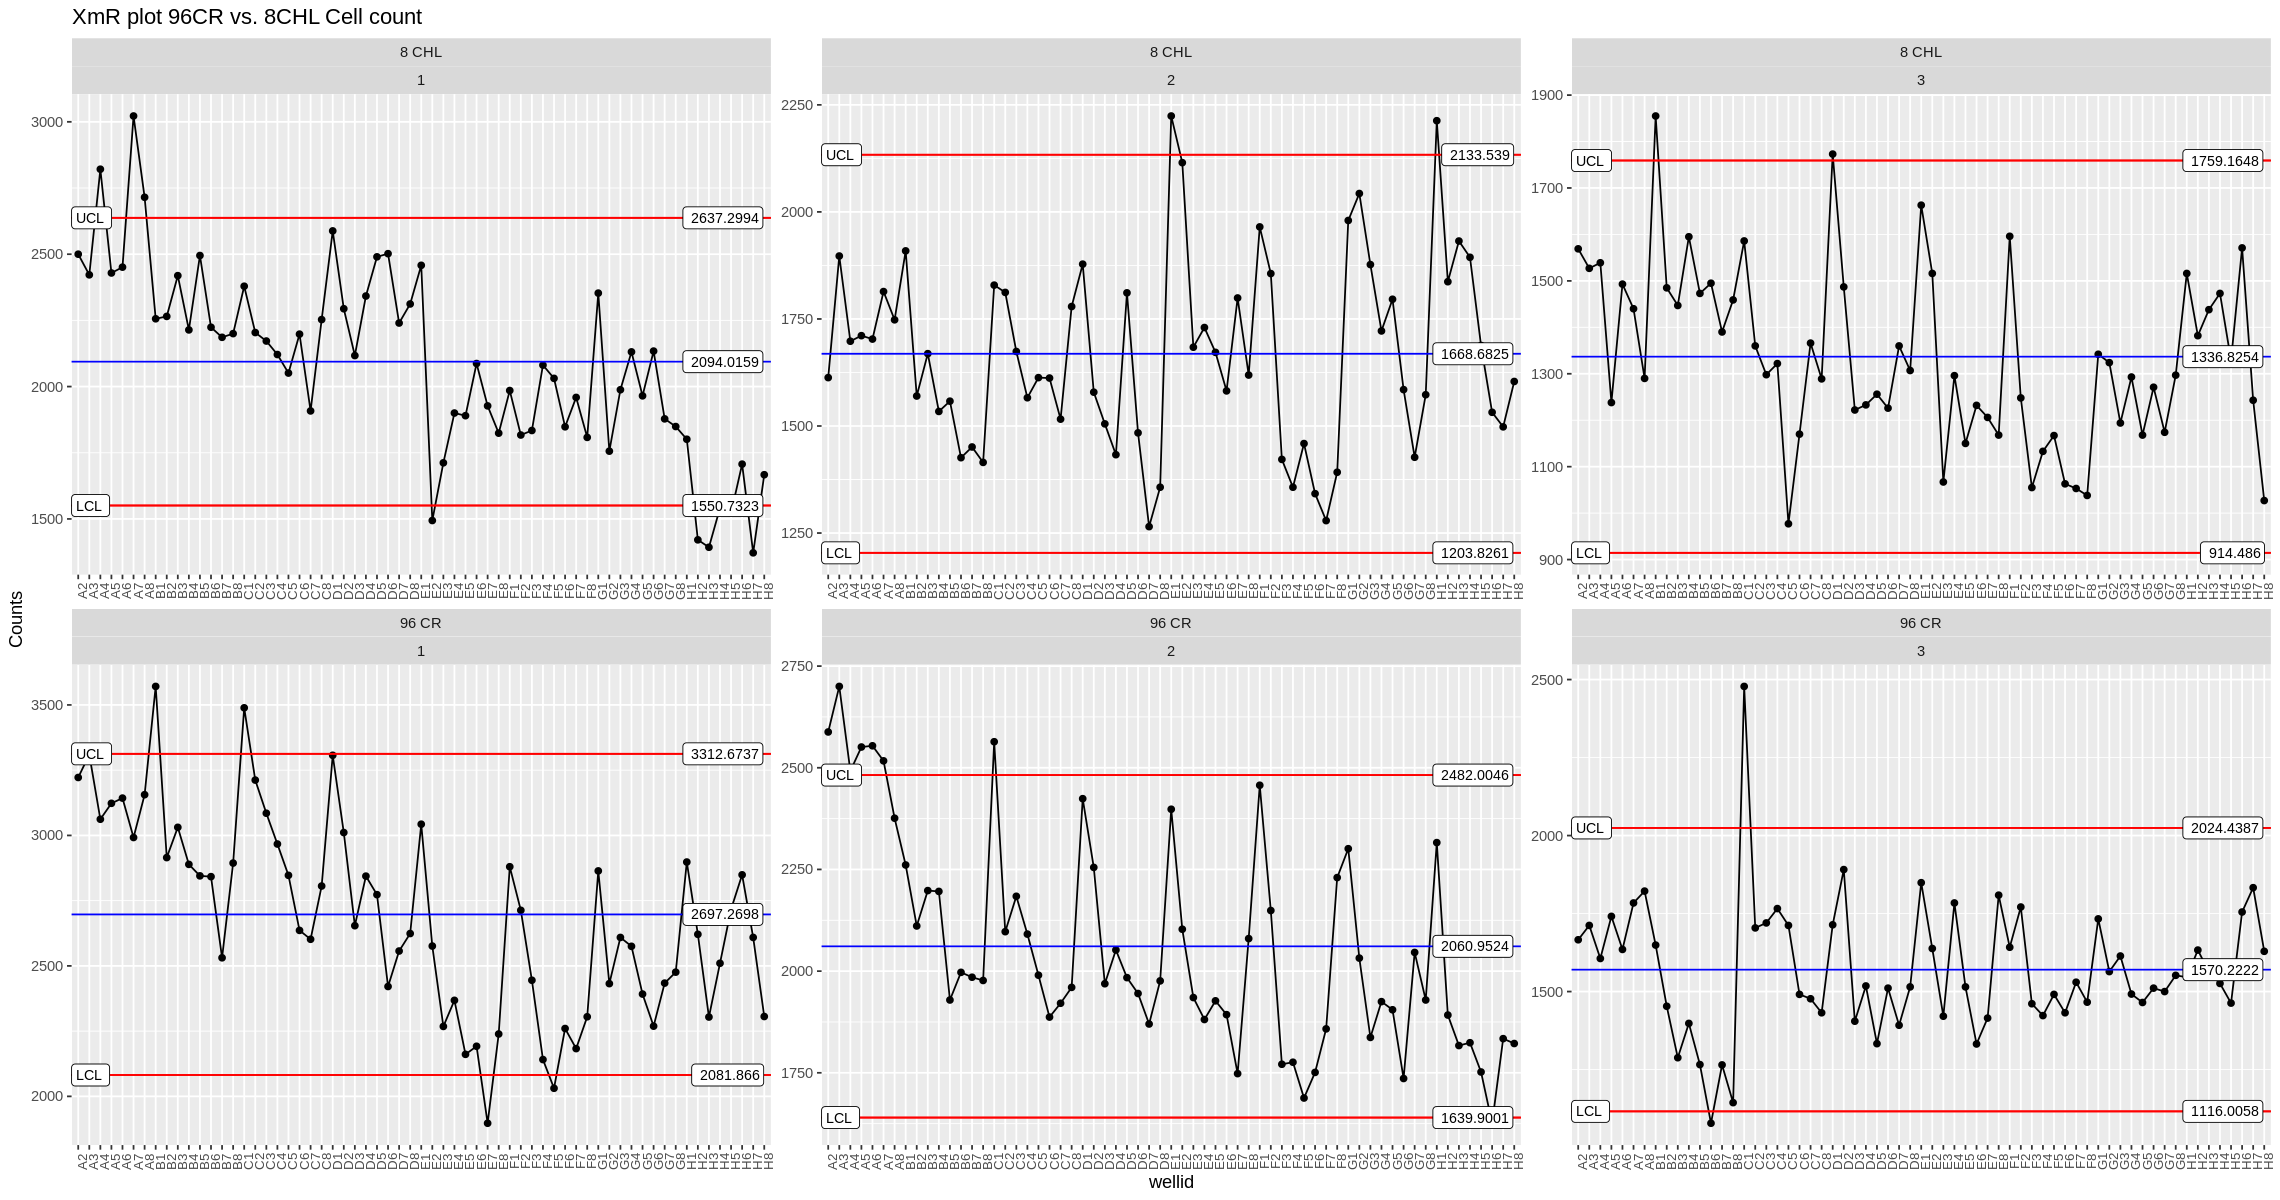

In [266]:
ggplot(dft, aes(x=wellid, y=counts, group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("Counts") +
  facet_wrap(method~group, scales = "free") +
  ggtitle("XmR plot 96CR vs. 8CHL Cell count") + 
  theme(axis.text.x = element_text(size = 8, angle = 90))

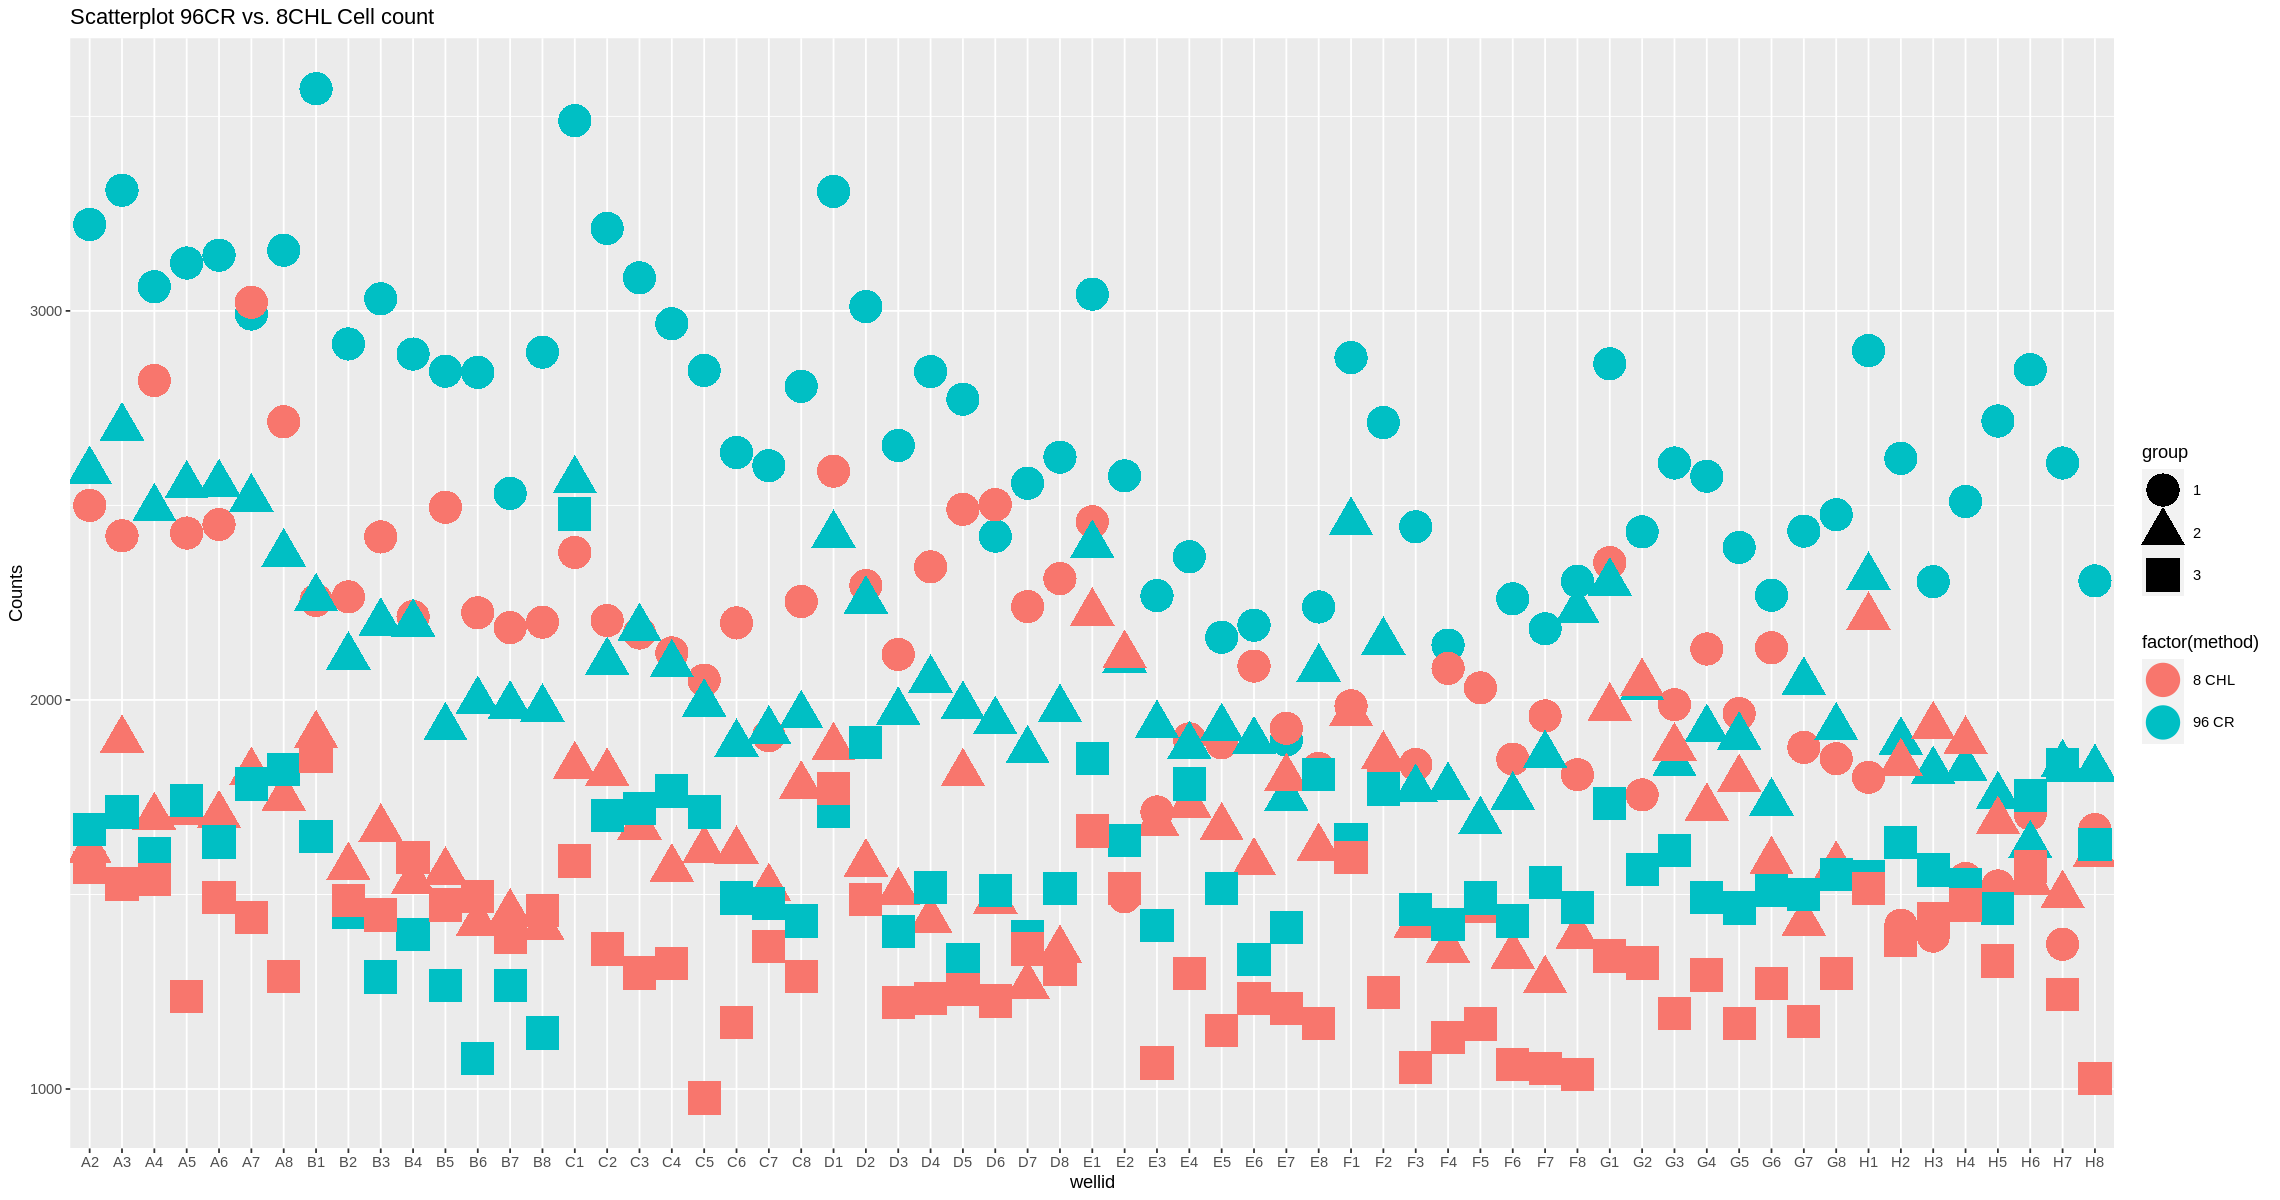

In [274]:
ggplot(dft, aes(x=wellid, y=counts) ) +
  geom_point(size = 9, aes(colour = factor(method), shape = group)) + 
  ylab("Counts") +
  ggtitle("Scatterplot 96CR vs. 8CHL Cell count")

In [565]:
# pool all three sets and run t-test to compare 
t.test(df.8chl.cmb$count, df.96cr.cmb$count, 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  df.8chl.cmb$count and df.96cr.cmb$count
t = -8.3043, df = 347.46, p-value = 2.267e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -506.6605 -312.6199
sample estimates:
mean of x mean of y 
 1699.841  2109.481 


In [566]:
# t-test on plate 1 of both 8 channel & 96 CORE
t.test(cell_cnts_8chl[[1]], cell_cnts_96cr[[1]],
       alternative = "two.sided",
       paired = FALSE, var.equal = F,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  cell_cnts_8chl[[1]] and cell_cnts_96cr[[1]]
t = -9.4096, df = 123.56, p-value = 3.488e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -730.1505 -476.3574
sample estimates:
mean of x mean of y 
 2094.016  2697.270 


In [567]:
# t-test on plate 2 of both 8 channel & 96 CORE
t.test(cell_cnts_8chl[[2]], cell_cnts_96cr[[2]],
       alternative = "two.sided",
       paired = FALSE, var.equal = F,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  cell_cnts_8chl[[2]] and cell_cnts_96cr[[2]]
t = -9.1719, df = 120.59, p-value = 1.551e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -476.9449 -307.5947
sample estimates:
mean of x mean of y 
 1668.683  2060.952 


In [568]:
# t-test on plate 3 of both 8 channel & 96 CORE
t.test(cell_cnts_8chl[[3]], cell_cnts_96cr[[3]],
       alternative = "two.sided",
       paired = FALSE, var.equal = F,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  cell_cnts_8chl[[3]] and cell_cnts_96cr[[3]]
t = -6.6067, df = 122.53, p-value = 1.073e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -303.3278 -163.4658
sample estimates:
mean of x mean of y 
 1336.825  1570.222 


In [569]:
colnames(df.8chl.cmb) <- c('cnt', 'group')

In [651]:
suppressMessages(group_by(df.8chl.cmb, group) %>%
  summarise(
    count = n(),
    mean = mean(`cnt`),
    sd = sd(`cnt`)
  ))

group   count mean     sd      
1 Plate 1 63    2094.016 348.8698
2 Plate 2 63    1668.683 218.9389
3 Plate 3 63    1336.825 187.1069

#### ANOVA test for each set of three plates

In [571]:
# Compute the analysis of variance for 8 channel
res.aov.8chl <- aov(cnt ~ group, data = df.8chl.cmb)
# Summary of the analysis
summary(res.aov.8chl)
# As the p-value is less than the significance level 0.05, 
# we can conclude that there are significant differences between the 
# groups highlighted with “*" in the model summary

             Df   Sum Sq Mean Sq F value Pr(>F)    
group         2 18151876 9075938     133 <2e-16 ***
Residuals   186 12688508   68218                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [572]:
colnames(df.96cr.cmb) <- c('cnt', 'group')

In [649]:
suppressMessages(group_by(df.96cr.cmb, group) %>%
  summarise(
    count = n(),
    mean = mean(`cnt`),
    sd = sd(`cnt`)
  ))

group   count mean     sd      
1 Plate 1 63    2697.270 370.4422
2 Plate 2 63    2060.952 259.4297
3 Plate 3 63    1570.222 208.8455

In [574]:
# Compute the analysis of variance for 96 core head
res.aov.96cr <- aov(cnt ~ group, data = df.96cr.cmb)
# Summary of the analysis
summary(res.aov.96cr)
# As the p-value is less than the significance level 0.05, 
# we can conclude that there are significant differences between the 
# groups highlighted with “*" in the model summary

             Df   Sum Sq  Mean Sq F value Pr(>F)    
group         2 40234999 20117500   243.2 <2e-16 ***
Residuals   186 15385152    82716                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

- In one-way ANOVA test, a significant p-value indicates that some of the group means are different, but we don’t know which pairs of groups are different.

- It’s possible to perform multiple pairwise-comparison, to determine if the mean difference between specific pairs of group are statistically significant.

- Use the Tukey to conduct this

In [575]:
TukeyHSD(res.aov.96cr)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = cnt ~ group, data = df.96cr.cmb)

$group
                      diff        lwr        upr p adj
Plate 2-Plate 1  -636.3175  -757.3869  -515.2480     0
Plate 3-Plate 1 -1127.0476 -1248.1171 -1005.9782     0
Plate 3-Plate 2  -490.7302  -611.7996  -369.6607     0


In [576]:
TukeyHSD(res.aov.8chl)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = cnt ~ group, data = df.8chl.cmb)

$group
                     diff       lwr       upr p adj
Plate 2-Plate 1 -425.3333 -535.2818 -315.3849     0
Plate 3-Plate 1 -757.1905 -867.1389 -647.2421     0
Plate 3-Plate 2 -331.8571 -441.8056 -221.9087     0


In [577]:
pairwise.t.test(df.96cr.cmb$cnt, df.96cr.cmb$group,
                 p.adjust.method = "BH")
# pairewise.t.test() can be also used to calculate pairwise comparisons 
# between group levels with corrections for multiple testing
# The result is a table of p-values for the pairwise comparisons. 
# Here, the p-values have been adjusted by the Benjamini-Hochberg method.


	Pairwise comparisons using t tests with pooled SD 

data:  df.96cr.cmb$cnt and df.96cr.cmb$group 

        Plate 1 Plate 2
Plate 2 <2e-16  -      
Plate 3 <2e-16  <2e-16 

P value adjustment method: BH 

In [668]:
pairwise.t.test(df.8chl.cmb$cnt, df.8chl.cmb$group,
                 p.adjust.method = "BH")


	Pairwise comparisons using t tests with pooled SD 

data:  df.8chl.cmb$cnt and df.8chl.cmb$group 

        Plate 1 Plate 2
Plate 2 < 2e-16 -      
Plate 3 < 2e-16 2.1e-11

P value adjustment method: BH 

"residuals versus fits plot" is the most frequently created plot. It is a scatter plot of residuals on the y axis and fitted values (estimated responses) on the x axis. The plot is used to detect non-linearity, unequal error variances, and outliers.

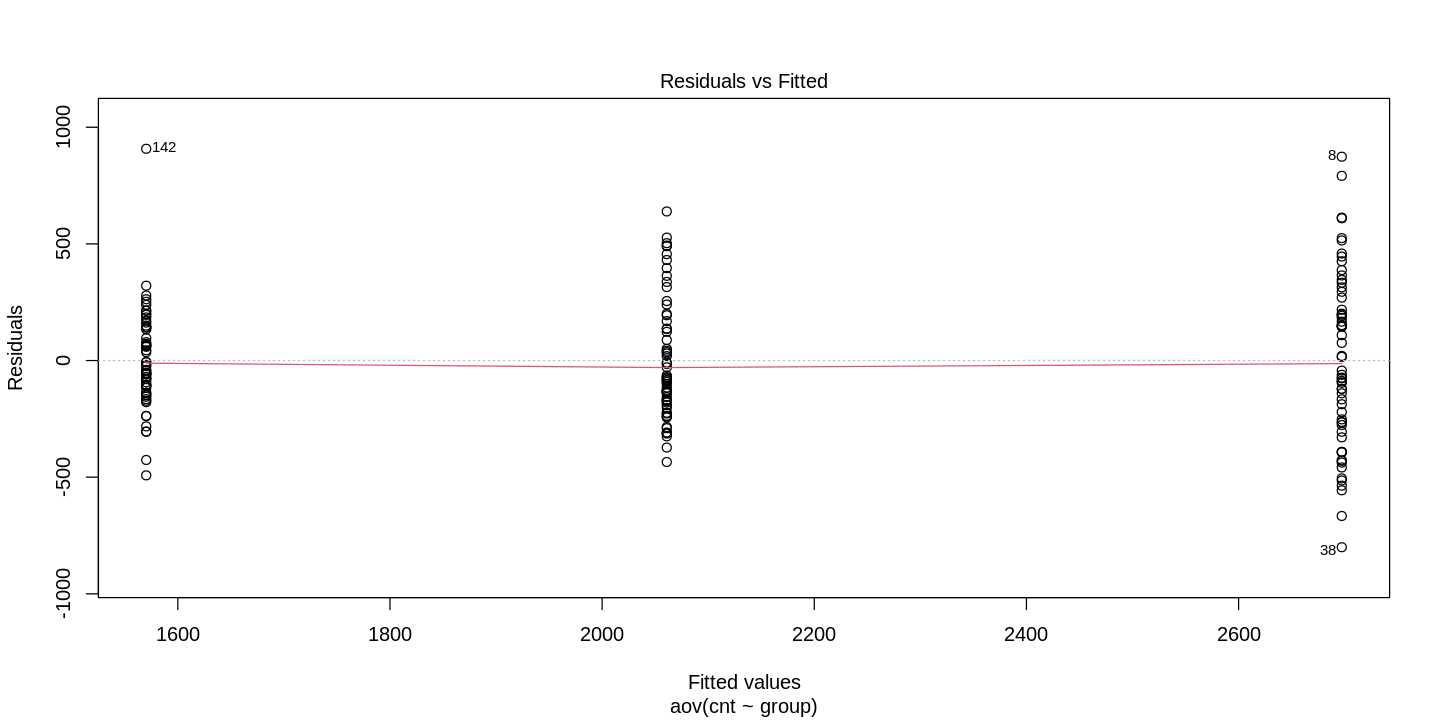

In [578]:
plot(res.aov.96cr, 1)

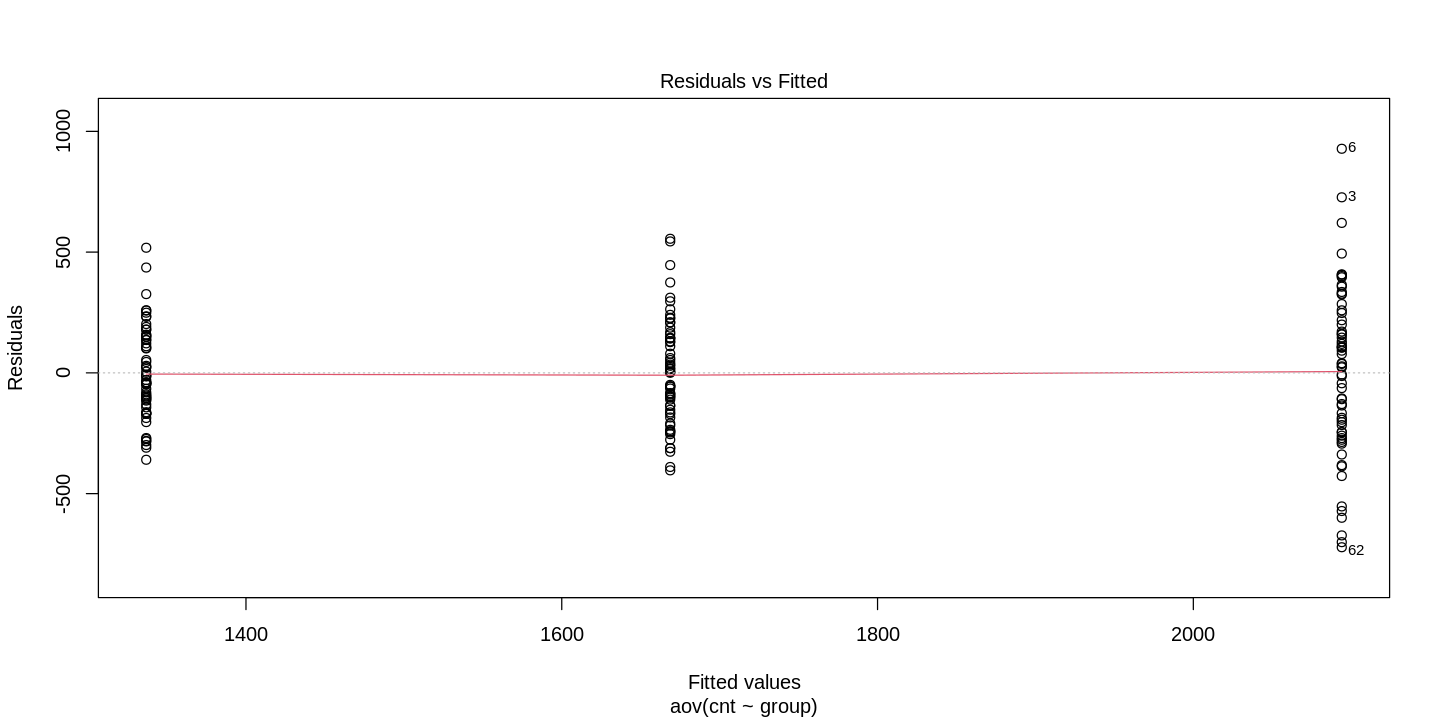

In [579]:
plot(res.aov.8chl, 1)

#### USE SI AS SAMPLE DATA

In [3]:
parentdir <- "flowjo_data/96vs8/"

In [4]:
dfsi_8chl <- list()
dfsi_96cr <- list()
chl8_file <- list.files(parentdir, pattern = "New Sp.*Lymp*")
cr96_file <- list.files(parentdir, pattern = "96.*Lymp*")
for (i in seq(3)) {
    dfsi_8chl[[i]] <- read.csv(paste0(parentdir, chl8_file[i])) %>% 
                            dplyr::filter(grepl('[A-H]0[2-9]|1[0-2])', Sample.)) %>%
                            mutate_at(vars(Lymph.MFI..., Stain.Index), funs(as.numeric))
    dfsi_96cr[[i]] <- read.csv(paste0(parentdir, cr96_file[i])) %>% 
                            dplyr::filter(grepl('[A-H]0[2-9]|1[0-2])', Sample.)) %>%
                            mutate_at(vars(Lymph.MFI..., Stain.Index), funs(as.numeric))
    }

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [22]:
# for flowjo data
si.pos.8chl <- list()
si.pos.96cr <- list()

for (i in seq(3)) {
    si.pos.8chl[[i]] <- data.frame(`si+`= dfsi_8chl[[i]]$Stain.Index, group = rep(paste0("Plate ", i), 56))
    si.pos.96cr[[i]] <- data.frame(`si+` = dfsi_96cr[[i]]$Stain.Index, group = rep(paste0("Plate ", i), 56))
    }

In [23]:
df_si_cmb_8chl_12 <- rbind(si.pos.8chl[[1]], si.pos.8chl[[2]])
df_si_cmb_8chl_23 <- rbind(si.pos.8chl[[2]], si.pos.8chl[[3]])
df_si_cmb_8chl_13 <- rbind(si.pos.8chl[[1]], si.pos.8chl[[3]])
df_si_cmb_96cr_12 <- rbind(si.pos.96cr[[1]], si.pos.96cr[[2]])
df_si_cmb_96cr_23 <- rbind(si.pos.96cr[[2]], si.pos.96cr[[3]])
df_si_cmb_96cr_13 <- rbind(si.pos.96cr[[1]], si.pos.96cr[[3]])

#### F test for normality
The p values are big, meaning the variances do not change more from plate 1 to 3

In [24]:
df_si_cmb_9v8_11 <- rbind(si.pos.8chl[[1]], si.pos.96cr[[1]]) %>% mutate(method = c(rep("8CHL", 56), rep("96CR", 56)))
df_si_cmb_9v8_22 <- rbind(si.pos.8chl[[2]], si.pos.96cr[[2]]) %>% mutate(method = c(rep("8CHL", 56), rep("96CR", 56)))
df_si_cmb_9v8_33 <- rbind(si.pos.8chl[[3]], si.pos.96cr[[3]]) %>% mutate(method = c(rep("8CHL", 56), rep("96CR", 56)))

In [81]:
var.test(si. ~ method, df_si_cmb_9v8_11)


	F test to compare two variances

data:  si. by method
F = 15.198, num df = 55, denom df = 55, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  8.909009 25.925417
sample estimates:
ratio of variances 
          15.19769 


In [82]:
var.test(si. ~ method, df_si_cmb_9v8_22)


	F test to compare two variances

data:  si. by method
F = 0.84238, num df = 55, denom df = 55, p-value = 0.5269
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.493809 1.436995
sample estimates:
ratio of variances 
         0.8423783 


In [83]:
var.test(si. ~ method, df_si_cmb_9v8_33)


	F test to compare two variances

data:  si. by method
F = 4.6397, num df = 55, denom df = 55, p-value = 5.969e-08
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.719825 7.914753
sample estimates:
ratio of variances 
          4.639693 


In [65]:
var.test(si. ~ group, df_si_cmb_8chl_12)


	F test to compare two variances

data:  si. by group
F = 6.2062, num df = 55, denom df = 55, p-value = 2.237e-10
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  3.638151 10.587102
sample estimates:
ratio of variances 
          6.206245 


In [25]:
dfsi.t <- rbind(df_si_cmb_9v8_11, df_si_cmb_9v8_22, df_si_cmb_9v8_33)

for (i in seq(3)) {
    
    print(var.test(si. ~ method, dfsi.t %>% filter(group == paste("Plate", i))))
    
}


	F test to compare two variances

data:  si. by method
F = 15.198, num df = 55, denom df = 55, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  8.909009 25.925417
sample estimates:
ratio of variances 
          15.19769 


	F test to compare two variances

data:  si. by method
F = 0.84238, num df = 55, denom df = 55, p-value = 0.5269
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.493809 1.436995
sample estimates:
ratio of variances 
         0.8423783 


	F test to compare two variances

data:  si. by method
F = 4.6397, num df = 55, denom df = 55, p-value = 5.969e-08
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.719825 7.914753
sample estimates:
ratio of variances 
          4.639693 



In [111]:
var.test(si. ~ group, df_si_cmb_8chl_13)


	F test to compare two variances

data:  si. by group
F = 0.71228, num df = 55, denom df = 55, p-value = 0.2115
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.4175442 1.2150631
sample estimates:
ratio of variances 
         0.7122798 


In [133]:
var.test(si. ~ group, df_si_cmb_8chl_23)


	F test to compare two variances

data:  si. by group
F = 0.11477, num df = 55, denom df = 55, p-value = 1.707e-13
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.06727807 0.19578072
sample estimates:
ratio of variances 
         0.1147682 


In [134]:
var.test(si. ~ group, df_si_cmb_96cr_12)


	F test to compare two variances

data:  si. by group
F = 0.344, num df = 55, denom df = 55, p-value = 0.0001174
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.2016556 0.5868225
sample estimates:
ratio of variances 
         0.3440001 


In [135]:
var.test(si. ~ group, df_si_cmb_96cr_13)


	F test to compare two variances

data:  si. by group
F = 0.21745, num df = 55, denom df = 55, p-value = 7.011e-08
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.1274718 0.3709458
sample estimates:
ratio of variances 
         0.2174514 


In [136]:
var.test(si. ~ group, df_si_cmb_96cr_23)


	F test to compare two variances

data:  si. by group
F = 0.63213, num df = 55, denom df = 55, p-value = 0.09184
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.3705575 1.0783306
sample estimates:
ratio of variances 
         0.6321261 


In [88]:
#wilcoxon and t-test for SI
for (i in seq(3)) {
    pair_test(si.pos.8chl[[i]]$si., si.pos.96cr[[i]]$si.)
}


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 845, p-value = 2.618e-05
alternative hypothesis: true location shift is not equal to 0


	Welch Two Sample t-test

data:  x and y
t = -6.1203, df = 62.207, p-value = 6.89e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -42.10290 -21.37228
sample estimates:
mean of x mean of y 
 256.0236  287.7611 


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 3132, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Welch Two Sample t-test

data:  x and y
t = 21.282, df = 109.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 57.54913 69.36880
sample estimates:
mean of x mean of y 
 330.4477  266.9887 


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 1880, p-value = 0.06988
alternative hypothesis: true location shift is not equ

#### Anderson-Darling test
- goodness of fit test that measures how well your data fit a specified distribution.
- H_0: The data follow a specified distribution

In [89]:
ad.test(si.pos.8chl[[1]]$si.)


	Anderson-Darling normality test

data:  si.pos.8chl[[1]]$si.
A = 2.6574, p-value = 8.685e-07


In [90]:
ad.test(si.pos.8chl[[2]]$si.)


	Anderson-Darling normality test

data:  si.pos.8chl[[2]]$si.
A = 0.29252, p-value = 0.5923


In [91]:
ad.test(si.pos.8chl[[3]]$si.)


	Anderson-Darling normality test

data:  si.pos.8chl[[3]]$si.
A = 1.3254, p-value = 0.001753


In [93]:
ad.test(si.pos.96cr[[1]]$si.)


	Anderson-Darling normality test

data:  si.pos.96cr[[1]]$si.
A = 0.23991, p-value = 0.7663


In [94]:
ad.test(si.pos.96cr[[2]]$si.)


	Anderson-Darling normality test

data:  si.pos.96cr[[2]]$si.
A = 0.27909, p-value = 0.6346


In [92]:
ad.test(si.pos.96cr[[3]]$si.)


	Anderson-Darling normality test

data:  si.pos.96cr[[3]]$si.
A = 0.9089, p-value = 0.0192


In [ ]:
# entire set of 3

In [84]:
ad.test(df_si_cmb_9v8_11$si.)


	Anderson-Darling normality test

data:  df_si_cmb_9v8_11$si.
A = 4.956, p-value = 2.458e-12


In [85]:
ad.test(df_si_cmb_9v8_22$si.)


	Anderson-Darling normality test

data:  df_si_cmb_9v8_22$si.
A = 2.6992, p-value = 7.639e-07


In [86]:
ad.test(df_si_cmb_9v8_33$si.)


	Anderson-Darling normality test

data:  df_si_cmb_9v8_33$si.
A = 2.2688, p-value = 8.71e-06


In [137]:
ad.test(si.pos.8chl[[1]]$si.)


	Anderson-Darling normality test

data:  si.pos.8chl[[1]]$si.
A = 2.6574, p-value = 8.685e-07


In [138]:
ad.test(si.pos.8chl[[2]]$si.)


	Anderson-Darling normality test

data:  si.pos.8chl[[2]]$si.
A = 0.29252, p-value = 0.5923


In [139]:
ad.test(si.pos.8chl[[3]]$si.)


	Anderson-Darling normality test

data:  si.pos.8chl[[3]]$si.
A = 1.3254, p-value = 0.001753


In [140]:
ad.test(si.pos.96cr[[1]]$si.)


	Anderson-Darling normality test

data:  si.pos.96cr[[1]]$si.
A = 0.23991, p-value = 0.7663


In [141]:
ad.test(si.pos.96cr[[2]]$si.)


	Anderson-Darling normality test

data:  si.pos.96cr[[2]]$si.
A = 0.27909, p-value = 0.6346


In [142]:
ad.test(si.pos.96cr[[3]]$si.)


	Anderson-Darling normality test

data:  si.pos.96cr[[3]]$si.
A = 0.9089, p-value = 0.0192


#### Shapiro test, bonett test, qq plot to show normality
- shapiro-wilk test - tell if a random sample comes from a normal distribution
- bonett test - measure of kurtosis for normally distributed data

In [30]:
summary(si.pos.8chl[[2]])

      si.           group          
 Min.   :292.2   Length:56         
 1st Qu.:317.5   Class :character  
 Median :331.3   Mode  :character  
 Mean   :330.4                     
 3rd Qu.:340.7                     
 Max.   :363.3                     

In [29]:
summary(si.pos.96cr[[2]])

      si.           group          
 Min.   :226.4   Length:56         
 1st Qu.:257.8   Class :character  
 Median :266.5   Mode  :character  
 Mean   :267.0                     
 3rd Qu.:276.8                     
 Max.   :304.4                     

In [31]:
for (i in seq(3)) {
   data = c(si.pos.8chl[[i]]$si, si.pos.96cr[[i]]$si)
   stat <- var.test(si.pos.8chl[[i]]$si, si.pos.96cr[[i]]$si)
   df_stats[i, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
   print(stat)
   stat <- ad.test(data)
   df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
   print(stat)
   stat <- shapiro.test(data)
   df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_S"] = stat$p.value > 0.05
   print(stat)
   stat <- bonett.test(data)
   df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   df_stats[i, "GT_A_B"] = stat$p.value > 0.05
   print(stat)
   print("geary result:")
   stat <- geary(data)
   df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
   df_stats[i, "GT_PI"] = stat > 0.7979
   print(stat)
}
df_stats
write.csv(df_stats, paste0("96v8_june_pair_3plts_stats_si.csv"), row.names = FALSE)


	F test to compare two variances

data:  si.pos.8chl[[i]]$si and si.pos.96cr[[i]]$si
F = 15.198, num df = 55, denom df = 55, p-value < 2.2e-16
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  8.909009 25.925417
sample estimates:
ratio of variances 
          15.19769 


	Anderson-Darling normality test

data:  data
A = 4.956, p-value = 2.458e-12


	Shapiro-Wilk normality test

data:  data
W = 0.91027, p-value = 1.421e-06


	Bonett-Seier test for Geary kurtosis

data:  data
tau = 26.8366, z = -2.6447, p-value = 0.008177
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "geary result:"
[1] 0.8523522

	F test to compare two variances

data:  si.pos.8chl[[i]]$si and si.pos.96cr[[i]]$si
F = 0.84238, num df = 55, denom df = 55, p-value = 0.5269
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.493809 1.436995
sample estimates:
ratio of variances 
         0.8423783 


	Anders

F_TEST   GT_A_FT AD_TEST  GT_A_AD SHAPIRO_TEST GT_A_S BONETT_TEST GT_A_B
1 0.00e+00 FALSE   2.46e-12 FALSE   1.42e-06     FALSE  8.18e-03    FALSE 
2 5.27e-01  TRUE   7.64e-07 FALSE   5.90e-05     FALSE  2.34e-07    FALSE 
3 5.97e-08 FALSE   8.71e-06 FALSE   4.55e-05     FALSE  1.50e-06    FALSE 
  GEARY    GT_PI
1 8.52e-01  TRUE
2 9.08e-01  TRUE
3 7.08e-01 FALSE

In [34]:
df.t <- do.call(rbind, si.pos.8chl)
head(df.t)

si.      group  
1 226.5883 Plate 1
2 248.4831 Plate 1
3 228.7705 Plate 1
4 292.1198 Plate 1
5 333.8854 Plate 1
6 253.8196 Plate 1

In [38]:
# pooled plates
df_stats <- data.frame()
i = 1

stat <- ad.test(x = df.t$si.)
df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
stat <- shapiro.test(df.t$si.)
df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_SHAP"] = stat$p.value > 0.05
print(stat)
stat <- bonett.test(df.t$si.)
df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_BONN"] = stat$p.value > 0.05
print(stat)
stat <- geary(df.t$si.)
df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
df_stats[i, "GT_A_GEAR"] = stat > 0.05
print(stat)

write.csv(df_stats, paste0("96v8_stats_pooled_param_3plts_si.csv"), row.names = FALSE)


	Shapiro-Wilk normality test

data:  df.t$si.
W = 0.94042, p-value = 1.761e-06


	Bonett-Seier test for Geary kurtosis

data:  df.t$si.
tau = 39.0102, z = -2.6451, p-value = 0.008166
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.8422354


In [32]:
reagents <- "BV-421" 
df_stats <- data.frame()

for (i in seq(3)) {
        plt = paste("PLATE", i)
        df_stats[i, "PLATE"] = plt 
        df_stats[i, "REAGENT"] = reagents
        
        df8 = si.pos.8chl[[i]]$si
        df96 = si.pos.96cr[[i]]$si
    
        df_stats[i, "MEAN.8CHL"] = formatC(mean(df8), format = "e", digits = 2)
        df_stats[i, "MEAN.96CR"] = formatC(mean(df96), format = "e", digits = 2)
        df_stats[i, "MIN.8CHL"] = formatC(min(df8), format = "e", digits = 2)
        df_stats[i, "MIN.96CR"] = formatC(min(df96), format = "e", digits = 2)
        df_stats[i, "MAX.8CHL"] = formatC(max(df8), format = "e", digits = 2)
        df_stats[i, "MAX.96CR"] = formatC(max(df96), format = "e", digits = 2)
        df_stats[i, "SD.8CHL"] = formatC(sd(df8), format = "e", digits = 2)
        df_stats[i, "SD.96CR"] = formatC(sd(df96), format = "e", digits = 2)
        pctdiff = abs( mean(df8) - mean(df96)) / (mean( mean(df8), mean(df96))/2)
        df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
        df_stats[i, "CV.8CHL"] = formatC(sd(df8)/mean(df8), format = "e", digits = 2)
        df_stats[i, "CV.96CR"] = formatC(sd(df96)/mean(df96), format = "e", digits = 2)
}
write.csv(df_stats, paste0("96v8_june_pair_stats_si_3plts.csv"), row.names = FALSE)

In [97]:
p_qq_8chl_si <- list()
p_qq_96cr_si <- list()
p_hst_8chl_si <- list()
p_hst_96cr_si <- list()
df_violin_96cr_si <- list()
df_violin_8chl_si <- list()

df <- dfsi_8chl[[1]] %>% select(Stain.Index) %>% mutate(group = "Plate 1")
df_violin_8chl_si[[1]] <- df

p_qq_8chl_si[[1]] <- ggplot(data.frame(si = df$Stain.Index), aes(sample = si)) + 
                stat_qq() + stat_qq_line()
p_hst_8chl_si[[1]] <- ggplot(data.frame(si = df$Stain.Index), aes(si)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(df$Stain.Index), sd = sd(df$Stain.Index)), 
        lwd = 2, 
        col = '#1F629F'
      )
shap_res <- shapiro.test(df[['Stain.Index']])
bon_res <- bonett.test(df[['Stain.Index']])
shap_res


	Shapiro-Wilk normality test

data:  df[["Stain.Index"]]
W = 0.894, p-value = 0.0001356


In [8]:
# Under the hypothesis of normality, data should have Geary's kurtosis equal to sqrt(2/pi) (0.7979)
bon_res


	Bonett-Seier test for Geary kurtosis

data:  df[["Stain.Index"]]
tau = 33.1140, z = -3.0876, p-value = 0.002018
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)


In [9]:
# the kurtosis is near .7979, with p-value barely above 0.05, indicating it is slightly normal
geary(df$`Stain.Index`)

[1] 0.8889233

In [98]:
df <- dfsi_96cr[[1]] %>% select(Stain.Index) %>% mutate(group = "Plate 1")
df_violin_96cr_si[[1]] <- df
p_qq_96cr_si[[1]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(sample = si)) + 
                stat_qq() + stat_qq_line()
p_hst_96cr_si[[1]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(si)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(df$`Stain.Index`), sd = sd(df$`Stain.Index`)), 
        lwd = 2, 
        col = '#1F629F'
      )
shap_res <- shapiro.test(df[['Stain.Index']])
bon_res <- bonett.test(df[['Stain.Index']])
shap_res


	Shapiro-Wilk normality test

data:  df[["Stain.Index"]]
W = 0.98898, p-value = 0.8886


In [11]:
bon_res


	Bonett-Seier test for Geary kurtosis

data:  df[["Stain.Index"]]
tau = 7.52324, z = 0.38311, p-value = 0.7016
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)


In [76]:
geary(df$`Lymph.MFI...`)

[1] 0.8536756

In [99]:
df <- dfsi_8chl[[2]] %>% select(Stain.Index) %>% mutate(group = "Plate 2")
df_violin_8chl_si[[2]] <- df
p_qq_8chl_si[[2]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(sample = si)) + 
                stat_qq() + stat_qq_line()
p_hst_8chl_si[[2]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(si)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(df$`Stain.Index`), sd = sd(df$`Stain.Index`)), 
        lwd = 2, 
        col = '#1F629F'
      )

shap_res <- shapiro.test(df[['Stain.Index']])
bon_res <- bonett.test(df[['Stain.Index']])
shap_res


	Shapiro-Wilk normality test

data:  df[["Stain.Index"]]
W = 0.98639, p-value = 0.7781


In [36]:
bon_res


	Bonett-Seier test for Geary kurtosis

data:  df[["Stain.Index"]]
tau = 12.17230, z = -0.57104, p-value = 0.568
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)


In [37]:
geary(df$`Stain.Index`)

[1] 0.8140275

In [100]:
df <- dfsi_96cr[[2]] %>% select(Stain.Index) %>% mutate(group = "Plate 2")
df_violin_96cr_si[[2]] <- df
p_qq_96cr_si[[2]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(sample = si)) +
                stat_qq() + stat_qq_line()
p_hst_96cr_si[[2]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(si)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(df$`Stain.Index`), sd = sd(df$`Stain.Index`)), 
        lwd = 2, 
        col = '#1F629F'
      )

shap_res <- shapiro.test(df[['Stain.Index']])
bon_res <- bonett.test(df[['Stain.Index']])
shap_res


	Shapiro-Wilk normality test

data:  df[["Stain.Index"]]
W = 0.98497, p-value = 0.7098


In [14]:
bon_res


	Bonett-Seier test for Geary kurtosis

data:  df[["Stain.Index"]]
tau = 12.83090, z = 0.37446, p-value = 0.7081
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)


In [15]:
geary(df$`Stain.Index`)

[1] 0.7875482

In [101]:
df <- dfsi_8chl[[3]] %>% select(Stain.Index) %>% mutate(group = "Plate 3")
df_violin_8chl_si[[3]] <- df
p_qq_8chl_si[[3]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(sample = si)) + 
                stat_qq() + stat_qq_line()
p_hst_8chl_si[[3]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(si)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(df$`Stain.Index`), sd = sd(df$`Stain.Index`)), 
        lwd = 2, 
        col = '#1F629F'
      )

shap_res <- shapiro.test(df[['Stain.Index']])
bon_res <- bonett.test(df[['Stain.Index']])
shap_res


	Shapiro-Wilk normality test

data:  df[["Stain.Index"]]
W = 0.92643, p-value = 0.002136


In [17]:
bon_res


	Bonett-Seier test for Geary kurtosis

data:  df[["Stain.Index"]]
tau = 32.7336, z = 2.0932, p-value = 0.03633
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)


In [18]:
geary(df$`Stain.Index`)

[1] 0.7416016

In [102]:
df <- dfsi_96cr[[3]] %>% select(Stain.Index) %>% mutate(group = "Plate 3")
df_violin_96cr_si[[3]] <- df
p_qq_96cr_si[[3]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(sample = si)) +
                stat_qq() + stat_qq_line()
p_hst_96cr_si[[3]] <- ggplot(data.frame(si = df$`Stain.Index`), aes(si)) +
      geom_histogram(aes(y = stat(density)), bins= 15) +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean(df$`Stain.Index`), sd = sd(df$`Stain.Index`)), 
        lwd = 2, 
        col = '#1F629F'
      )

shap_res <- shapiro.test(df[['Stain.Index']])
bon_res <- bonett.test(df[['Stain.Index']])
shap_res


	Shapiro-Wilk normality test

data:  df[["Stain.Index"]]
W = 0.95174, p-value = 0.02546


In [20]:
bon_res


	Bonett-Seier test for Geary kurtosis

data:  df[["Stain.Index"]]
tau = 15.4902, z = 1.5462, p-value = 0.122
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)


In [21]:
geary(df$`Stain.Index`)

[1] 0.7559245

In [103]:
save_gg <- function(p, ncol, filename) {
    pp <- arrangeGrob(grobs = p, ncol=ncol)
    ggsave(filename = paste0(filename, ".png"), plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
}

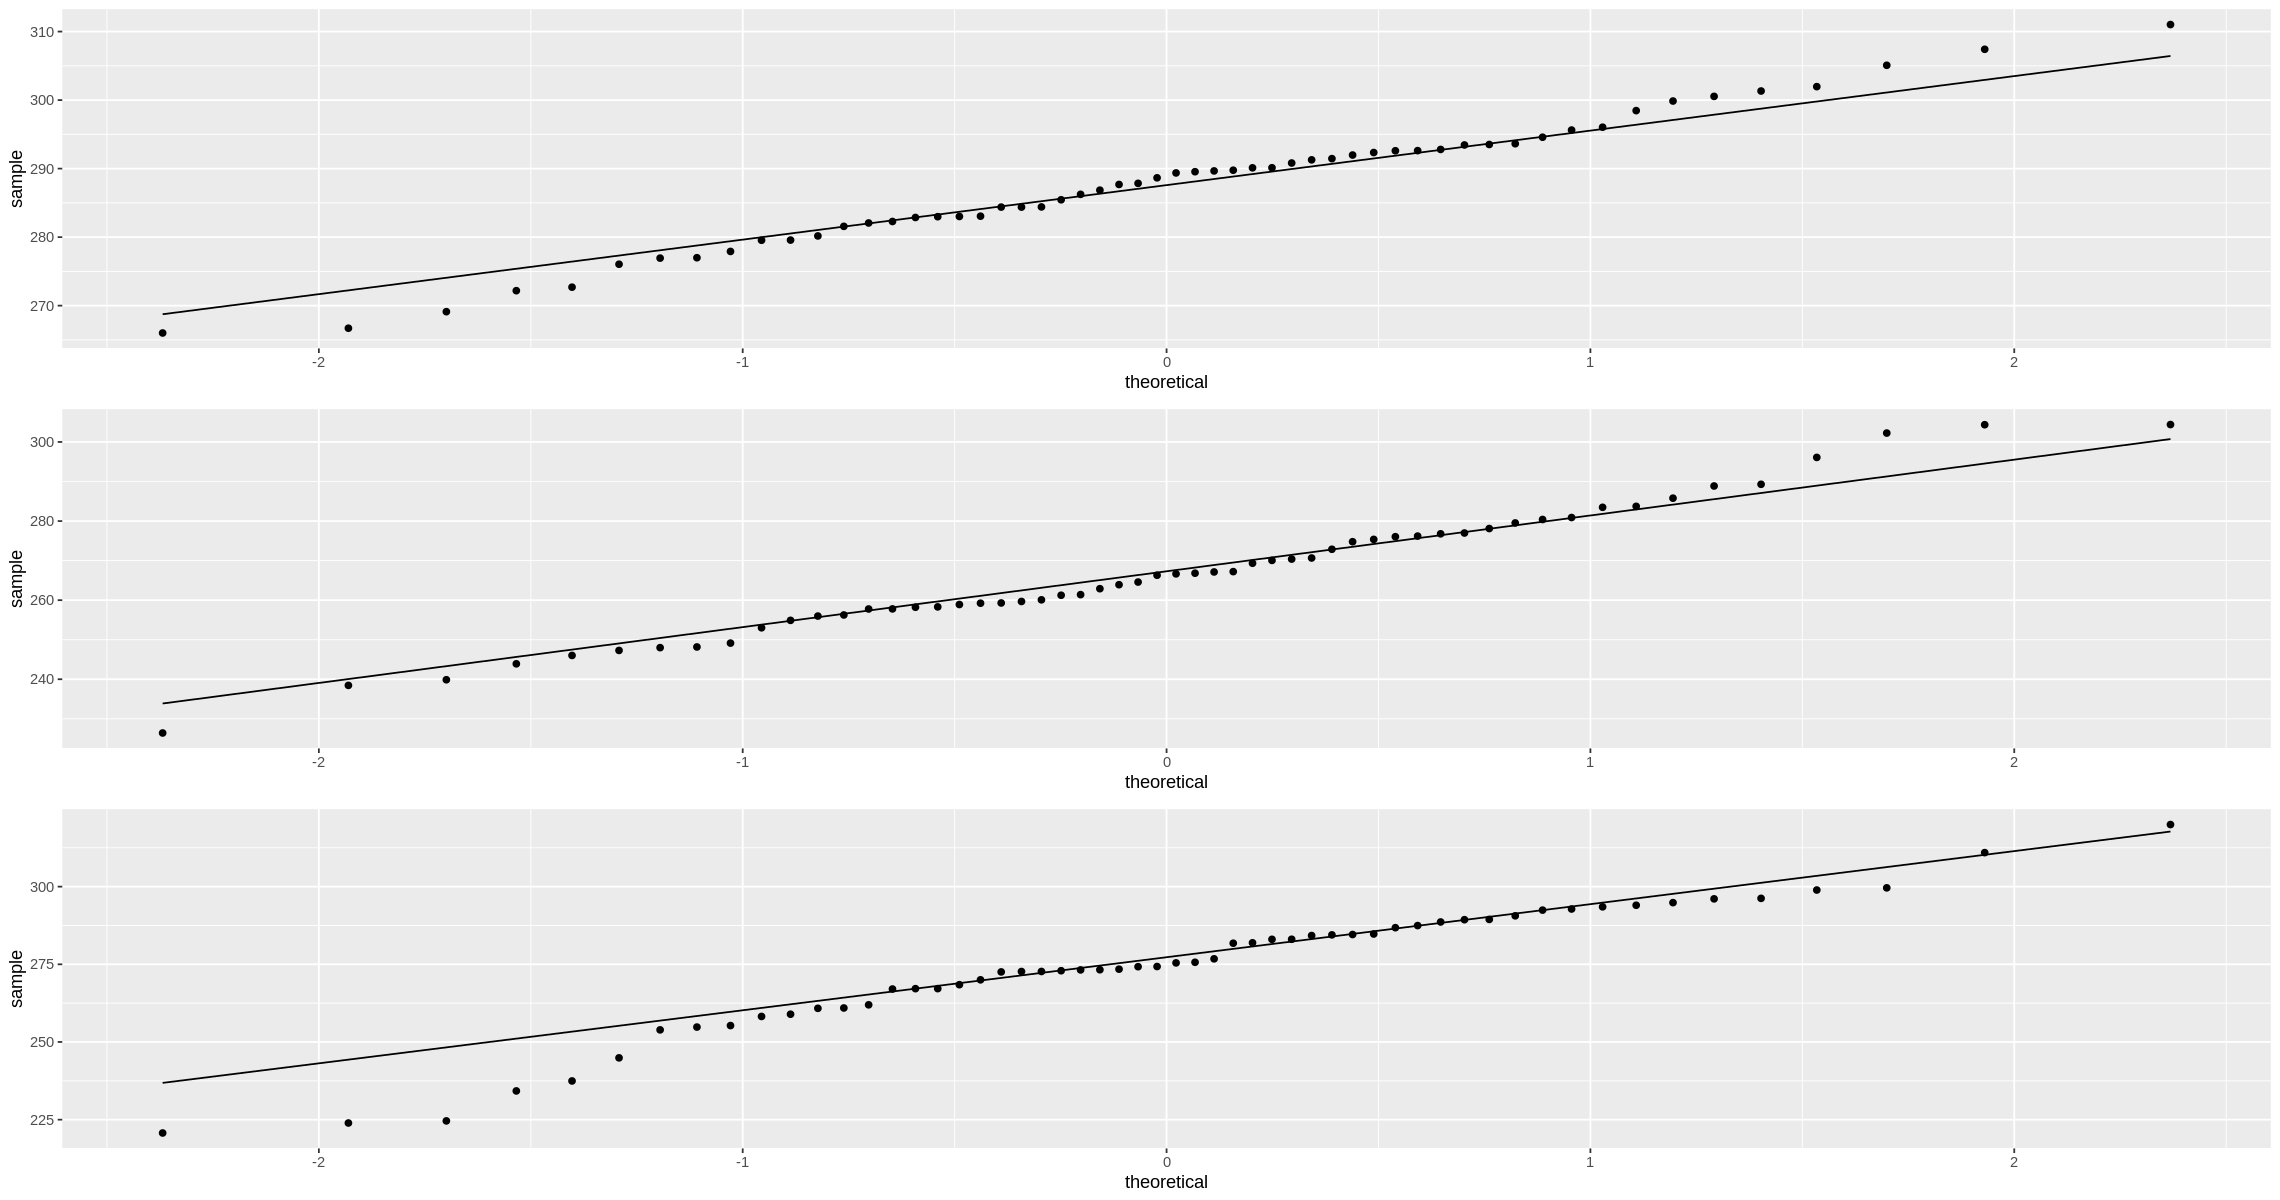

In [104]:
# 96 CORE 
grid.arrange(p_qq_96cr_si[[1]],p_qq_96cr_si[[2]], p_qq_96cr_si[[3]], nrow = 3)
#save_gg(p_qq_96cr_si, 1, "grid_qq_96cr_si")

Saving 350 x 169 mm image



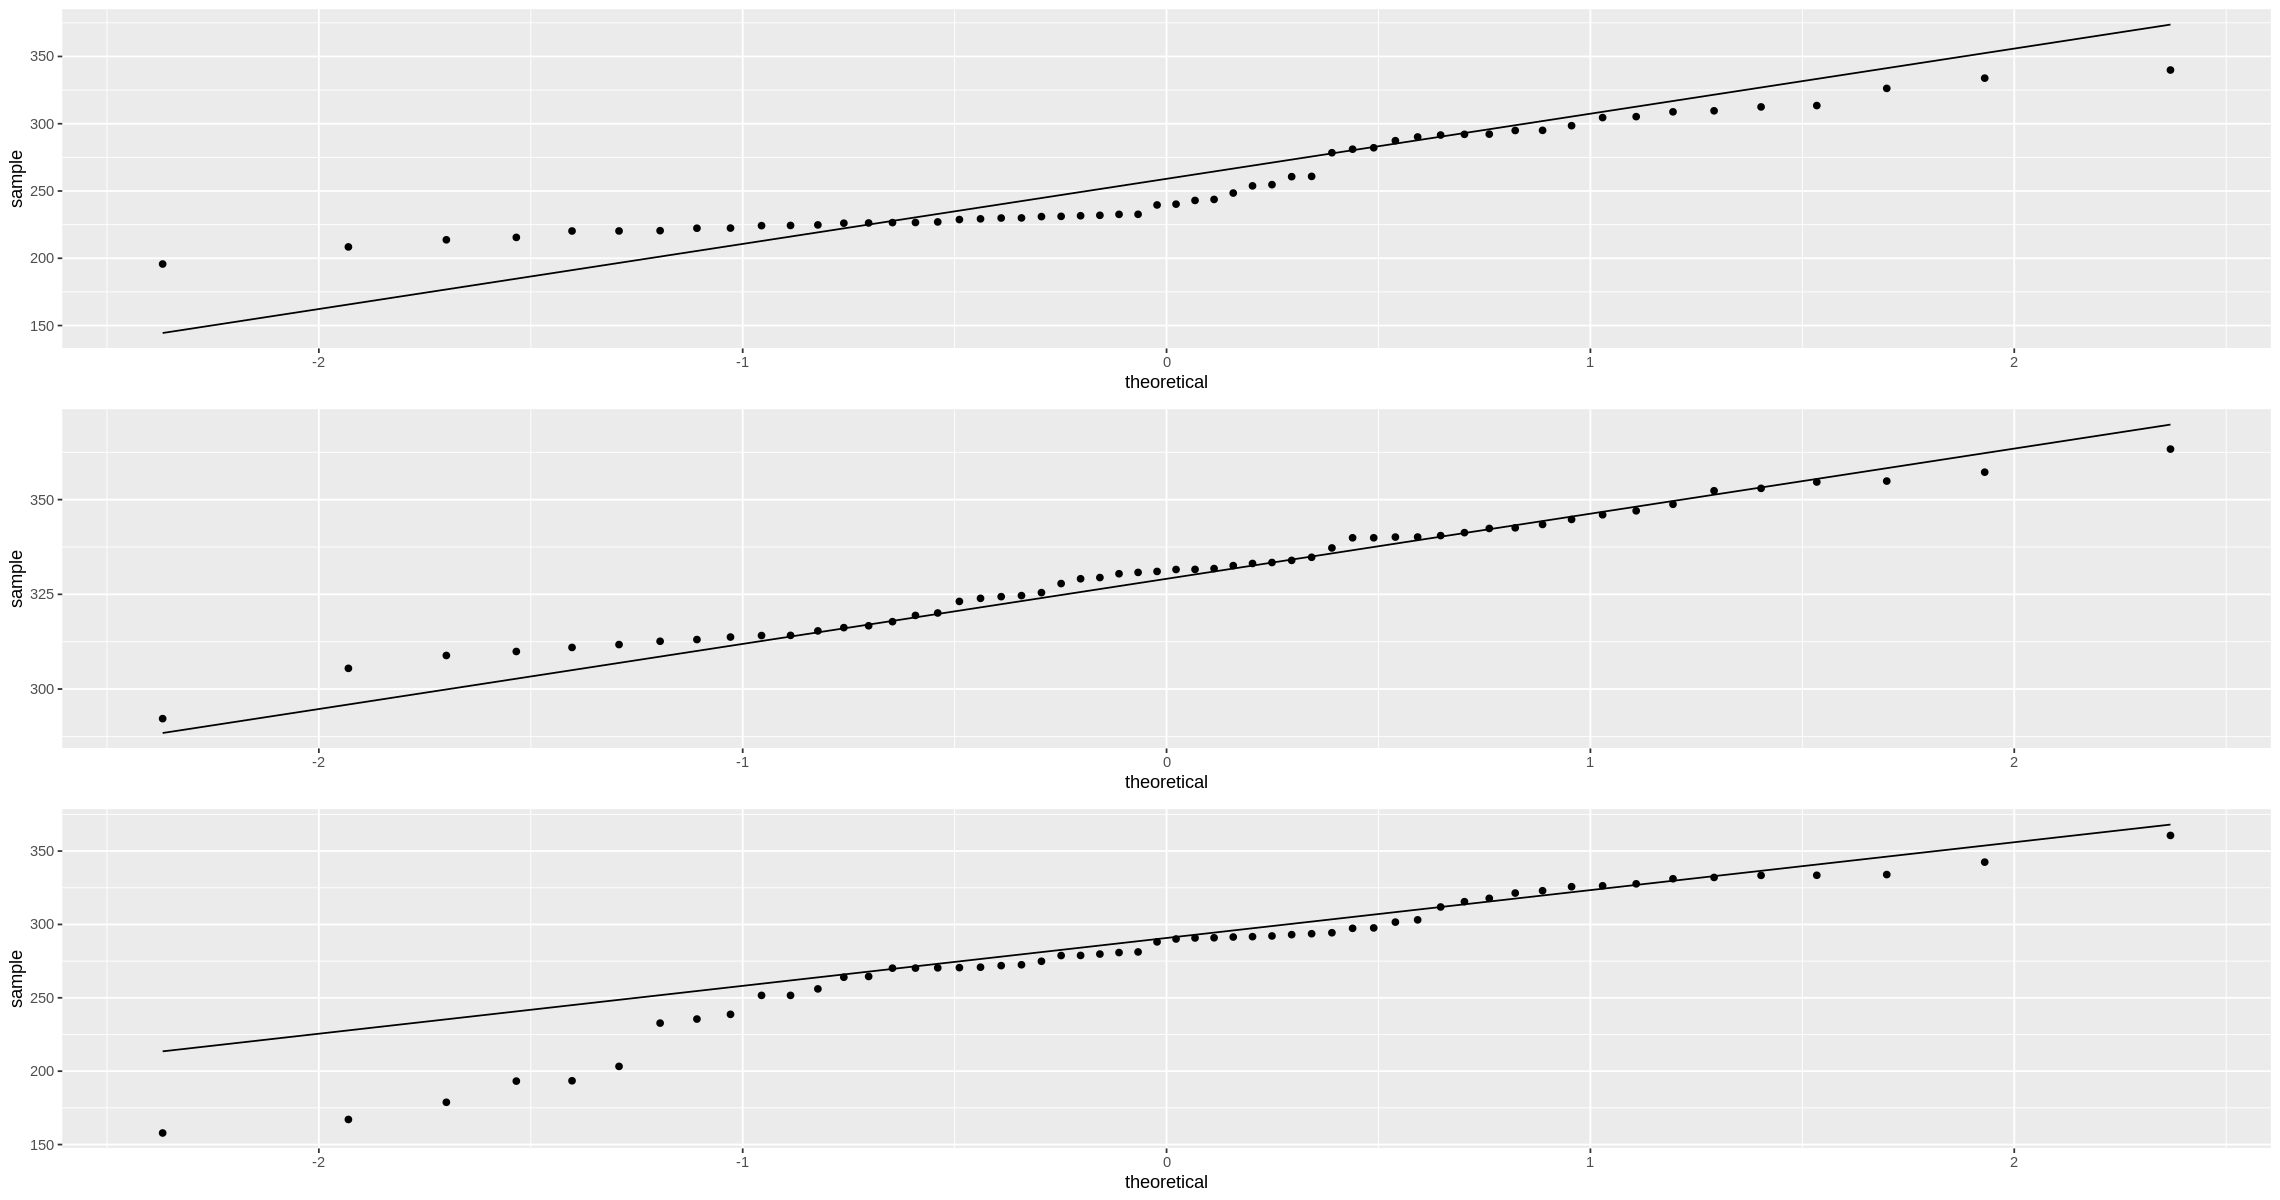

In [105]:
# 8 channel
grid.arrange(p_qq_8chl_si[[1]],p_qq_8chl_si[[2]], p_qq_8chl_si[[3]], nrow = 3)
save_gg(p_qq_8chl_si, 1, "grid_qq_8chl_si")

Saving 350 x 169 mm image



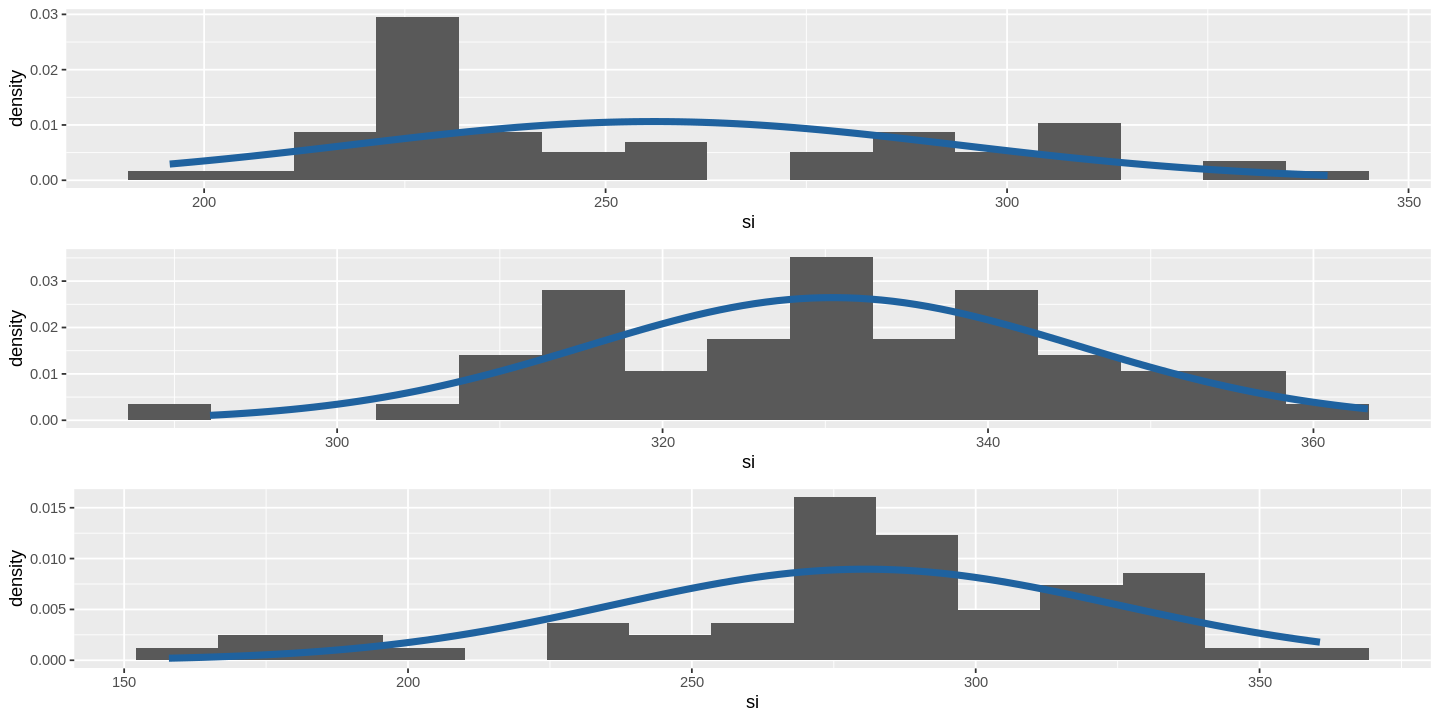

In [114]:
# 8 channel
grid.arrange(p_hst_8chl_si[[1]], p_hst_8chl_si[[2]], p_hst_8chl_si[[3]], nrow = 3)
save_gg(p_hst_8chl_si, 1, "grid_hst_8chl_si")

Saving 350 x 169 mm image



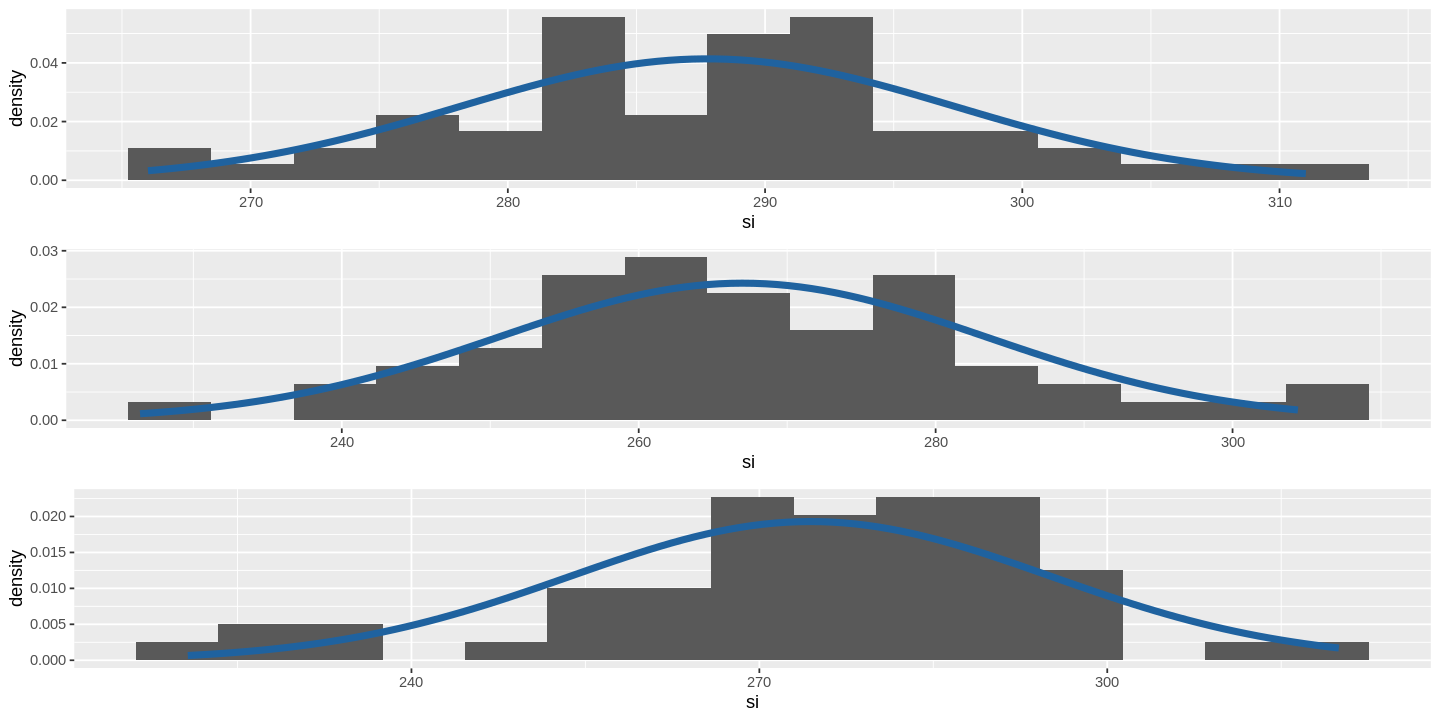

In [115]:
# 96 CORE
grid.arrange(p_hst_96cr_si[[1]], p_hst_96cr_si[[2]], p_hst_96cr_si[[3]], nrow = 3)
save_gg(p_hst_96cr_si, 1, "grid_hst_96cr_si")

#### Violin plots

In [18]:
# It is similar to a box plot, with the addition of a rotated kernel density plot on each side
df_violin_8chl_cmb <- rbind(df_violin_8chl_si[[1]], df_violin_8chl_si[[2]], df_violin_8chl_si[[3]])
df_violin_96cr_cmb <- rbind(df_violin_96cr_si[[1]], df_violin_96cr_si[[2]], df_violin_96cr_si[[3]])

ERROR: Error in rbind(df_violin_8chl_si[[1]], df_violin_8chl_si[[2]], df_violin_8chl_si[[3]]): object 'df_violin_8chl_si' not found


Saving 350 x 169 mm image



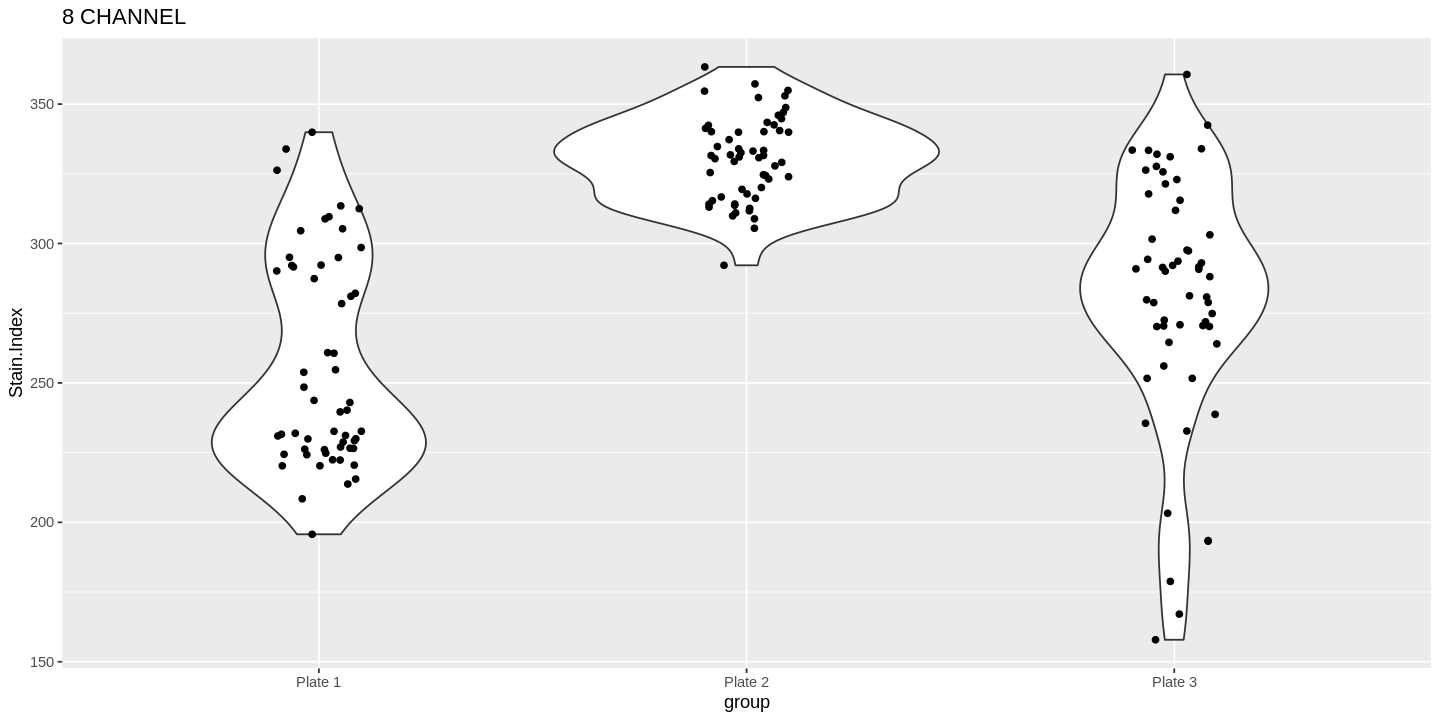

In [117]:
# 3 plates per set
pp<- ggplot(df_violin_8chl_cmb, aes(group, Stain.Index)) + 
    geom_violin() + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8 CHANNEL")

ggsave(filename = "violin_3set_8chl_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



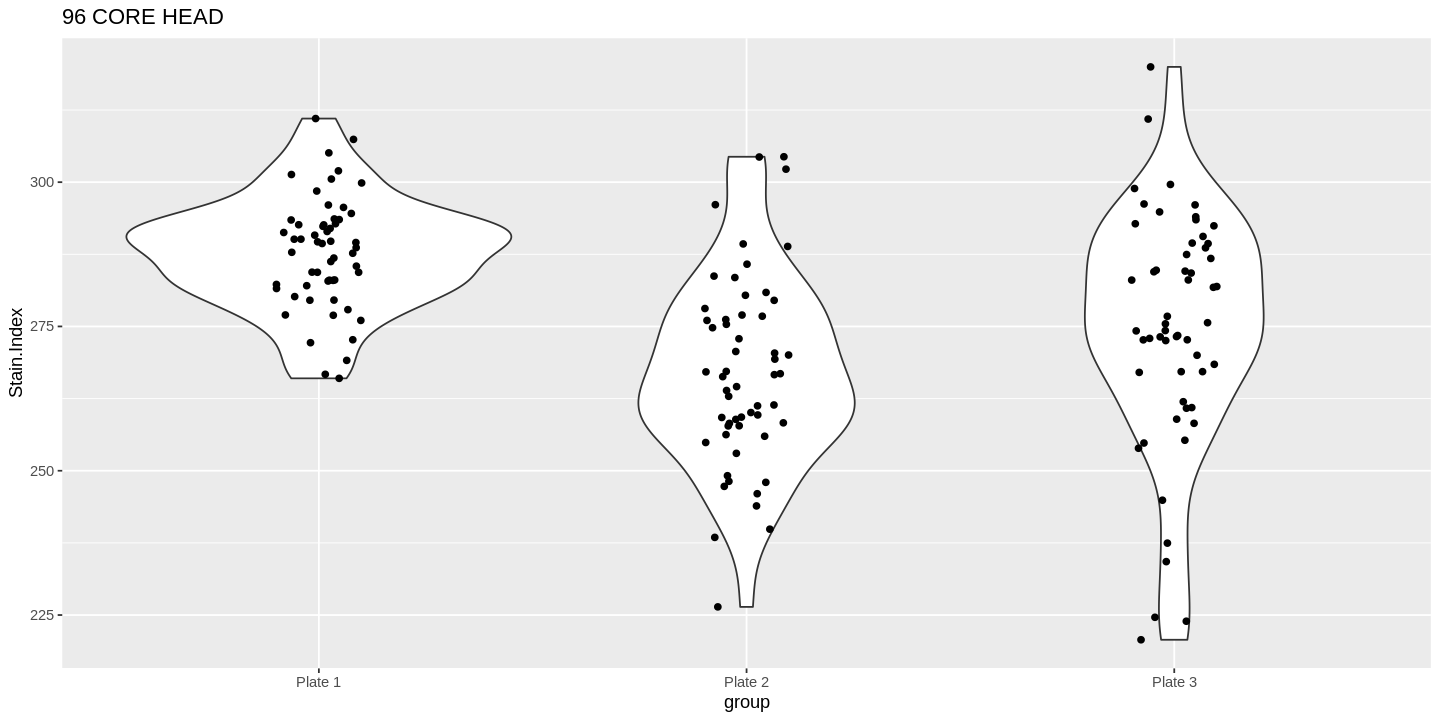

In [118]:
# 3 plates per set
pp<-ggplot(df_violin_96cr_cmb, aes(group, Stain.Index)) + 
    geom_violin() + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("96 CORE HEAD")
ggsave(filename = "violin_3set_96cr_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



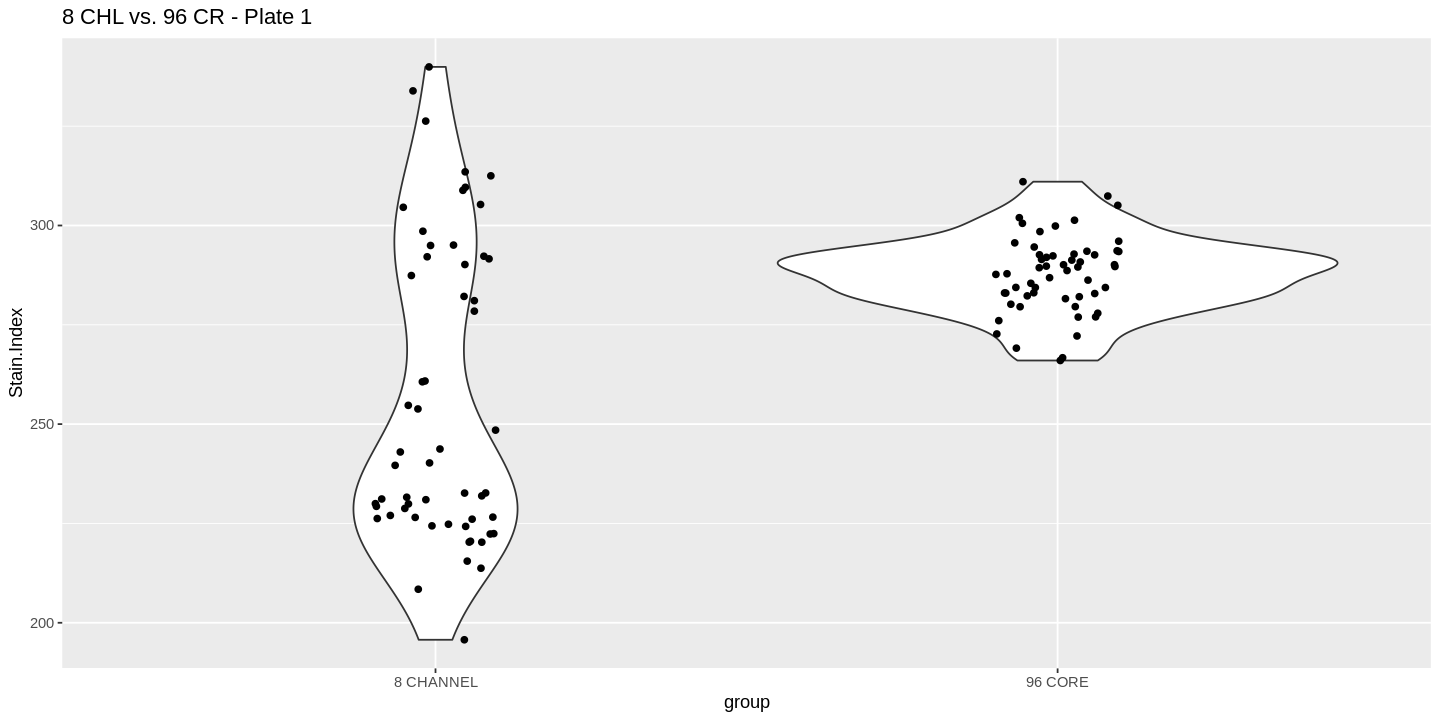

In [119]:
# comparing plate 1 of both methods
df1 <- df_violin_8chl_si[[1]] %>% mutate(group = "8 CHANNEL")
df2 <- df_violin_96cr_si[[1]] %>% mutate(group = "96 CORE")
dff <- bind_rows(df1, df2)
pp<-ggplot(dff, aes(group, Stain.Index)) + 
    geom_violin() + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8 CHL vs. 96 CR - Plate 1")
ggsave(filename = "violin_plt1_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



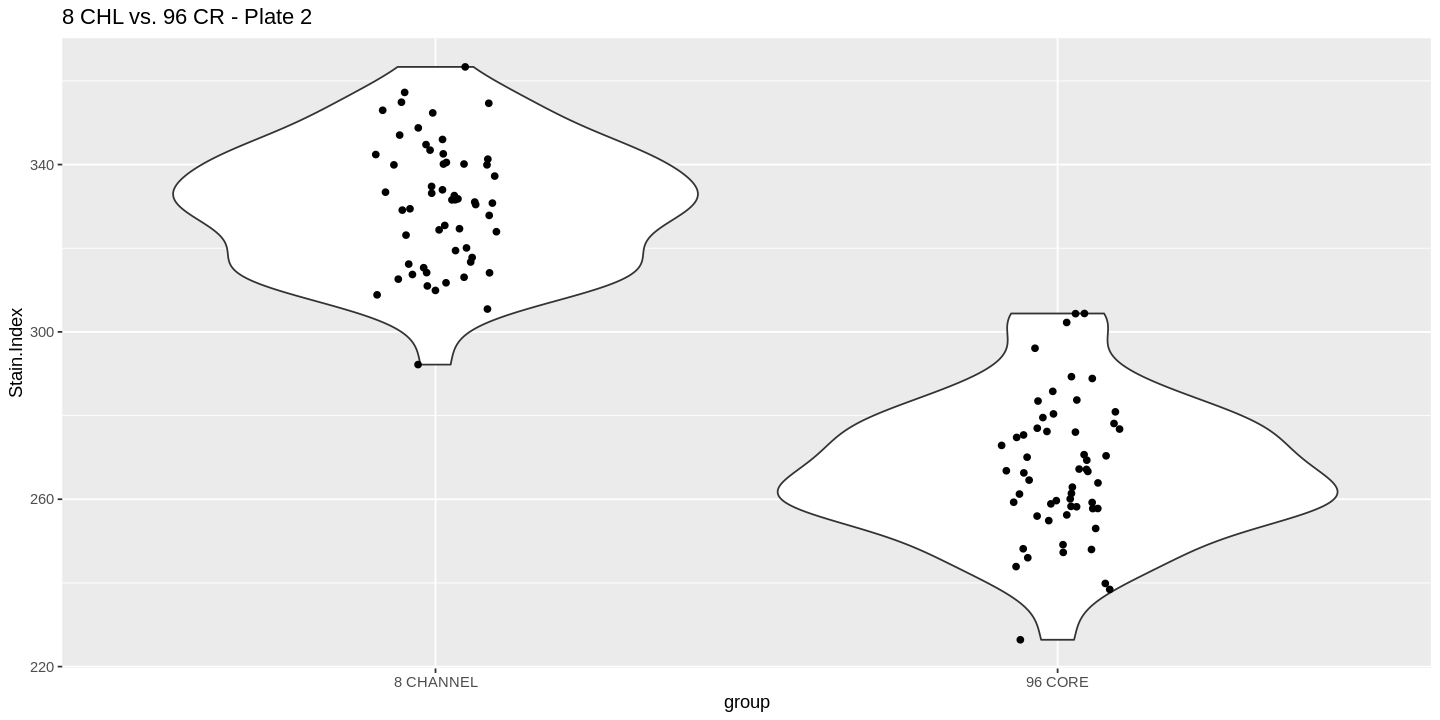

In [120]:
df1 <- df_violin_8chl_si[[2]] %>% mutate(group = "8 CHANNEL")
df2 <- df_violin_96cr_si[[2]] %>% mutate(group = "96 CORE")
dff <- bind_rows(df1, df2)

pp<-ggplot(dff, aes(group, Stain.Index)) + 
    geom_violin() + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8 CHL vs. 96 CR - Plate 2")
ggsave(filename = "violin_plt2_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



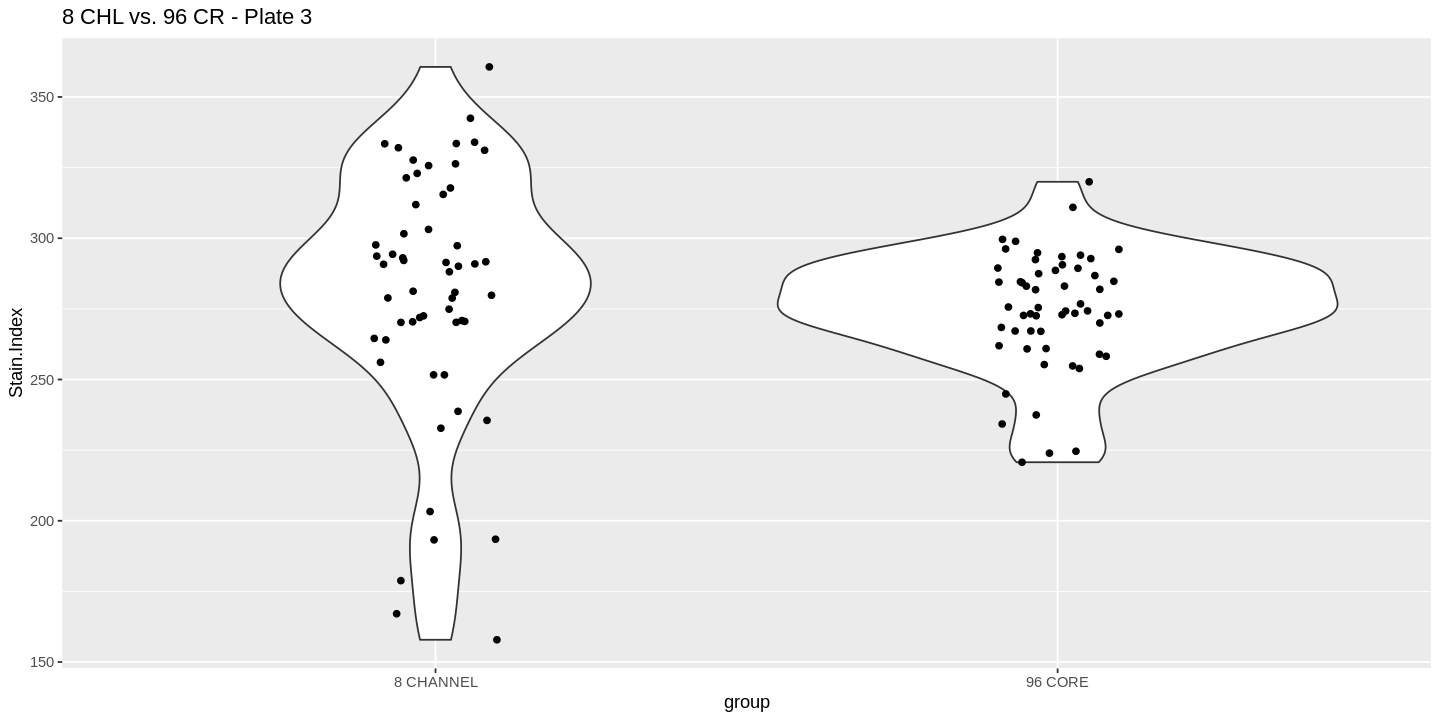

In [121]:
df1 <- df_violin_8chl_si[[3]] %>% mutate(group = "8 CHANNEL")
df2 <- df_violin_96cr_si[[3]] %>% mutate(group = "96 CORE")
dff <- bind_rows(df1, df2)

pp<-ggplot(dff, aes(group, Stain.Index)) + 
    geom_violin() + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8 CHL vs. 96 CR - Plate 3")
ggsave(filename = "violin_plt3_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

### Box plots and t-test 

In [7]:
df.8chl.si.cmb <- rbind(si.pos.8chl[[1]], si.pos.8chl[[2]], si.pos.8chl[[3]])

In [20]:
summary(df.8chl.si.cmb)

      si.           group          
 Min.   :157.9   Length:168        
 1st Qu.:251.6   Class :character  
 Median :296.2   Mode  :character  
 Mean   :289.0                     
 3rd Qu.:328.2                     
 Max.   :363.3                     

In [23]:
sd(df.8chl.si.cmb$si.)

[1] 46.45589

In [8]:
df.96cr.si.cmb <- rbind(si.pos.96cr[[1]], si.pos.96cr[[2]], si.pos.96cr[[3]])

In [51]:
summary(df.96cr.si.cmb)

      si.           group          
 Min.   :220.7   Length:168        
 1st Qu.:266.2   Class :character  
 Median :278.8   Mode  :character  
 Mean   :276.4                     
 3rd Qu.:289.6                     
 Max.   :320.0                     

In [119]:
pair_test(df.8chl.si.cmb$si., df.96cr.si.cmb$si.)


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 17965, p-value = 1.51e-05
alternative hypothesis: true location shift is not equal to 0


	Welch Two Sample t-test

data:  x and y
t = 3.2782, df = 217.59, p-value = 0.001216
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  5.035831 20.220238
sample estimates:
mean of x mean of y 
 289.0149  276.3869 



In [123]:
mean(seq(10))

[1] 5.5

In [127]:
for (i in seq(3)) {
    print(mean(si.pos.96cr[[i]]$si.))
    print(mean(si.pos.8chl[[i]]$si.))
    print(sd(si.pos.96cr[[i]]$si.))
    print(sd(si.pos.8chl[[i]]$si.))
    print("_______")
}

[1] 287.7611
[1] 256.0236
[1] 9.642106
[1] 37.58899
[1] "_______"
[1] 266.9887
[1] 330.4477
[1] 16.43965
[1] 15.0885
[1] "_______"
[1] 274.4108
[1] 280.5736
[1] 20.67715
[1] 44.53847
[1] "_______"


In [48]:
df.t

si.      group   method
1   287.6839 Plate 1 96CR  
2   291.2778 Plate 1 96CR  
3   282.9836 Plate 1 96CR  
4   292.6022 Plate 1 96CR  
5   290.1227 Plate 1 96CR  
6   293.5202 Plate 1 96CR  
7   289.6644 Plate 1 96CR  
8   269.1216 Plate 1 96CR  
9   283.0569 Plate 1 96CR  
10  280.1738 Plate 1 96CR  
11  286.8545 Plate 1 96CR  
12  292.7961 Plate 1 96CR  
13  276.9367 Plate 1 96CR  
14  281.5724 Plate 1 96CR  
15  286.2442 Plate 1 96CR  
16  294.5785 Plate 1 96CR  
17  296.0410 Plate 1 96CR  
18  298.4621 Plate 1 96CR  
19  284.3821 Plate 1 96CR  
20  276.9926 Plate 1 96CR  
21  291.9802 Plate 1 96CR  
22  290.1145 Plate 1 96CR  
23  288.6540 Plate 1 96CR  
24  266.0105 Plate 1 96CR  
25  279.5687 Plate 1 96CR  
26  292.3455 Plate 1 96CR  
27  295.6268 Plate 1 96CR  
28  282.2823 Plate 1 96CR  
29  266.7086 Plate 1 96CR  
30  293.4486 Plate 1 96CR  
⋮   ⋮        ⋮       ⋮     
307 297.3532 Plate 3 8CHL  
308 331.1204 Plate 3 8CHL  
309 235.5298 Plate 3 8CHL  
310 279.8090 Plate 3 8CHL  
311 256.0755 Plate 3 8CHL  
312 326.3350 Plate 3 8CHL  
313 360.6391 Plate 3 8CHL  
314 332.0298 Plate 3 8CHL  
315 322.9432 Plate 3 8CHL  
316 291.4280 Plate 3 8CHL  
317 281.2451 Plate 3 8CHL  
318 317.7861 Plate 3 8CHL  
319 251.6444 Plate 3 8CHL  
320 167.0911 Plate 3 8CHL  
321 333.5058 Plate 3 8CHL  
322 193.4648 Plate 3 8CHL  
323 271.9351 Plate 3 8CHL  
324 288.1165 Plate 3 8CHL  
325 270.2076 Plate 3 8CHL  
326 274.8854 Plate 3 8CHL  
327 264.0181 Plate 3 8CHL  
328 303.1218 Plate 3 8CHL  
329 270.2425 Plate 3 8CHL  
330 270.5629 Plate 3 8CHL  
331 327.6648 Plate 3 8CHL  
332 291.6681 Plate 3 8CHL  
333 315.5066 Plate 3 8CHL  
334 294.3285 Plate 3 8CHL  
335 203.2643 Plate 3 8CHL  
336 193.2335 Plate 3 8CHL

In [9]:
df.t <- rbind(df.96cr.si.cmb %>% mutate(method = "96CR"), df.8chl.si.cmb %>% mutate(method = "8CHL"))

In [ ]:
options(repr.plot.width=22, repr.plot.height=12)

In [10]:
head(df.t)

si.      group   method
1 287.6839 Plate 1 96CR  
2 291.2778 Plate 1 96CR  
3 282.9836 Plate 1 96CR  
4 292.6022 Plate 1 96CR  
5 290.1227 Plate 1 96CR  
6 293.5202 Plate 1 96CR

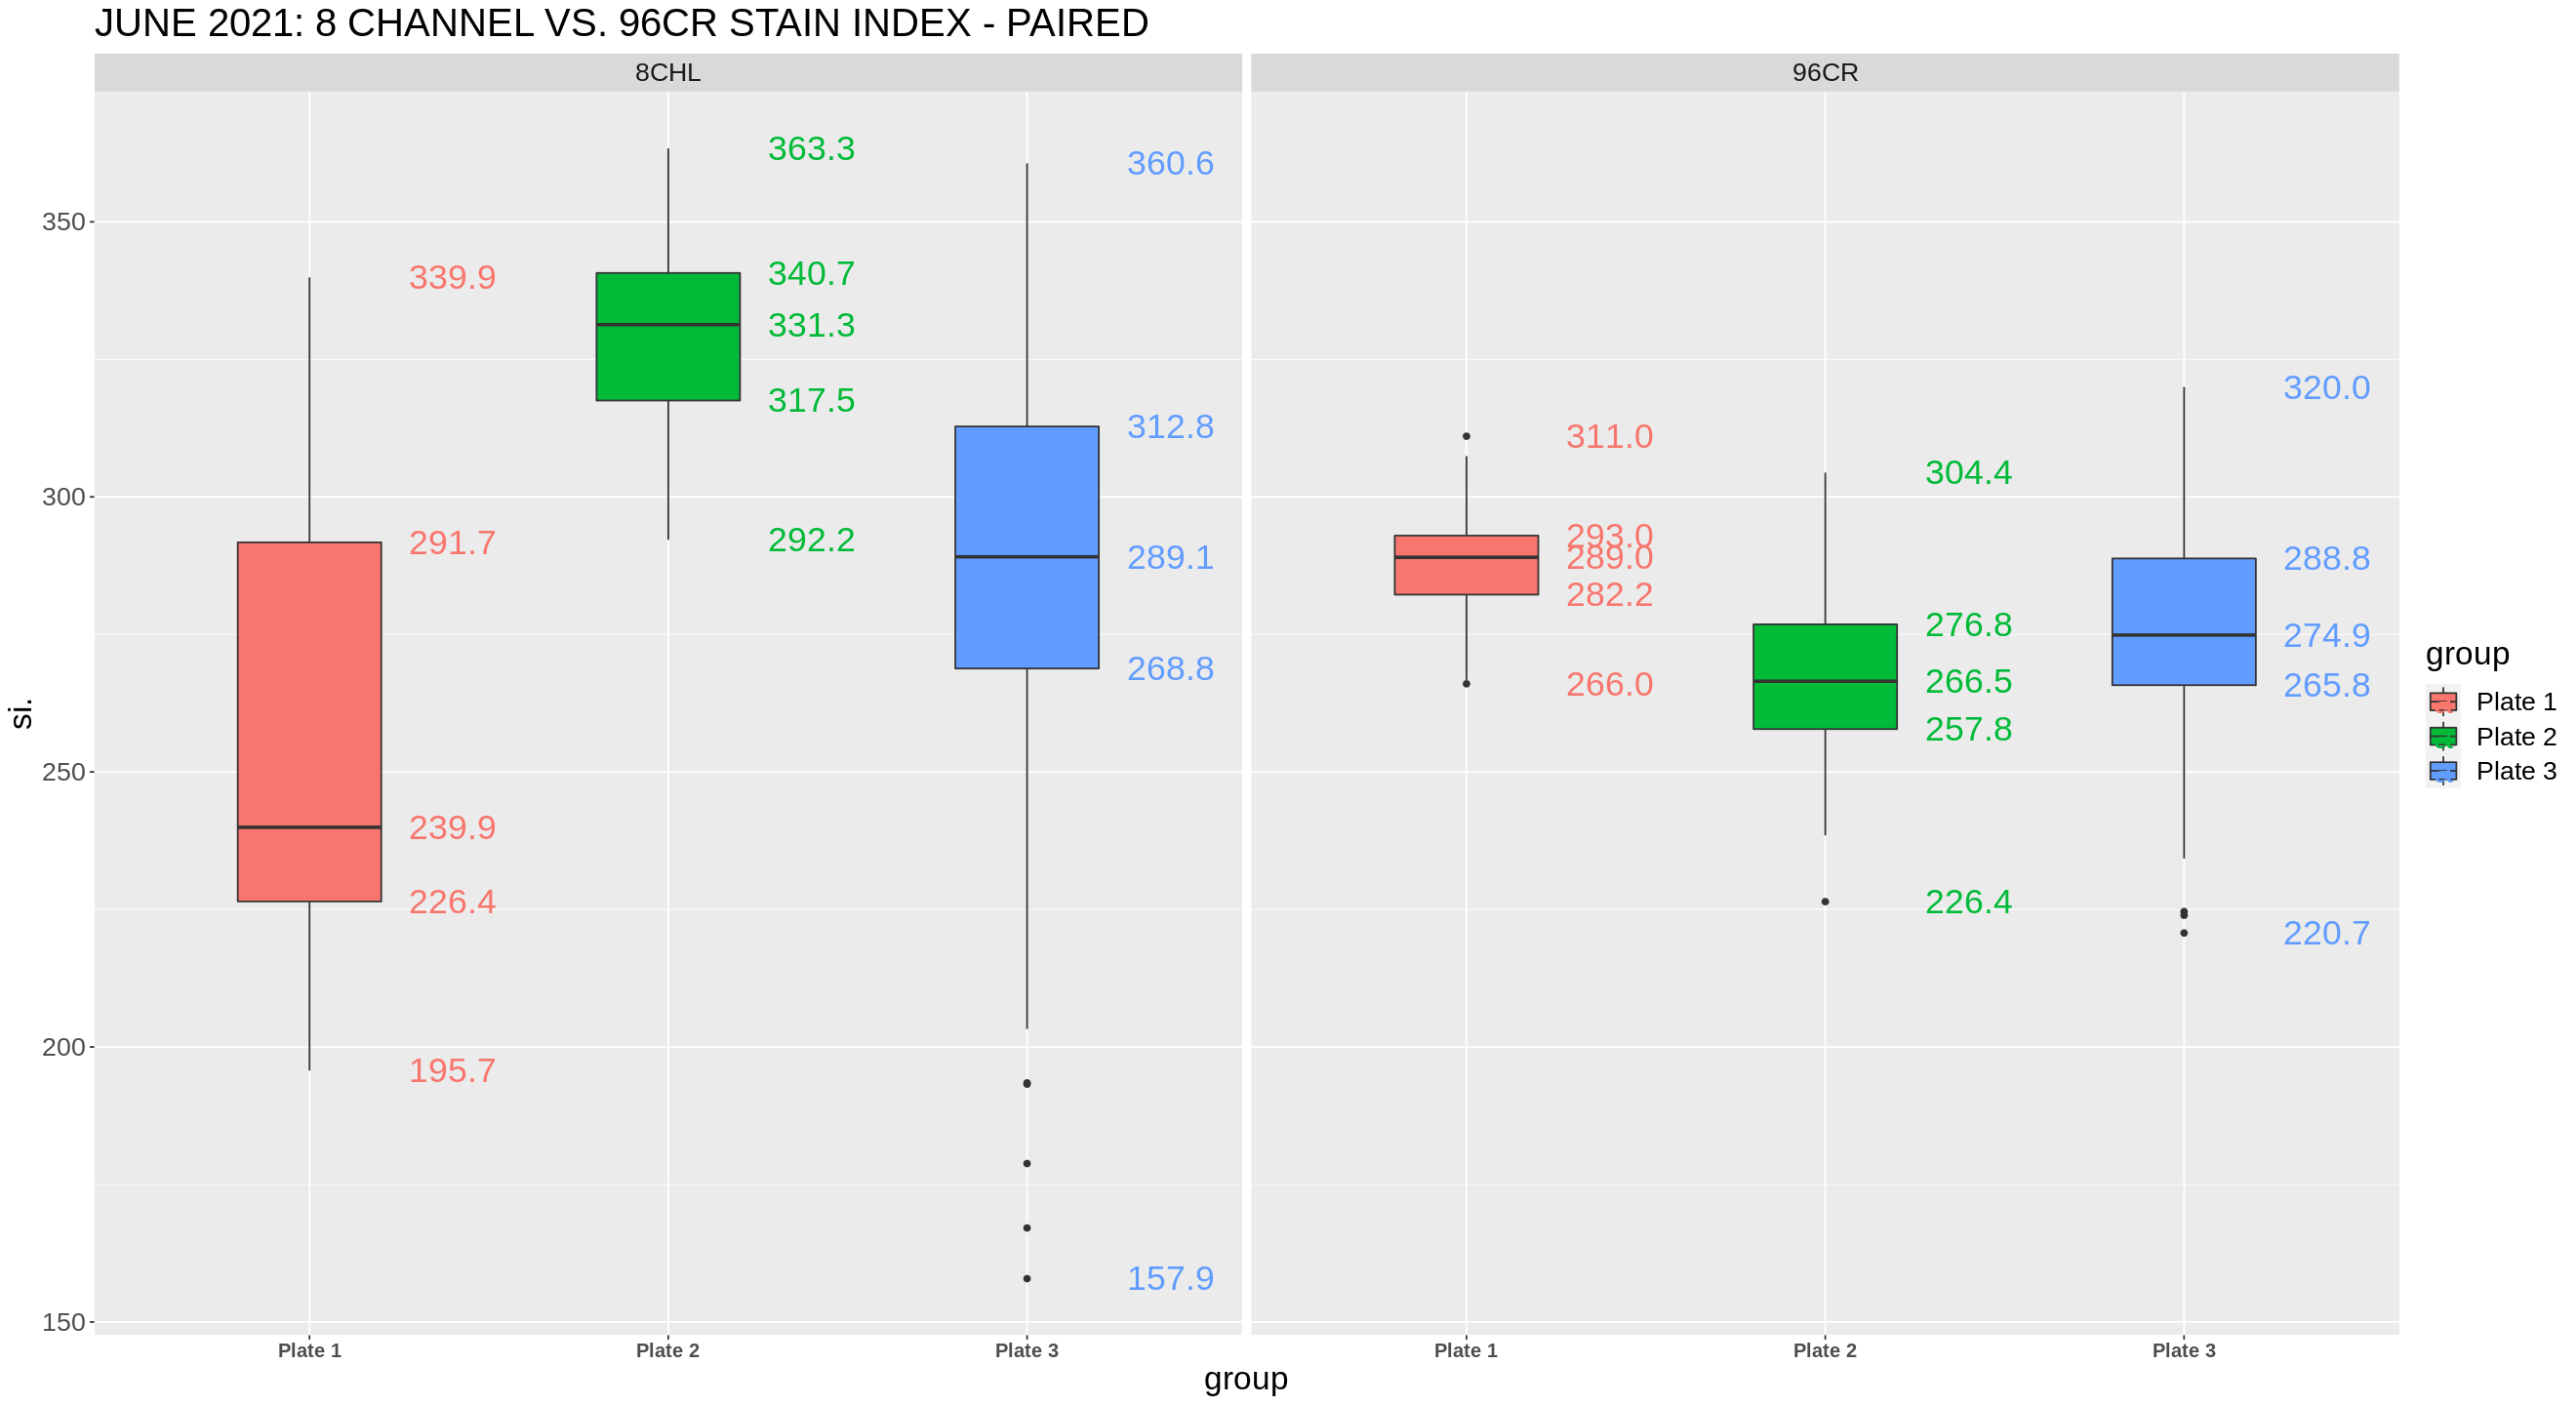

In [54]:
ggplot(df.t, aes(group, si.)) +
    geom_boxplot(width = 0.4, aes(group = group, fill = group)) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=group),
           position=position_nudge(x=0.4), size=7.5) +
    ggtitle("JUNE 2021: 8 CHANNEL VS. 96CR STAIN INDEX - PAIRED") + 
    facet_wrap(~method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

Saving 350 x 169 mm image



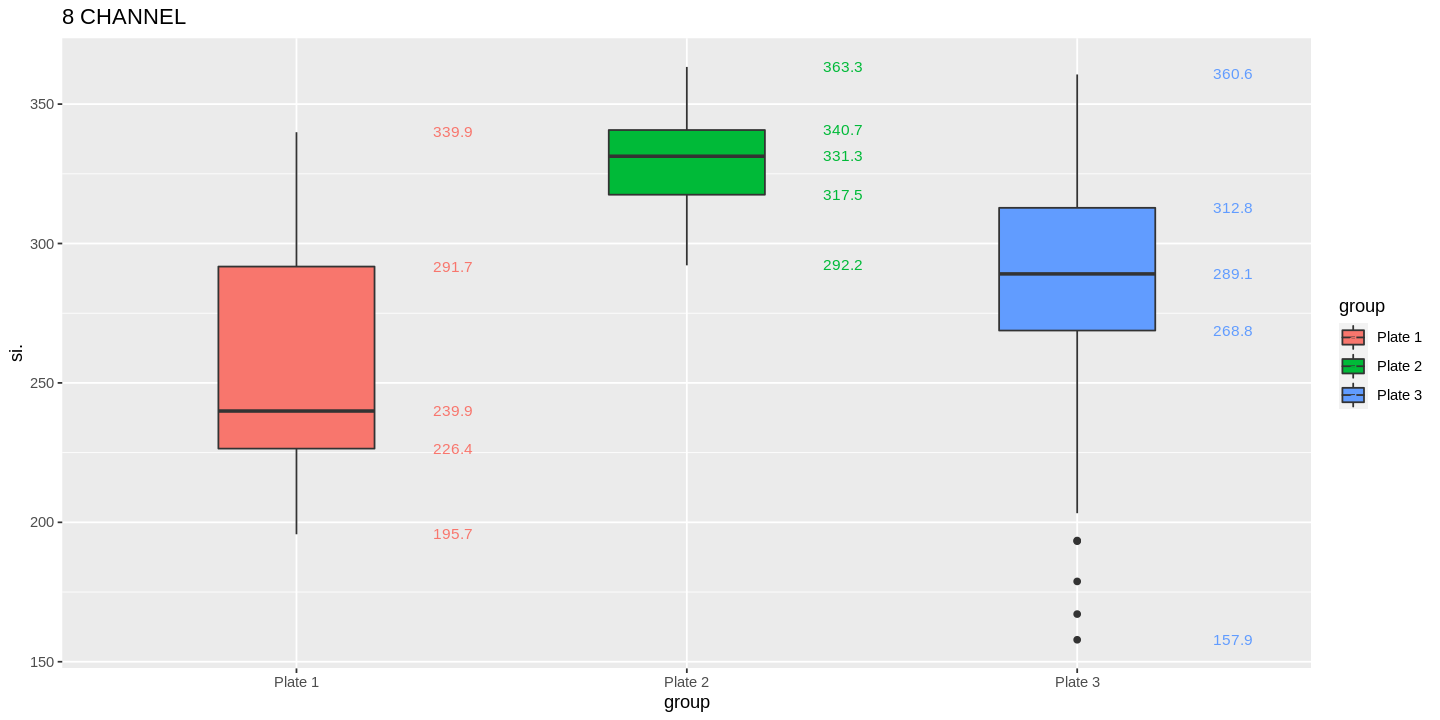

In [123]:
pp<- ggplot(df.8chl.si.cmb, aes(group, si.,fill=group)) +
    geom_boxplot(width = 0.4) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=group),
           position=position_nudge(x=0.4), size=3.25) +
    ggtitle("8 CHANNEL")
ggsave(filename = "boxplt_8chl_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

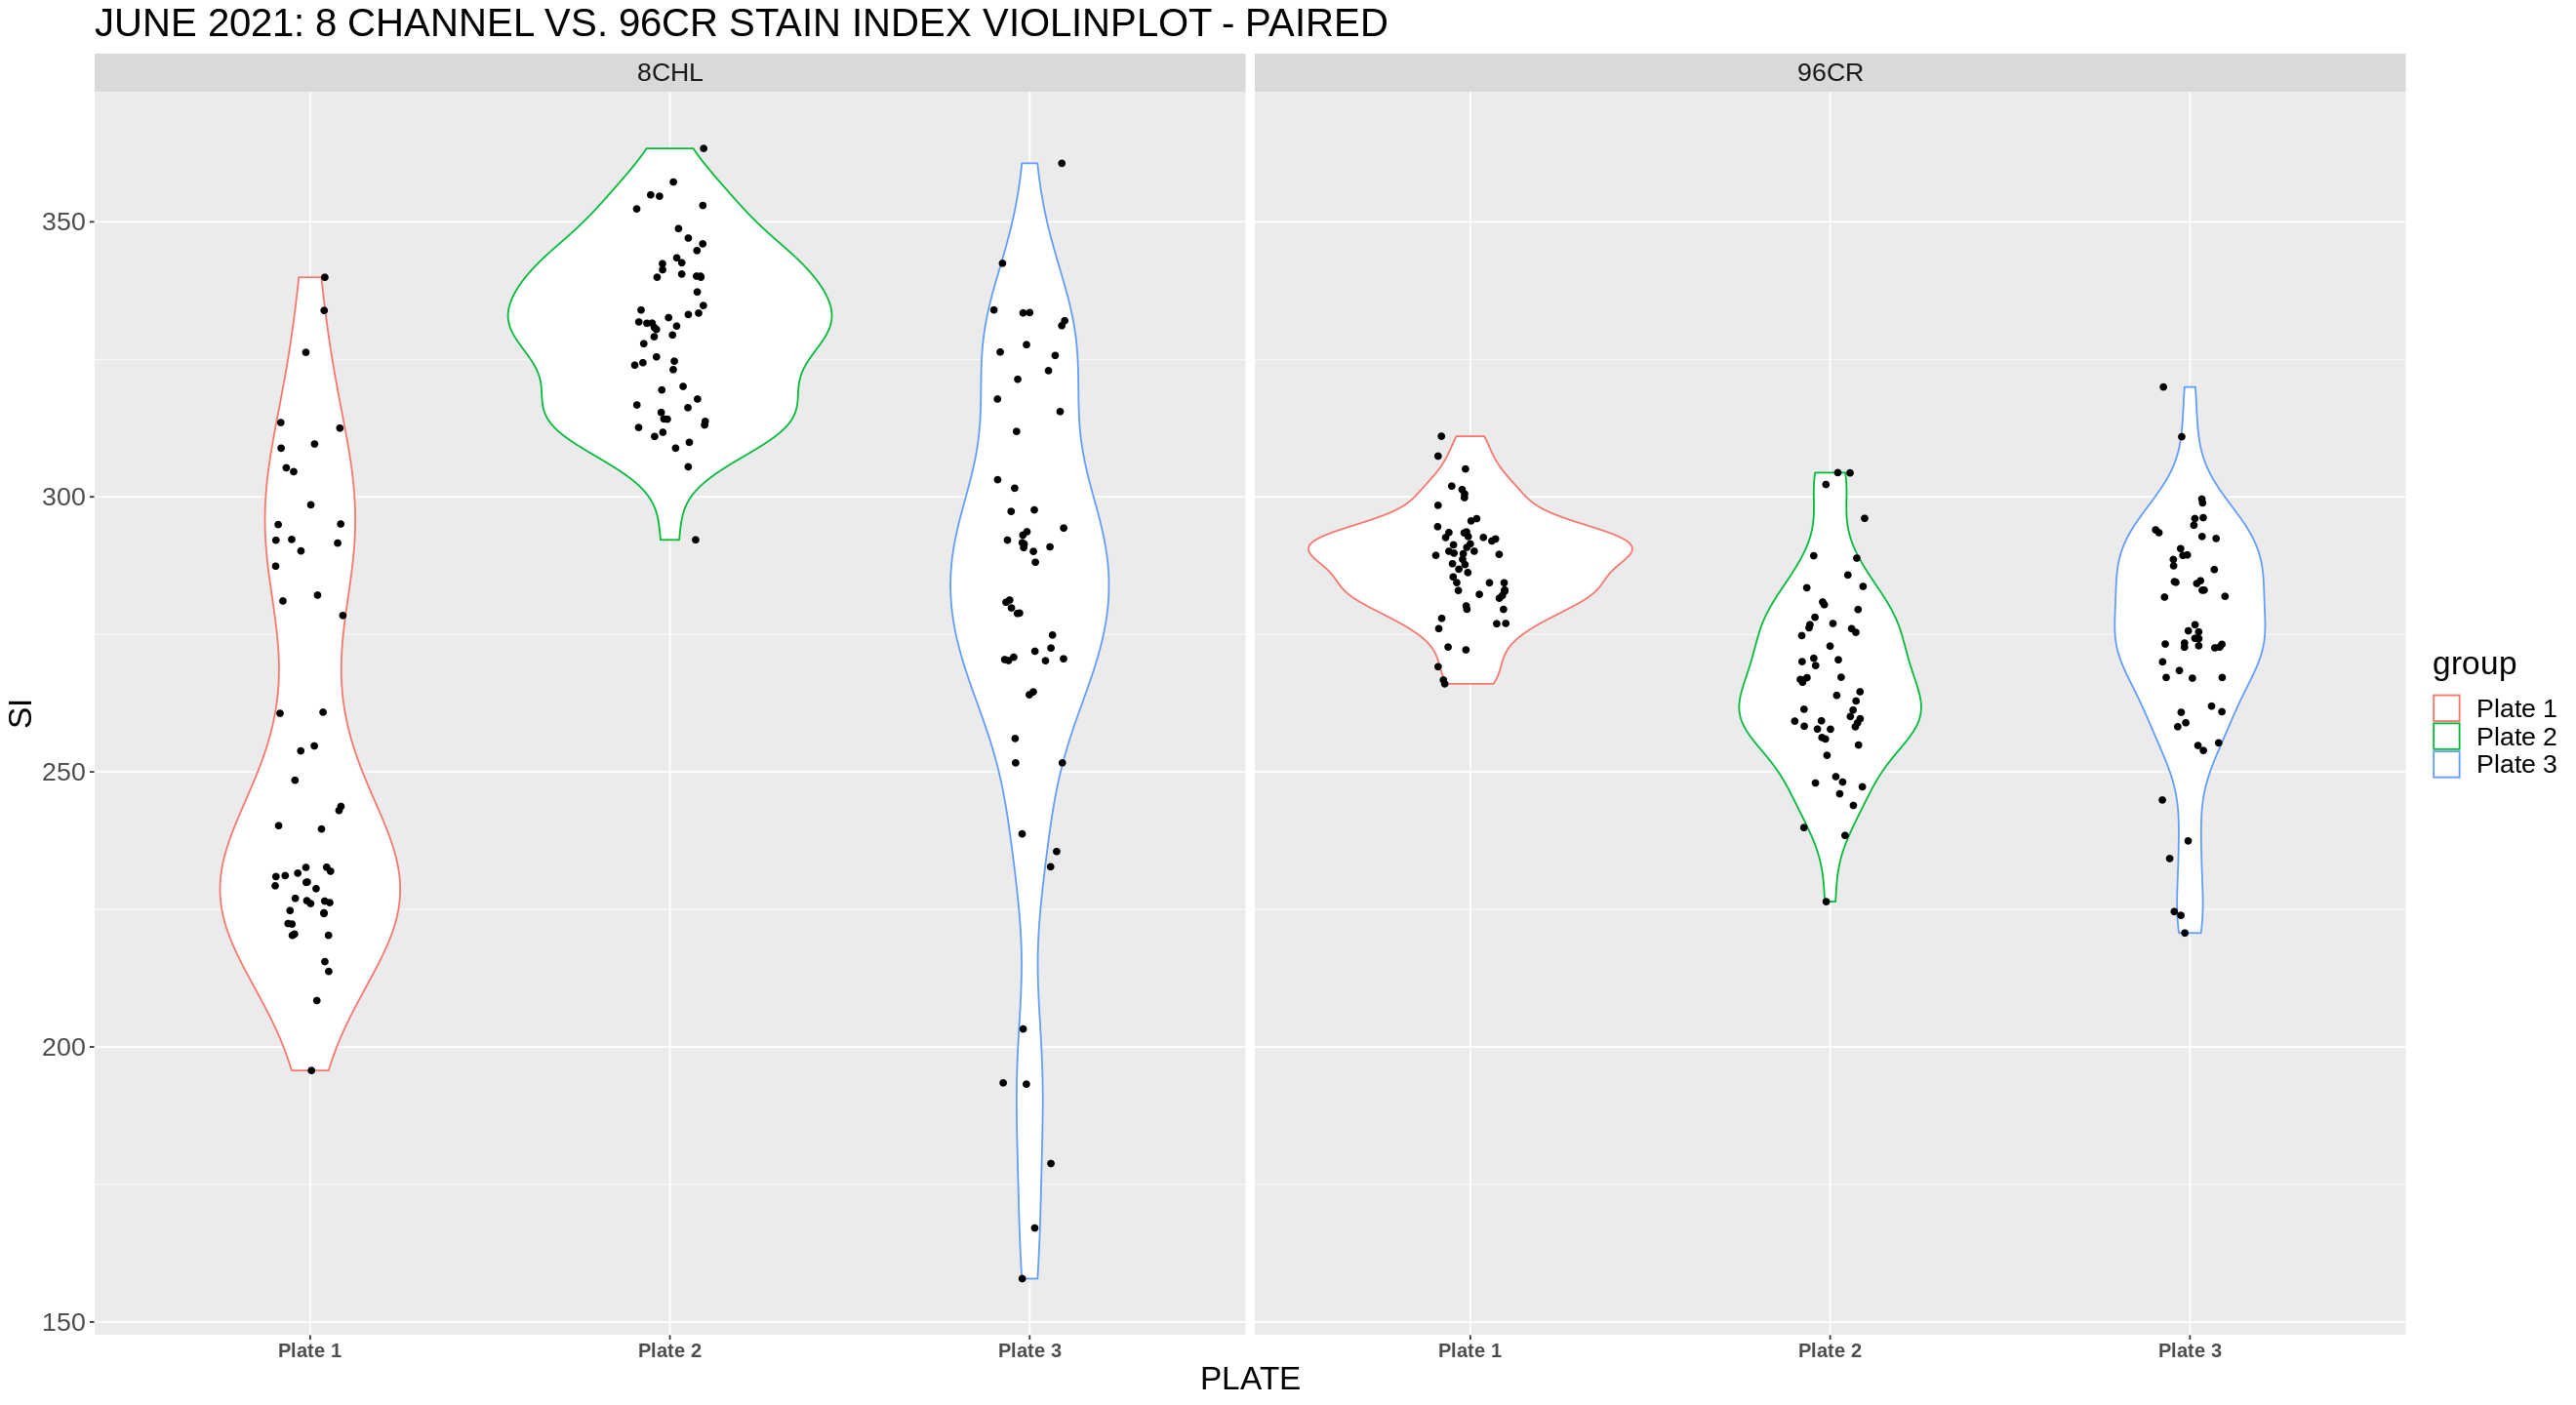

In [17]:
#violin plot paired
ggplot(df.t, aes(group, si.)) +
    geom_violin(aes(colour = group)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("JUNE 2021: 8 CHANNEL VS. 96CR STAIN INDEX VIOLINPLOT - PAIRED") + 
    ylab("SI") +
    xlab("PLATE") +
    facet_wrap(~method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

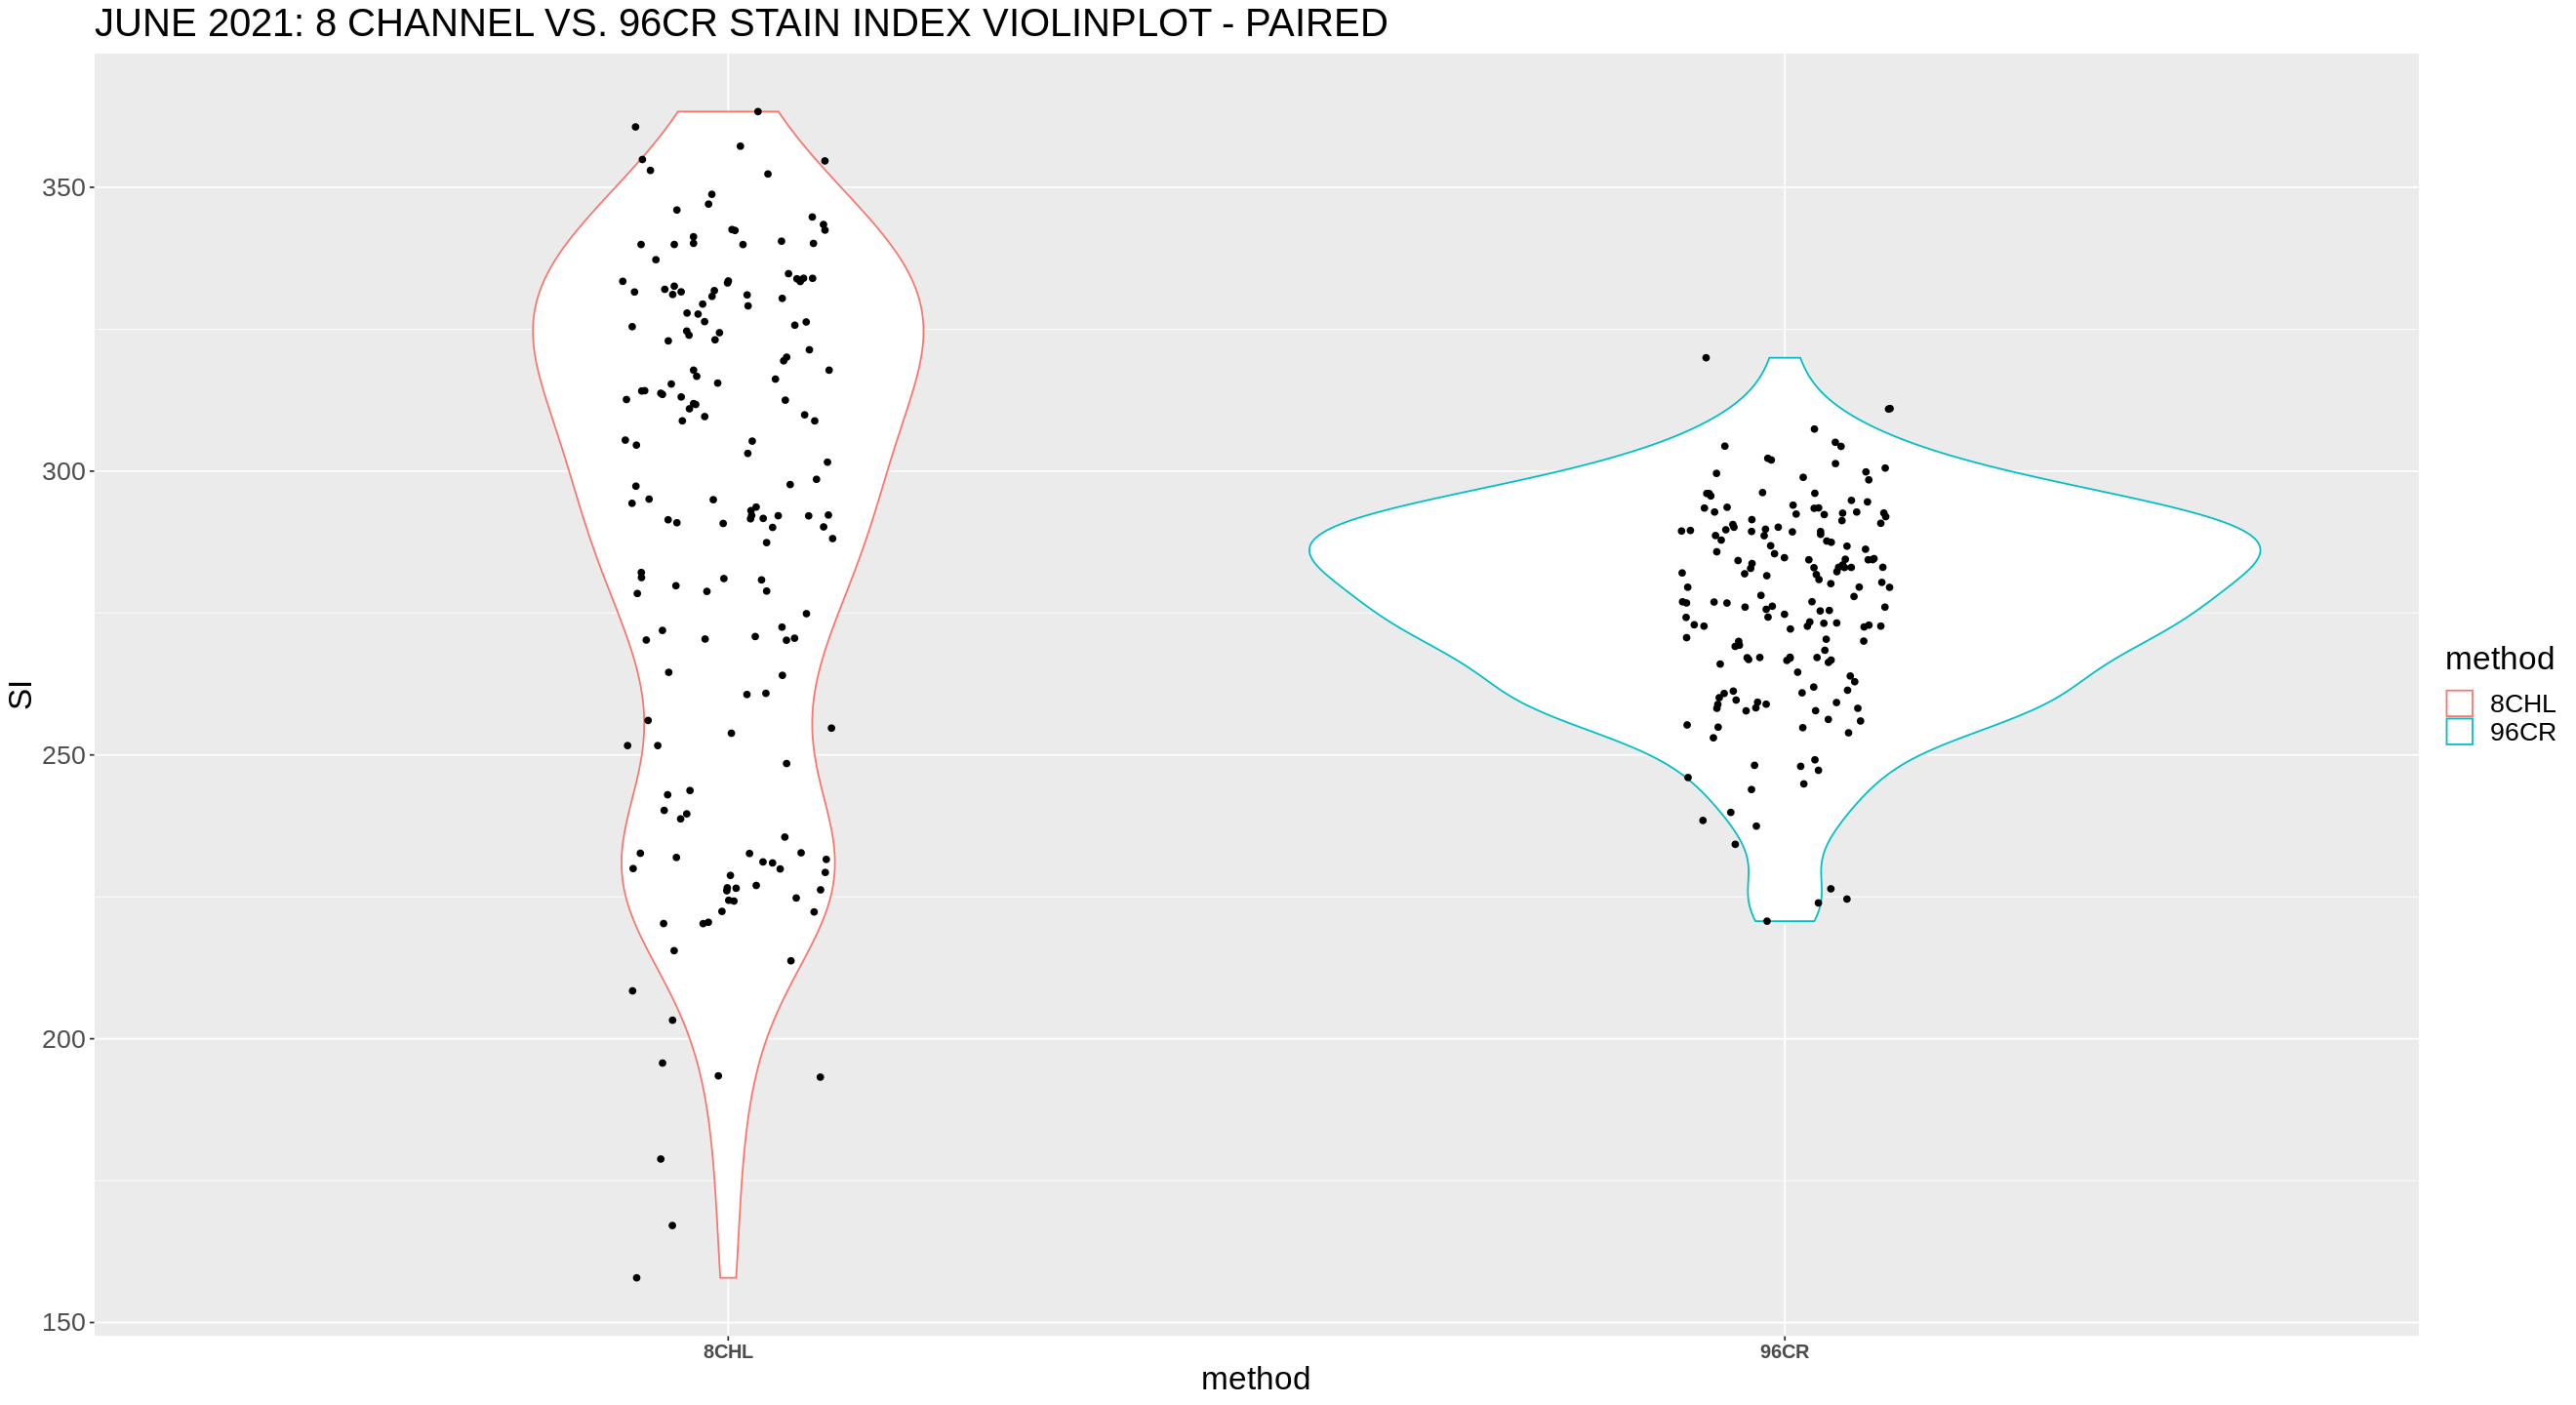

In [14]:
#violinplot pooled
ggplot(df.t, aes(method, si.)) +
    geom_violin(aes(colour = method)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("JUNE 2021: 8 CHANNEL VS. 96CR STAIN INDEX VIOLINPLOT - PAIRED") + 
    ylab("SI") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

Saving 350 x 169 mm image



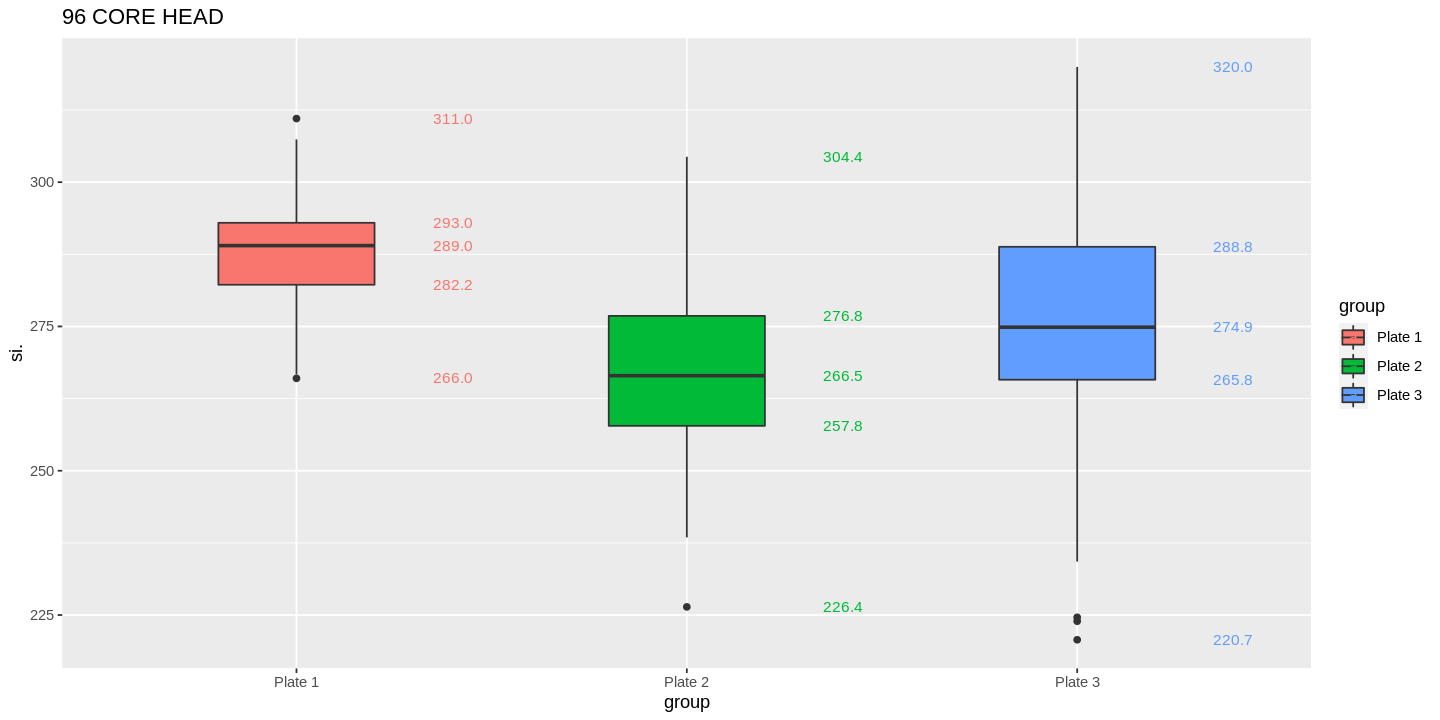

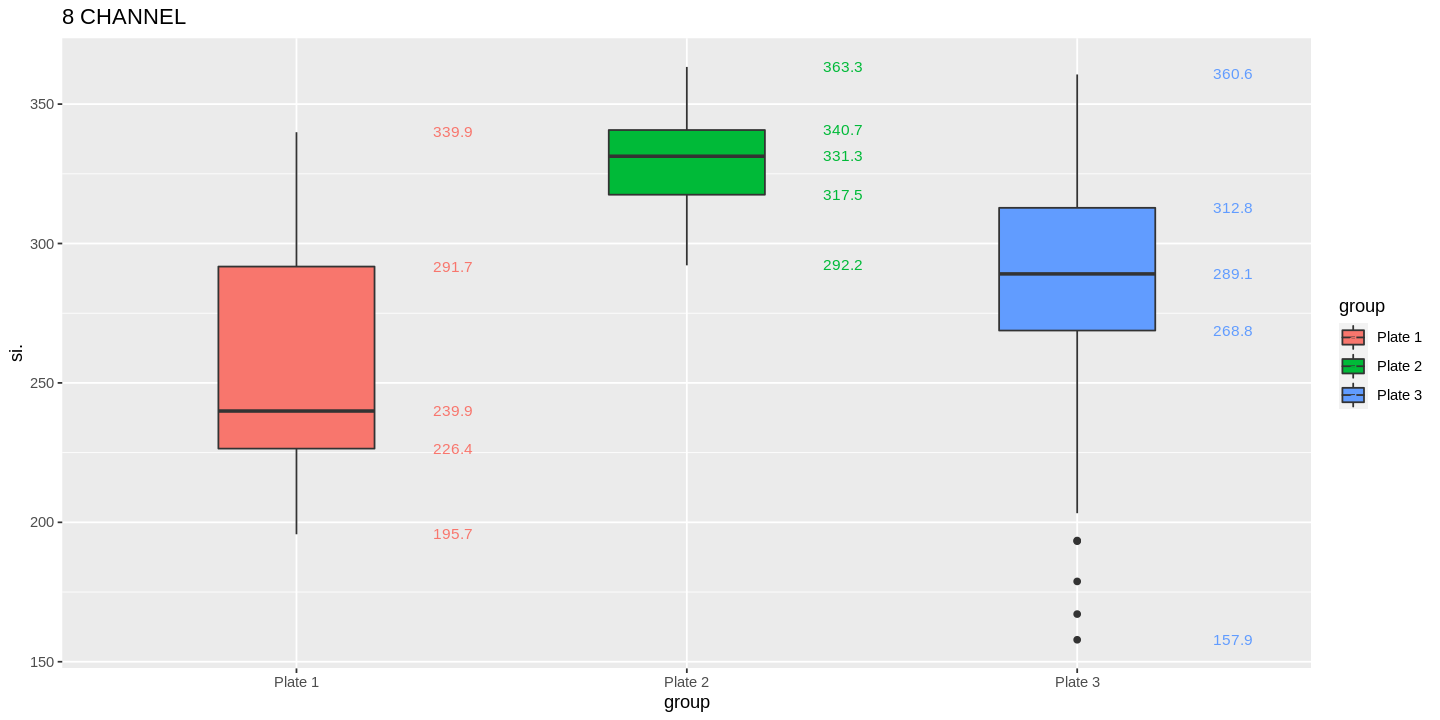

In [124]:
ggplot(df.96cr.si.cmb, aes(group, si.,fill=group)) +
    geom_boxplot(width = 0.4) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=group),
           position=position_nudge(x=0.4), size=3.25) +
    ggtitle("96 CORE HEAD")
ggsave(filename = "boxplt_96cr_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

In [54]:
# pool all three sets and run t-test to compare 
t.test(df.8chl.si.cmb$si., df.96cr.si.cmb$si., 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  df.8chl.si.cmb$si. and df.96cr.si.cmb$si.
t = 3.2782, df = 217.59, p-value = 0.001216
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  5.035831 20.220238
sample estimates:
mean of x mean of y 
 289.0149  276.3869 


In [55]:
# t-test on plate 1 of both 8 channel & 96 CORE
t.test(si.pos.8chl[[1]]$si., si.pos.96cr[[1]]$si.,
       alternative = "two.sided",
       paired = FALSE, var.equal = F,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  si.pos.8chl[[1]]$si. and si.pos.96cr[[1]]$si.
t = -6.1203, df = 62.207, p-value = 6.89e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -42.10290 -21.37228
sample estimates:
mean of x mean of y 
 256.0236  287.7611 


In [56]:
# t-test on plate 2 of both 8 channel & 96 CORE
t.test(si.pos.8chl[[2]]$si., si.pos.96cr[[2]]$si.,
       alternative = "two.sided",
       paired = FALSE, var.equal = F,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  si.pos.8chl[[2]]$si. and si.pos.96cr[[2]]$si.
t = 21.282, df = 109.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 57.54913 69.36880
sample estimates:
mean of x mean of y 
 330.4477  266.9887 


In [58]:
# t-test on plate 3 of both 8 channel & 96 CORE
t.test(si.pos.8chl[[3]]$si., si.pos.96cr[[3]]$si.,
       alternative = "two.sided",
       paired = FALSE, var.equal = F,
       conf.level = 0.95) 


	Welch Two Sample t-test

data:  si.pos.8chl[[3]]$si. and si.pos.96cr[[3]]$si.
t = 0.93918, df = 77.656, p-value = 0.3506
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -6.901774 19.227217
sample estimates:
mean of x mean of y 
 280.5736  274.4108 


### XmR charts to show data series

In [19]:
# generate well ids for x-axis 
wellIDs <- as.vector(sapply(LETTERS[1:8], function(x) {paste0(x,seq(2,8))}))

In [138]:
head(df.t)

si.      group   method
1 226.5883 Plate 1 8CHL  
2 248.4831 Plate 1 8CHL  
3 228.7705 Plate 1 8CHL  
4 292.1198 Plate 1 8CHL  
5 333.8854 Plate 1 8CHL  
6 253.8196 Plate 1 8CHL

In [26]:
dft <- dfsi.t %>% mutate(wellid = rep(wellIDs, 6))
head(dft)

si.      group   method wellid
1 226.5883 Plate 1 8CHL   A2    
2 248.4831 Plate 1 8CHL   A3    
3 228.7705 Plate 1 8CHL   A4    
4 292.1198 Plate 1 8CHL   A5    
5 333.8854 Plate 1 8CHL   A6    
6 253.8196 Plate 1 8CHL   A7

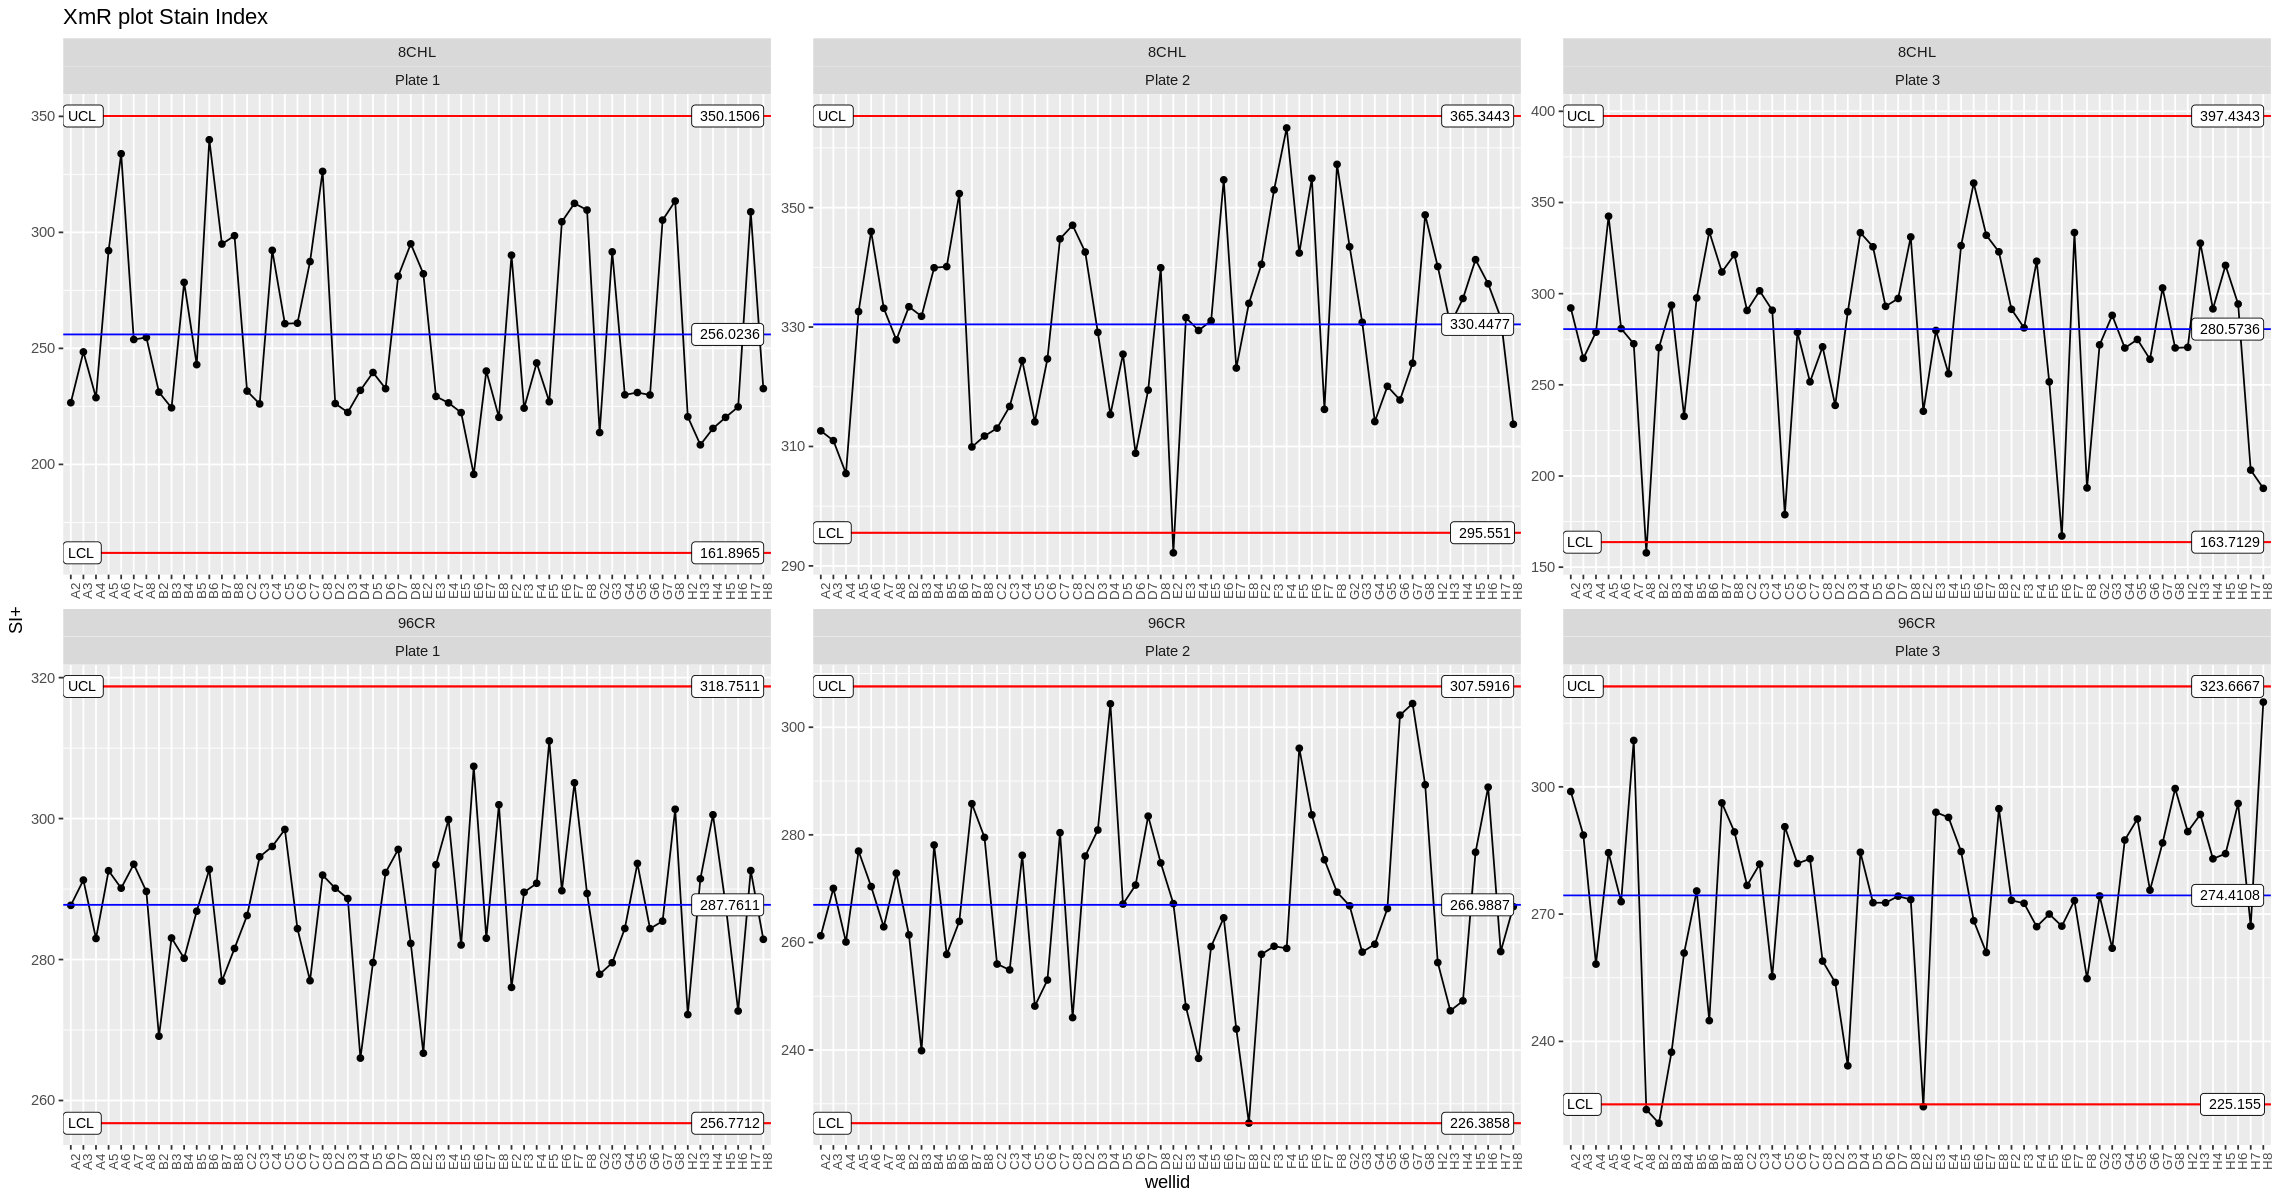

In [153]:
ggplot(dft, aes(x=wellid, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("SI+") +
  facet_wrap(method~group, scales = "free") +
  ggtitle("XmR plot Stain Index") + 
  theme(axis.text.x = element_text(size = 8, angle = 90))

Saving 350 x 169 mm image



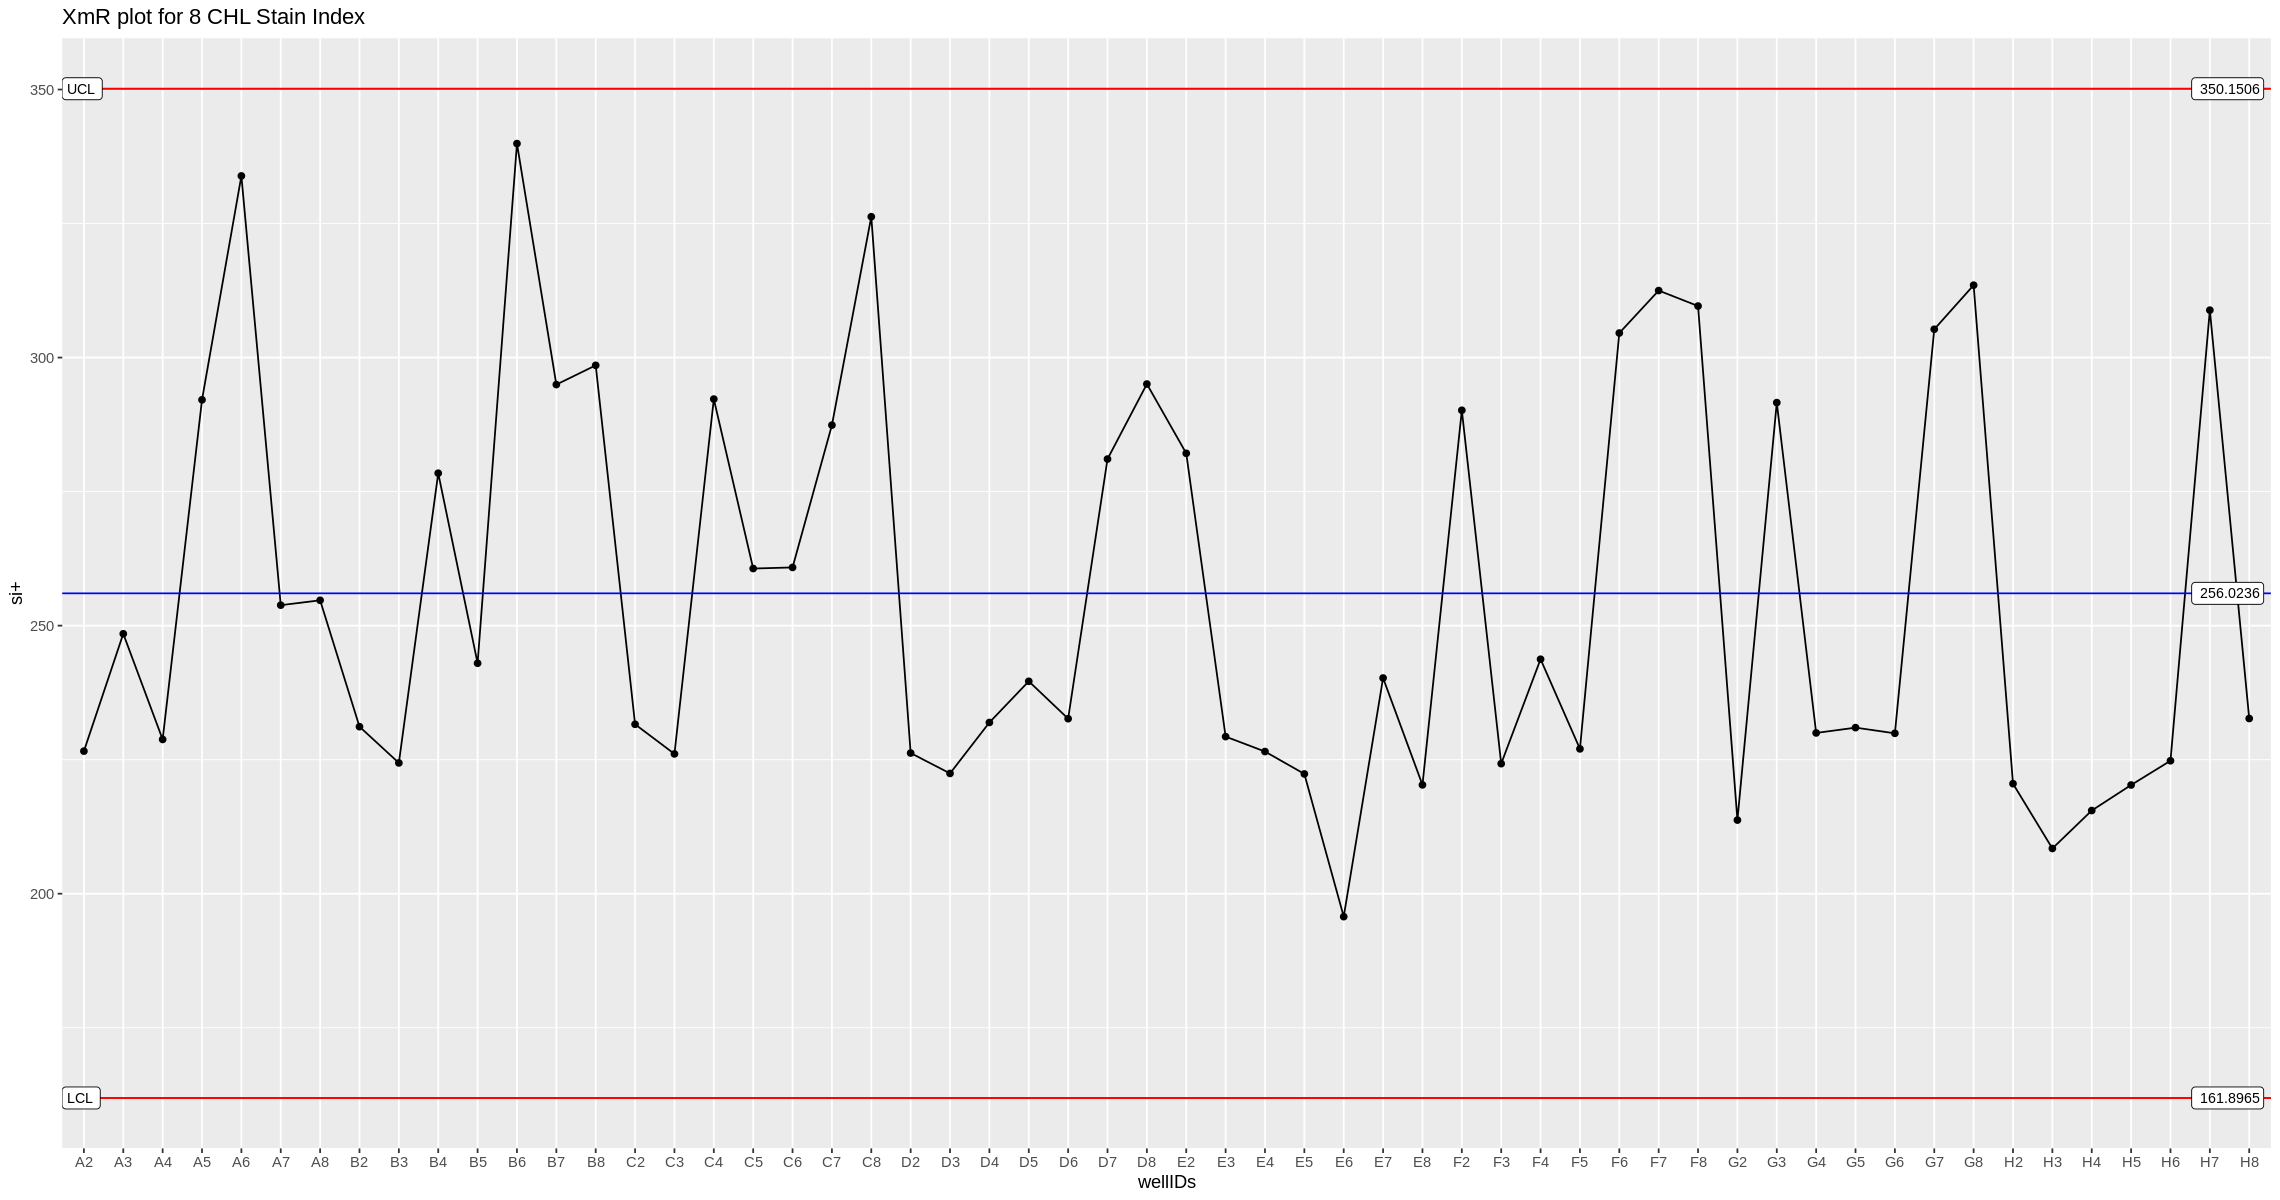

In [133]:
# 8 chl plate 1
pp<-ggplot(si.pos.8chl[[1]], aes(x=wellIDs, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("si+") +
  scale_x_discrete(expand =  expansion(mult = .01)) + 
  ggtitle("XmR plot for 8 CHL Stain Index")
ggsave(filename = "XmR_8chl_plt1_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



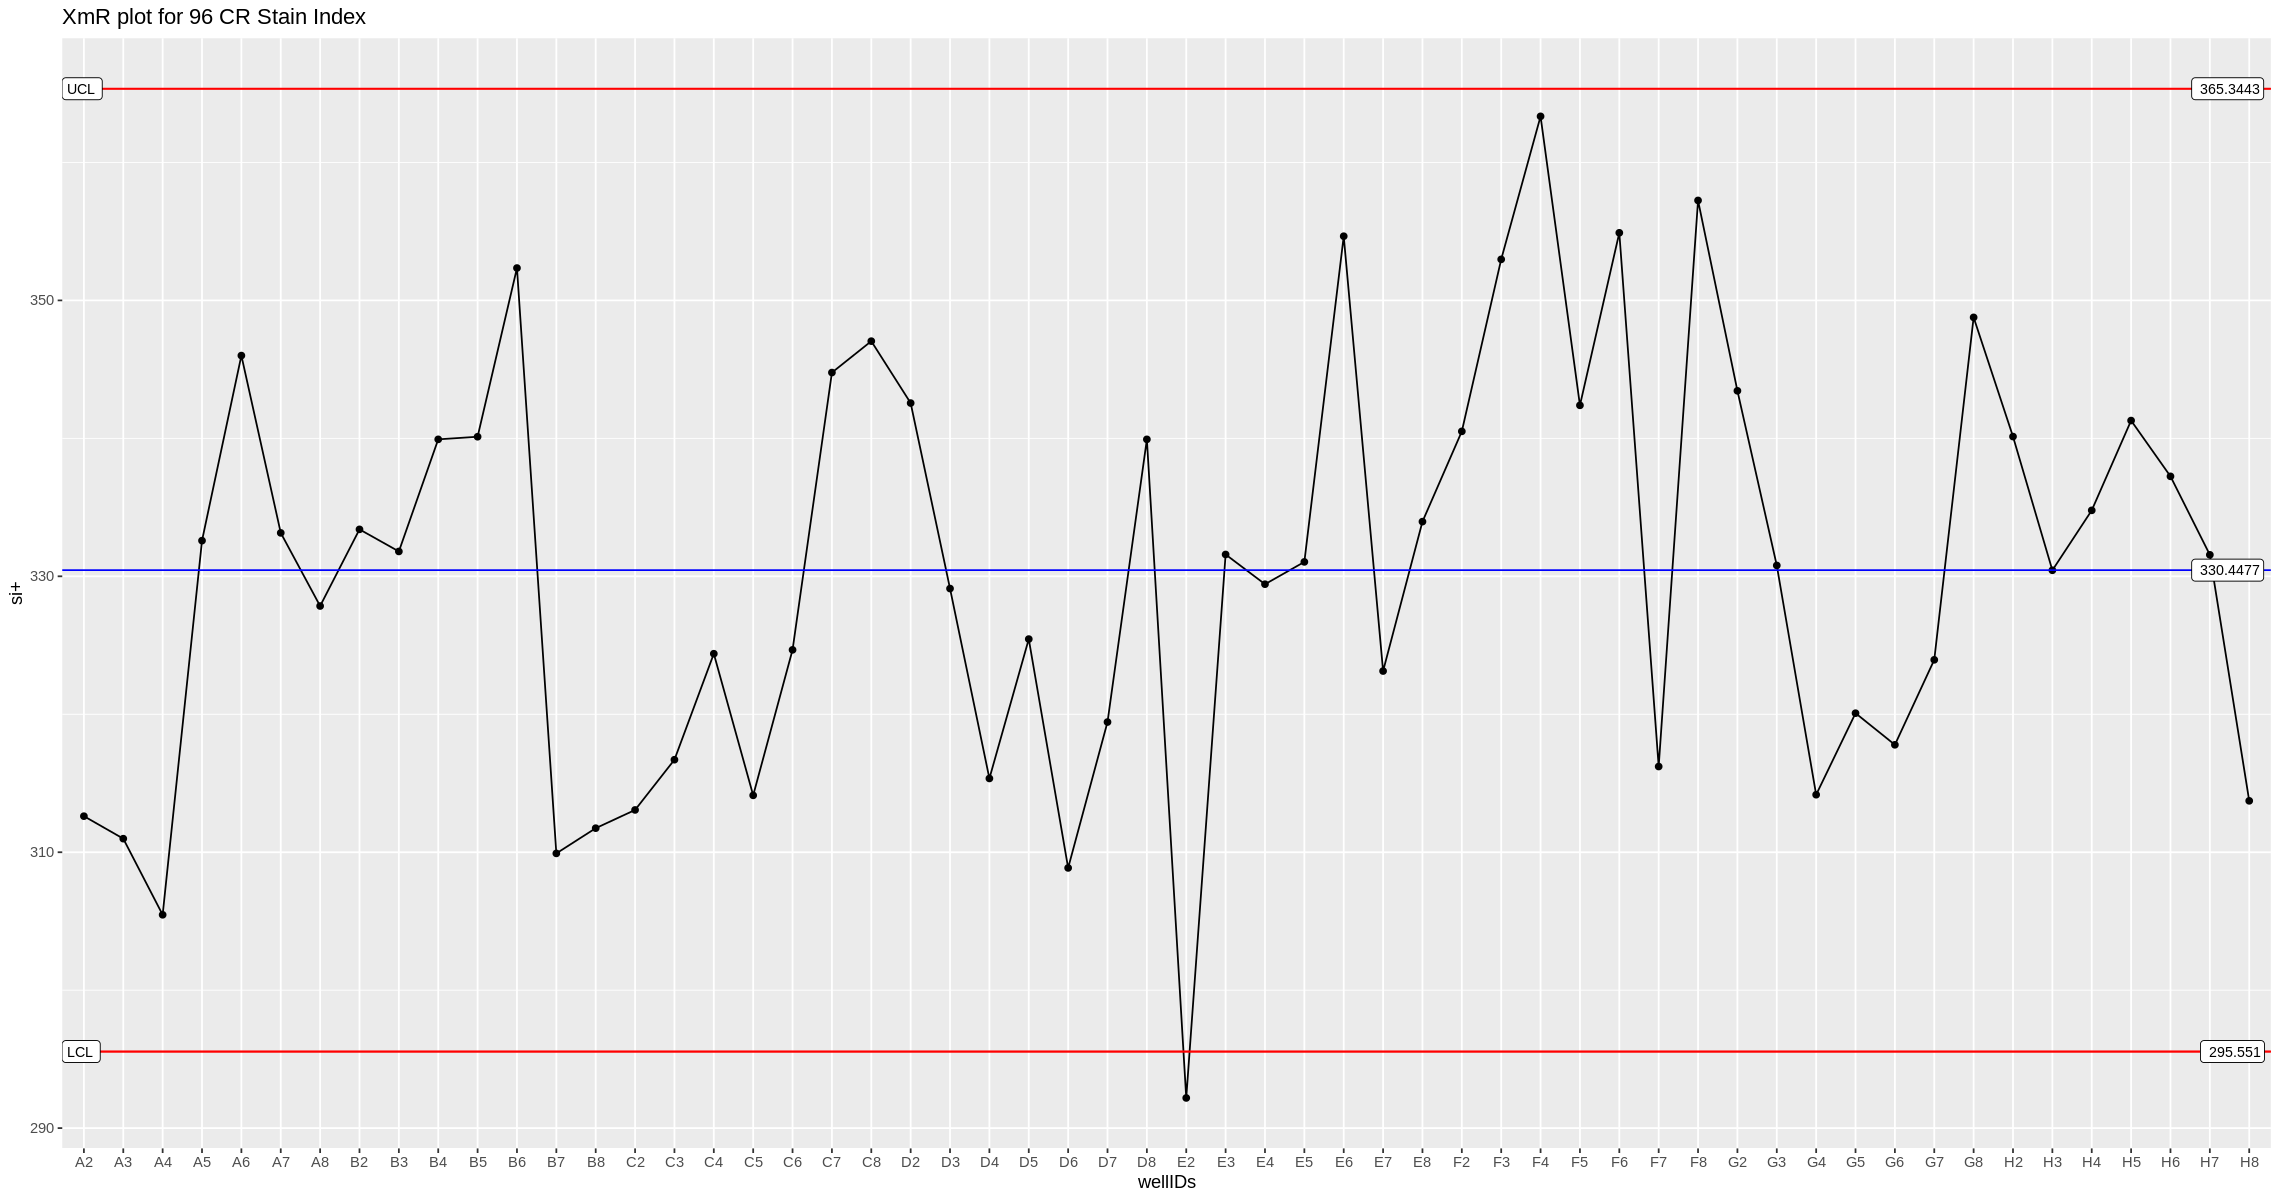

In [134]:
# 8 chl plate 2
pp<-ggplot(si.pos.8chl[[2]], aes(x=wellIDs, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("si+") +
  scale_x_discrete(expand =  expansion(mult = .01)) + 
  ggtitle("XmR plot for 96 CR Stain Index")
ggsave(filename = "XmR_8chl_plt2_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



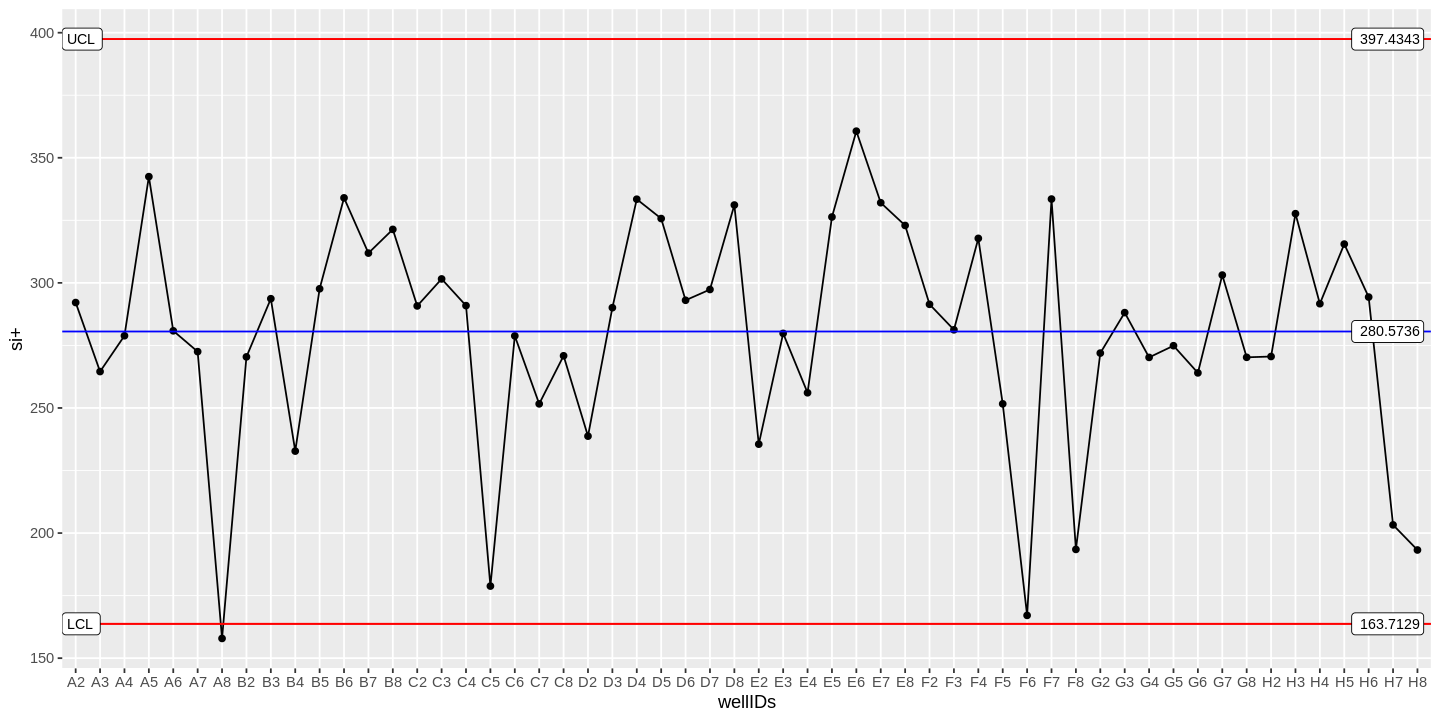

In [127]:
# 8 chl plate 3
pp<-ggplot(si.pos.8chl[[3]], aes(x=wellIDs, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("si+") +
  scale_x_discrete(expand =  expansion(mult = .01))
ggsave(filename = "XmR_8chl_plt3_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



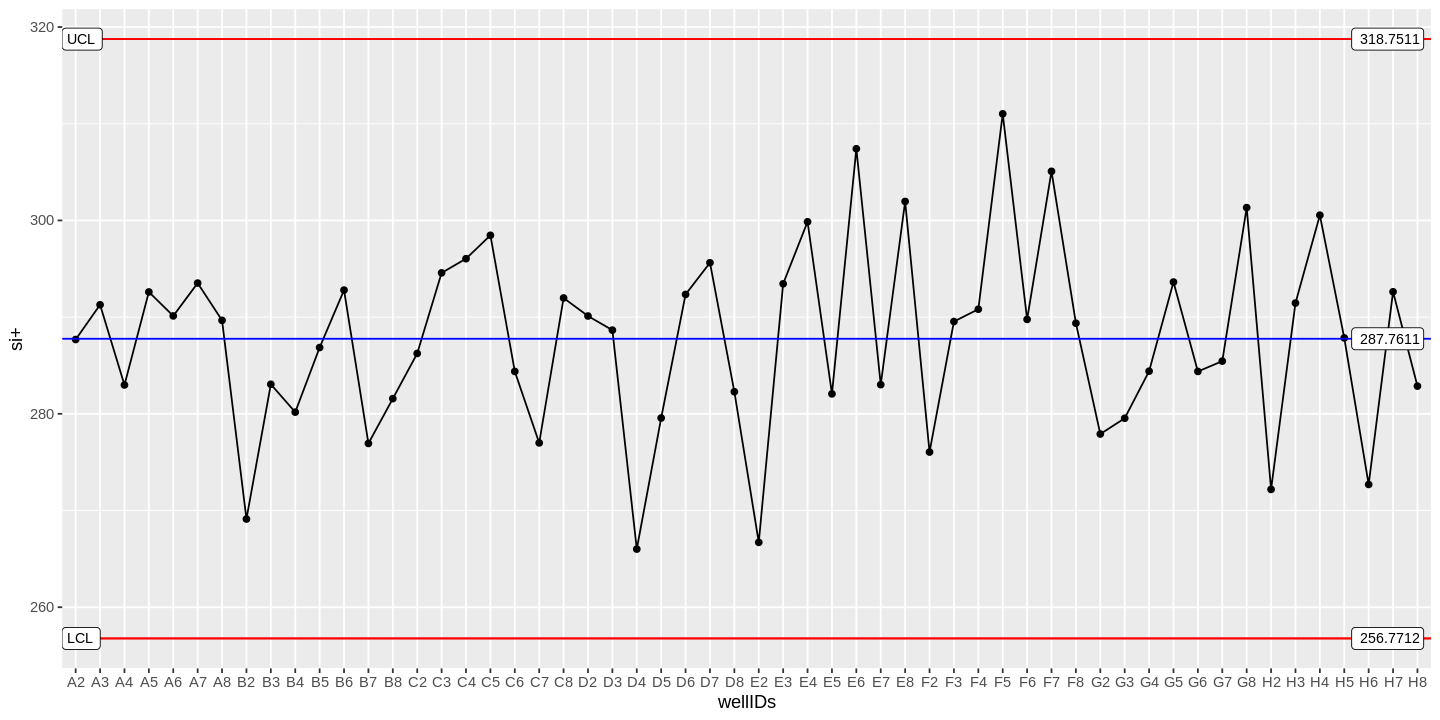

In [128]:
# 96 plate 1
pp<-ggplot(si.pos.96cr[[1]], aes(x=wellIDs, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("si+") +
  scale_x_discrete(expand =  expansion(mult = .01))
ggsave(filename = "XmR_96cr_plt1_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



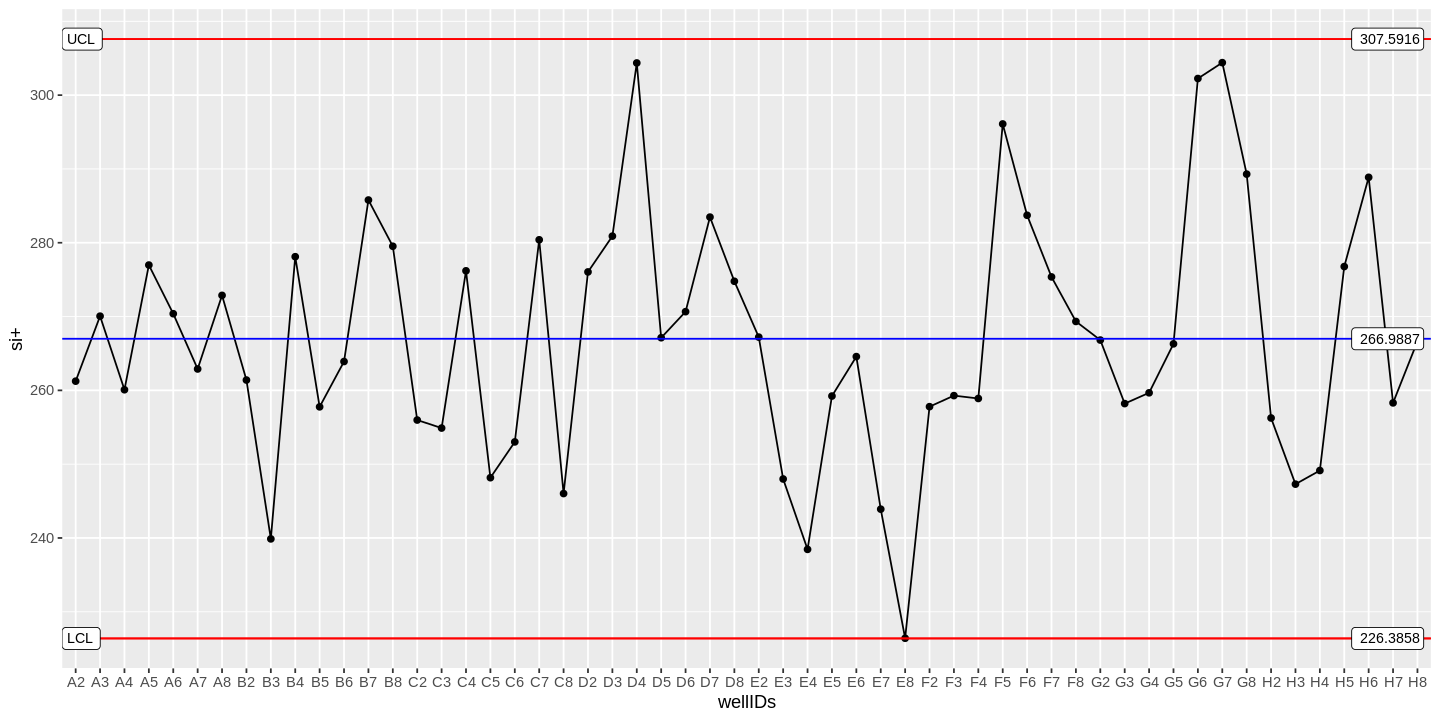

In [132]:
# 96 plate 2
pp<-ggplot(si.pos.96cr[[2]], aes(x=wellIDs, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("si+") +
  scale_x_discrete(expand =  expansion(mult = .01))
ggsave(filename = "XmR_96cr_plt2_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

Saving 350 x 169 mm image



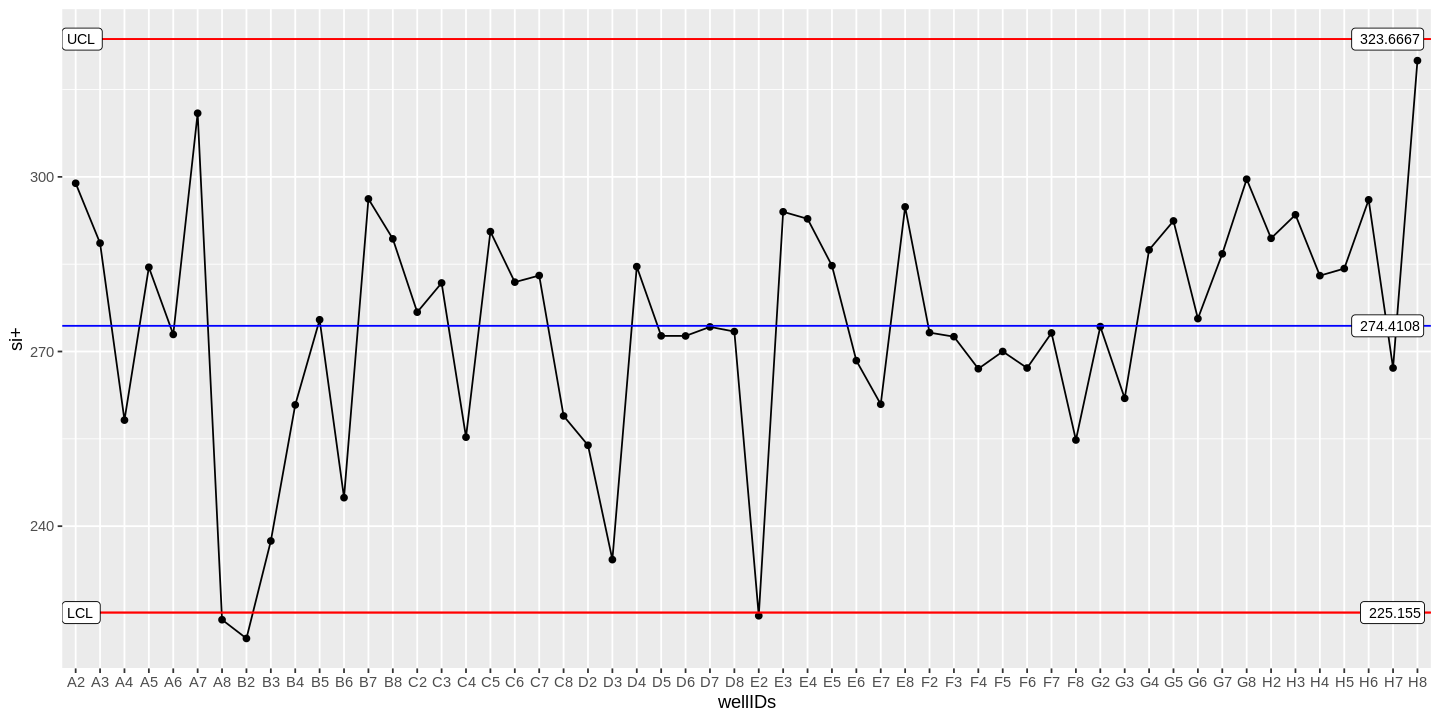

In [131]:
# 96 plate 3
pp<-ggplot(si.pos.96cr[[3]], aes(x=wellIDs, y=si., group=group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("si+") +
  scale_x_discrete(expand =  expansion(mult = .01))
ggsave(filename = "XmR_96cr_plt3_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
pp

##### XbarR Charts (subgroup size = row)
- as an entire dataset (plates 1-3)

In [66]:
dff.96cr.si <- cbind(df.96cr.si.cmb, row=rep(c("A","B","C","D","E","F","G","H"), each=7))
head(dff.96cr.si)

si.      group   row
1 287.6839 Plate 1 A  
2 291.2778 Plate 1 A  
3 282.9836 Plate 1 A  
4 292.6022 Plate 1 A  
5 290.1227 Plate 1 A  
6 293.5202 Plate 1 A

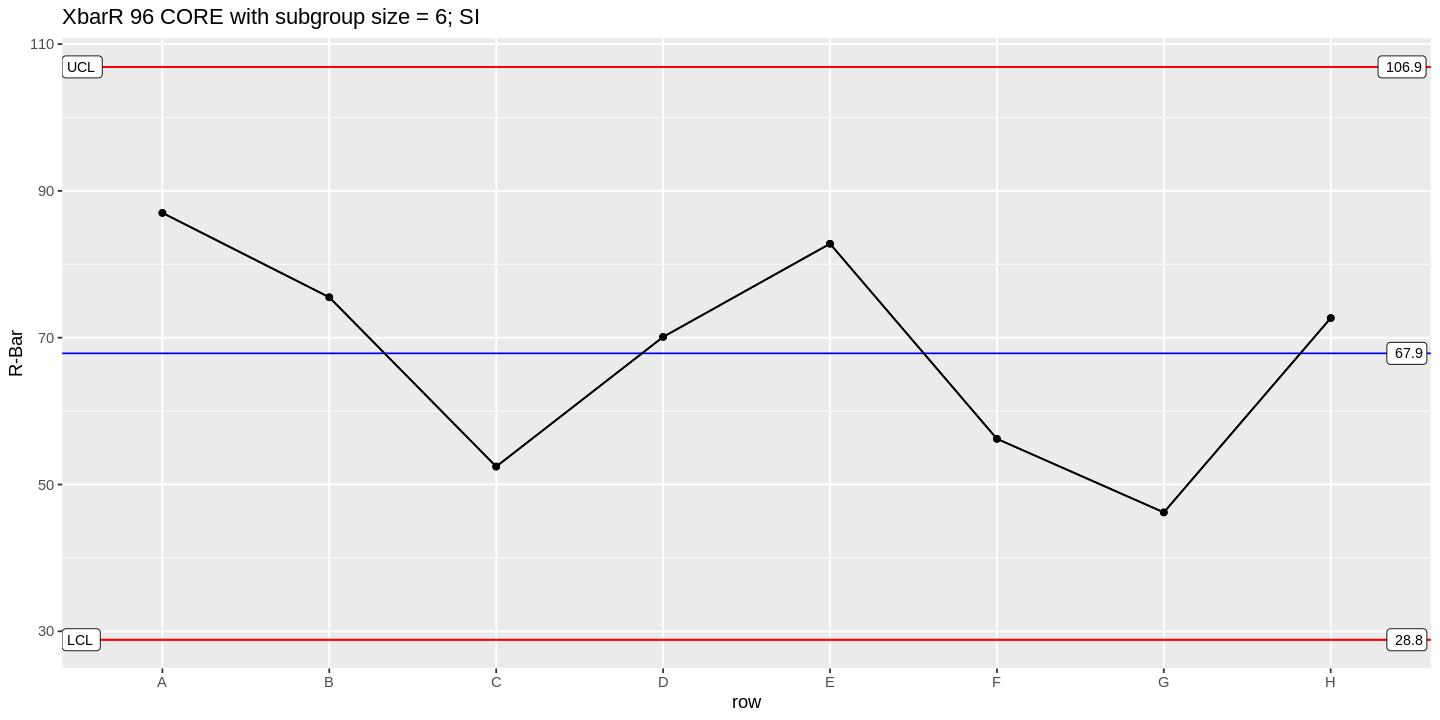

In [71]:
# the RANGE of each subgroup as an absolute diff
suppressWarnings(ggplot(dff.96cr.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 96 CORE with subgroup size = 6; SI"))

In [72]:
dff.8chl.si <- cbind(df.8chl.si.cmb, row=rep(c("A","B","C","D","E","F","G","H"), each=7))
head(dff.8chl.si)

si.      group   row
1 226.5883 Plate 1 A  
2 248.4831 Plate 1 A  
3 228.7705 Plate 1 A  
4 292.1198 Plate 1 A  
5 333.8854 Plate 1 A  
6 253.8196 Plate 1 A

In [154]:
head(dft)

si.      group   method wellid
1 226.5883 Plate 1 8CHL   A2    
2 248.4831 Plate 1 8CHL   A3    
3 228.7705 Plate 1 8CHL   A4    
4 292.1198 Plate 1 8CHL   A5    
5 333.8854 Plate 1 8CHL   A6    
6 253.8196 Plate 1 8CHL   A7

In [28]:
dft <- dft %>% mutate(row = substr(wellid, 1,1))

In [32]:
dft2 <- dft %>% 
    group_by(method, wellid) %>%
    summarise(Mean= mean(si.))
head(dft2)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



method wellid Mean    
1 8CHL   A2     277.1140
2 8CHL   A3     274.6719
3 8CHL   A4     271.0341
4 8CHL   A5     322.3874
5 8CHL   A6     320.2408
6 8CHL   A7     286.4948

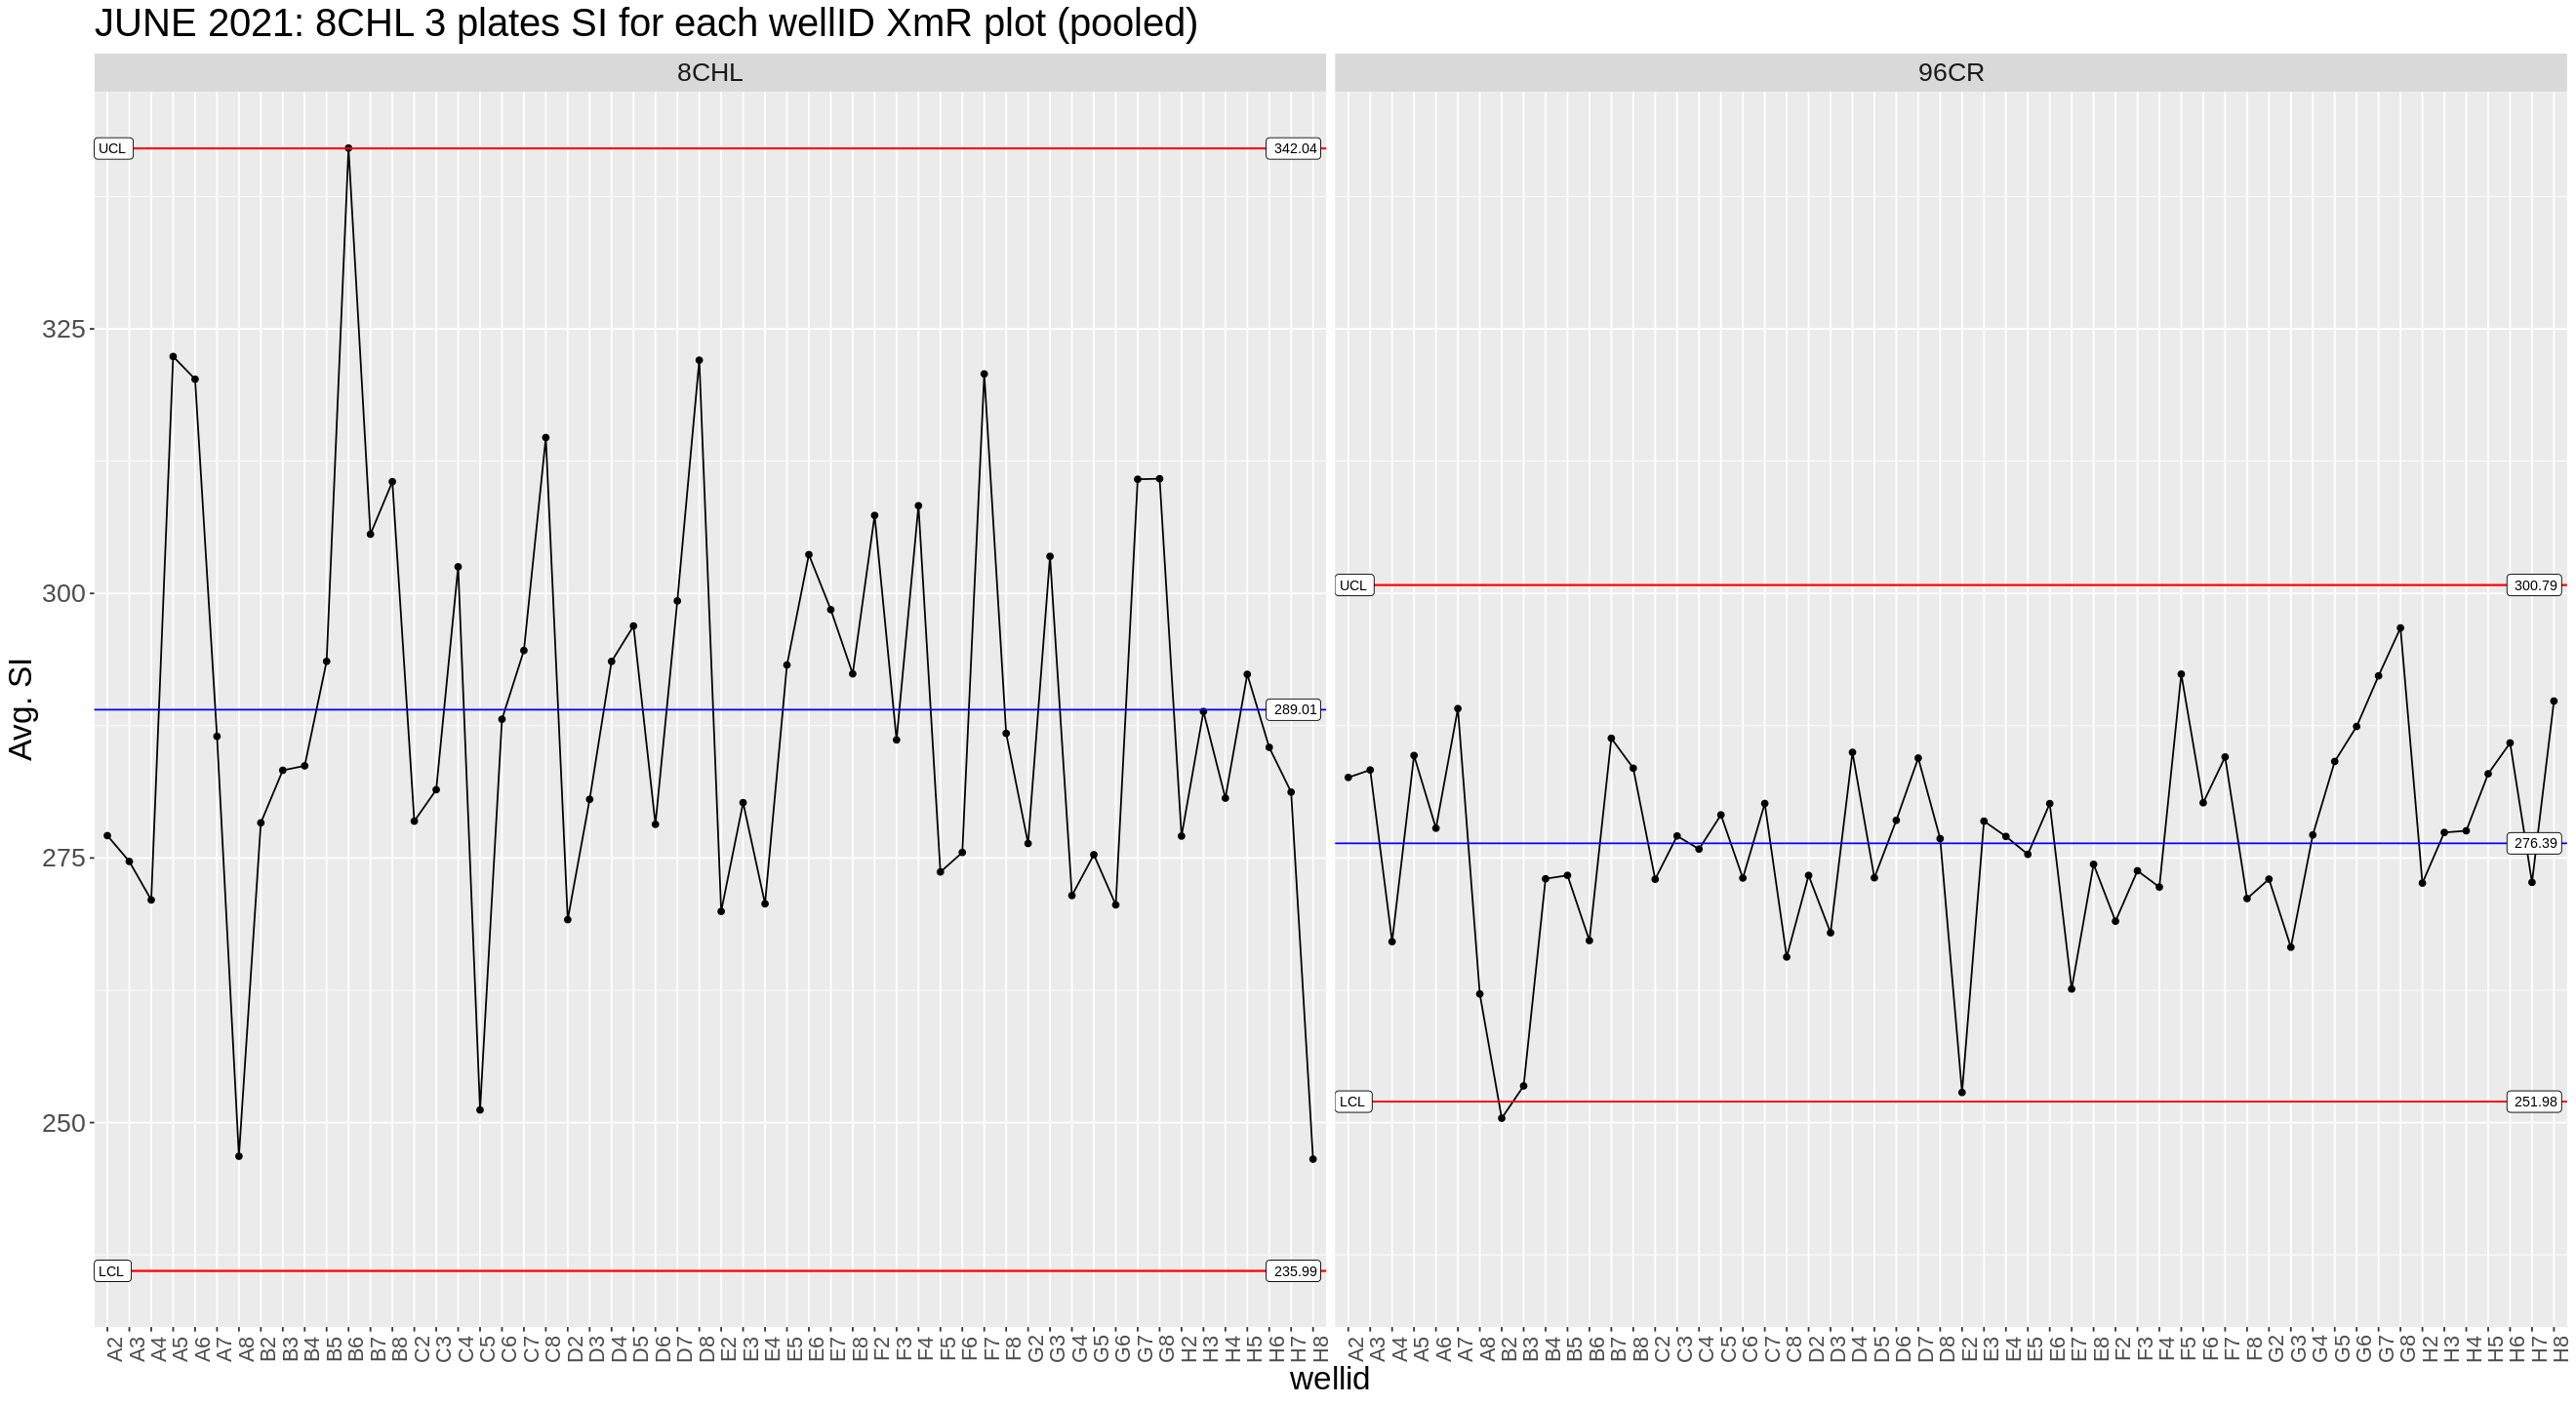

In [33]:
# pooled xmr plot per well
ggplot(dft2, aes(x=wellid, y=Mean, group=method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Avg. SI") +
  facet_wrap(~ method) + 
  ggtitle("JUNE 2021: 8CHL 3 plates SI for each wellID XmR plot (pooled)") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 13, angle = 90))

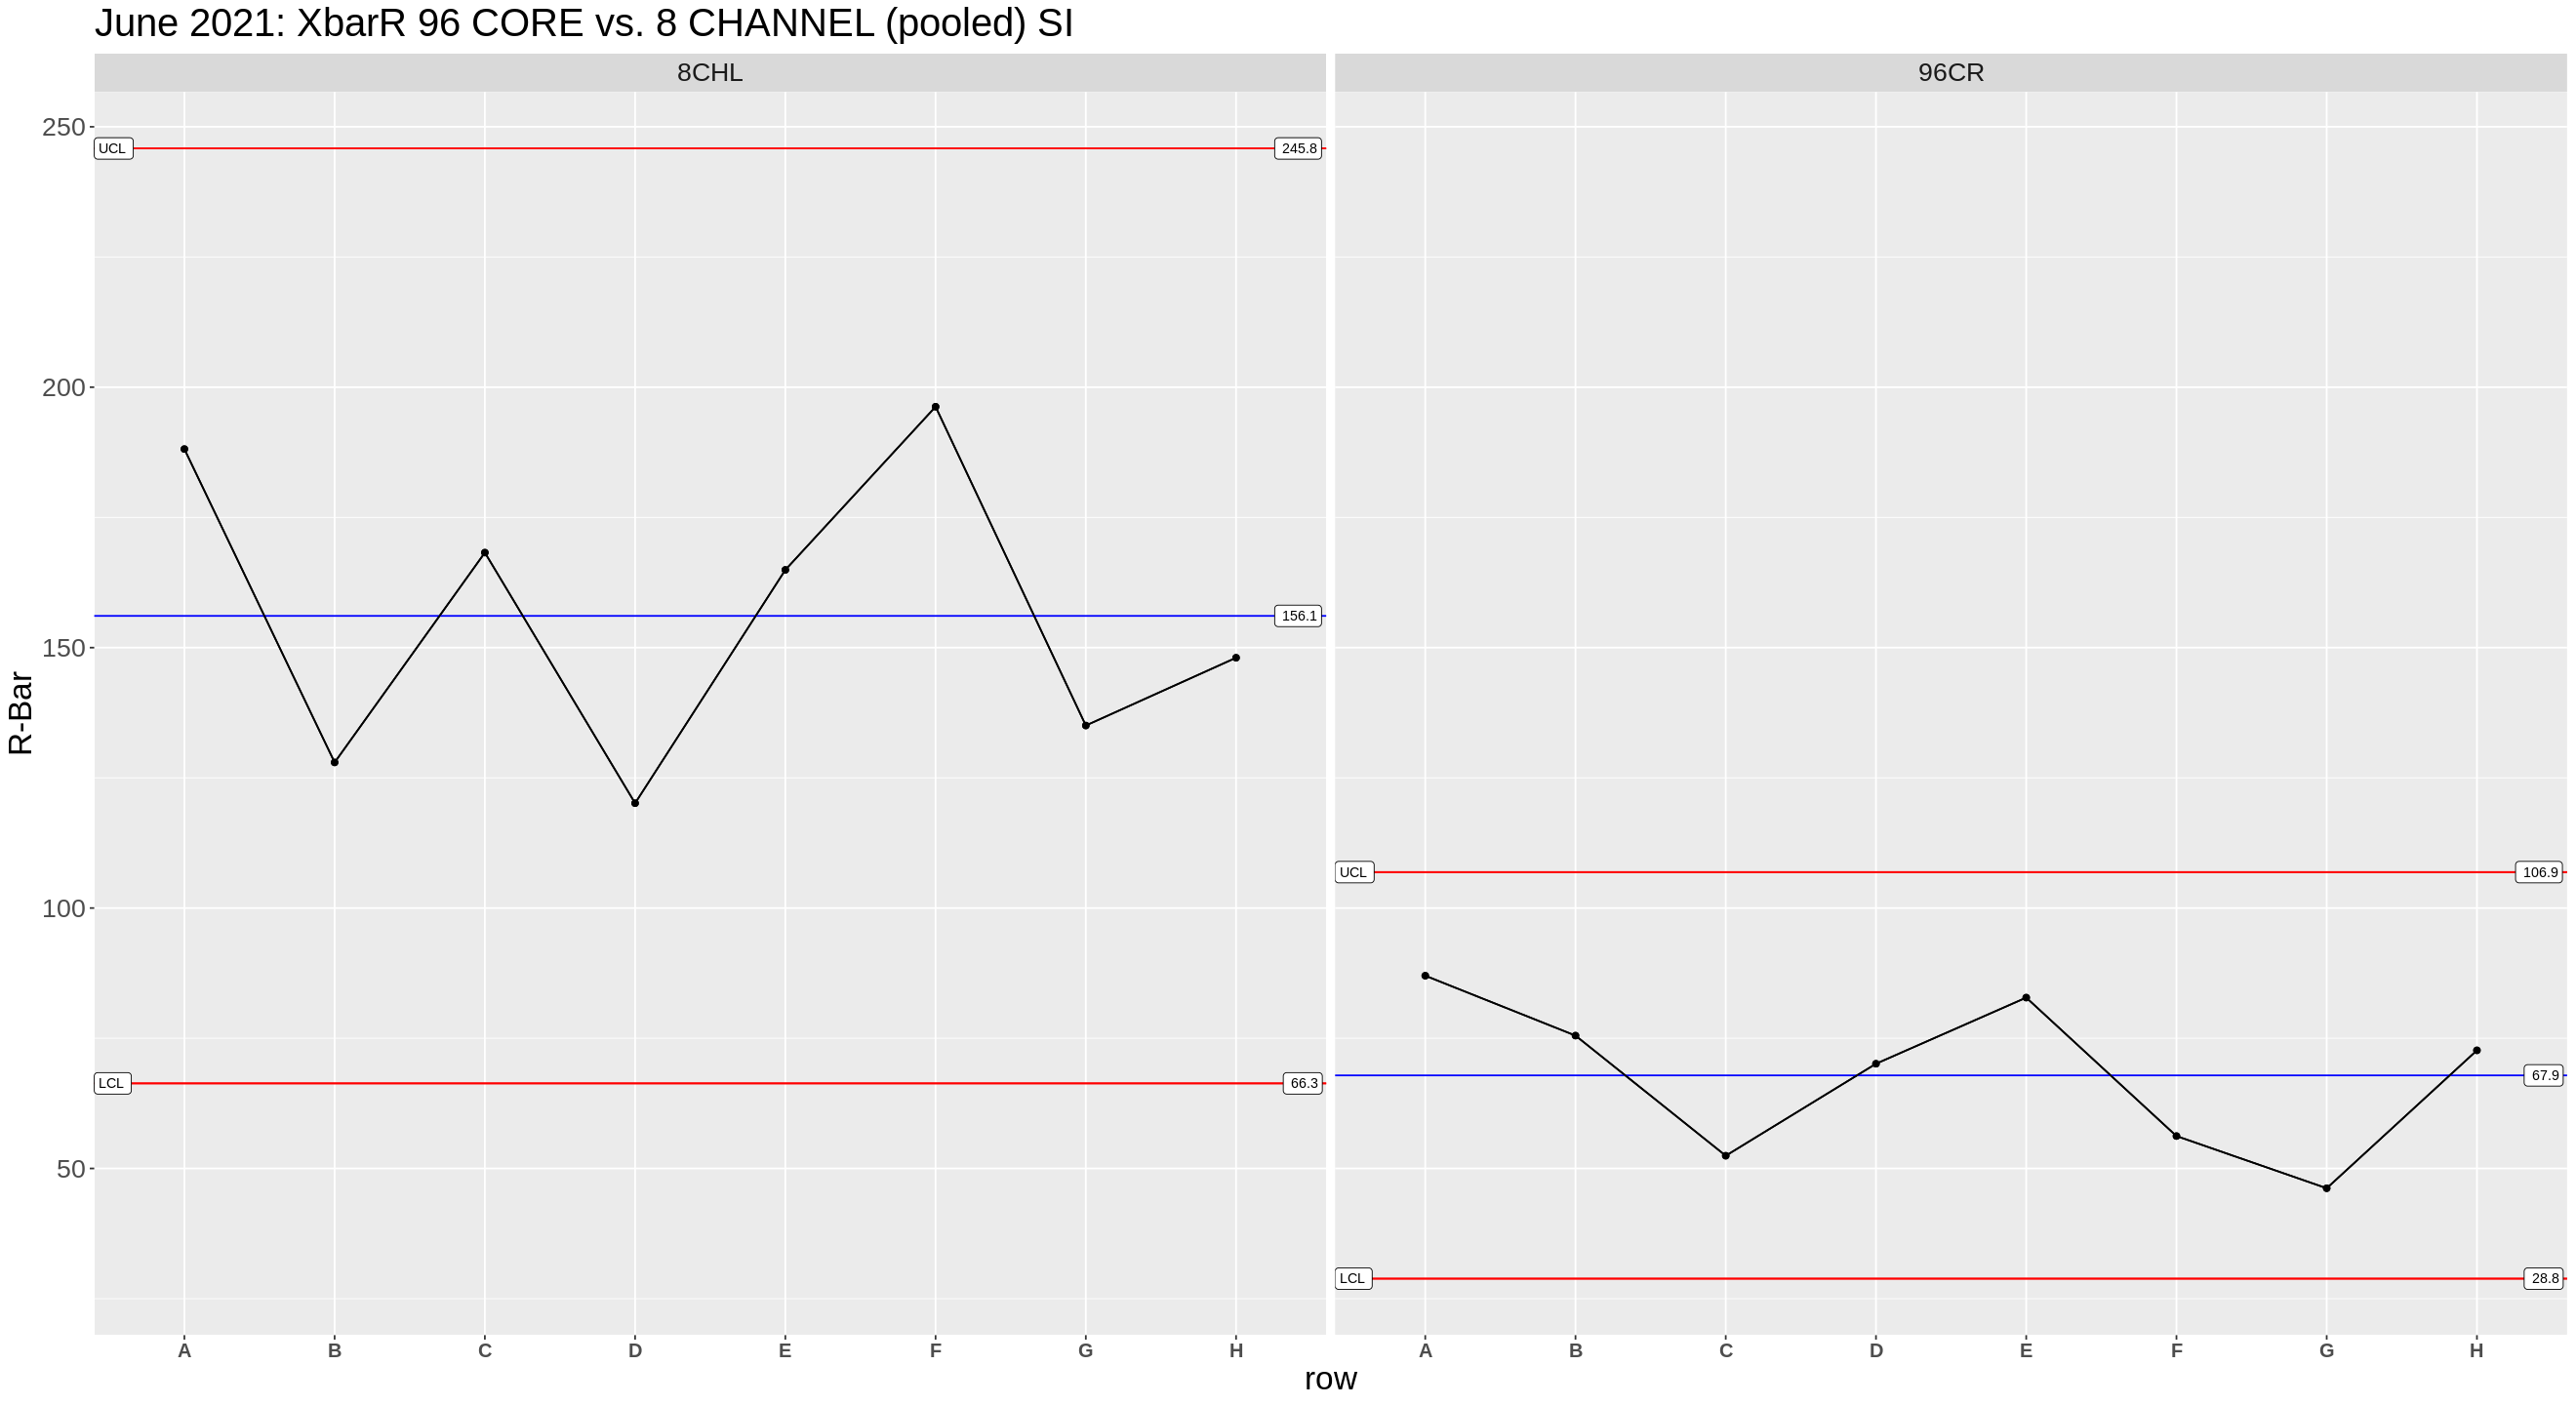

In [30]:
suppressWarnings(ggplot(dft, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         #facet_wrap(~method, scales = "free") +
         facet_wrap(~method) +
         ggtitle("June 2021: XbarR 96 CORE vs. 8 CHANNEL (pooled) SI")) +
         theme(text = element_text(size=20),
            axis.text.x = element_text(face = "bold", 
                               size = 12)) 

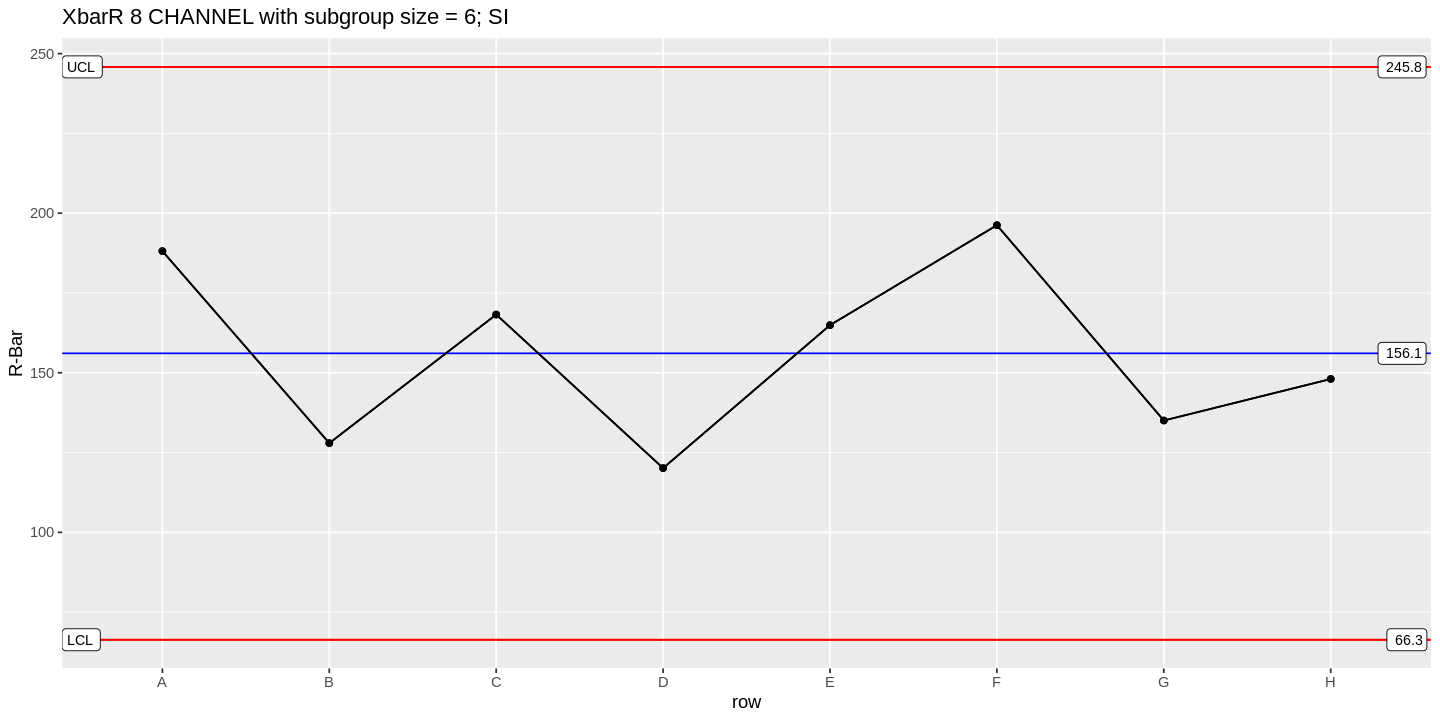

In [73]:
suppressWarnings(ggplot(dff.8chl.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 8 CHANNEL with subgroup size = 6; SI"))

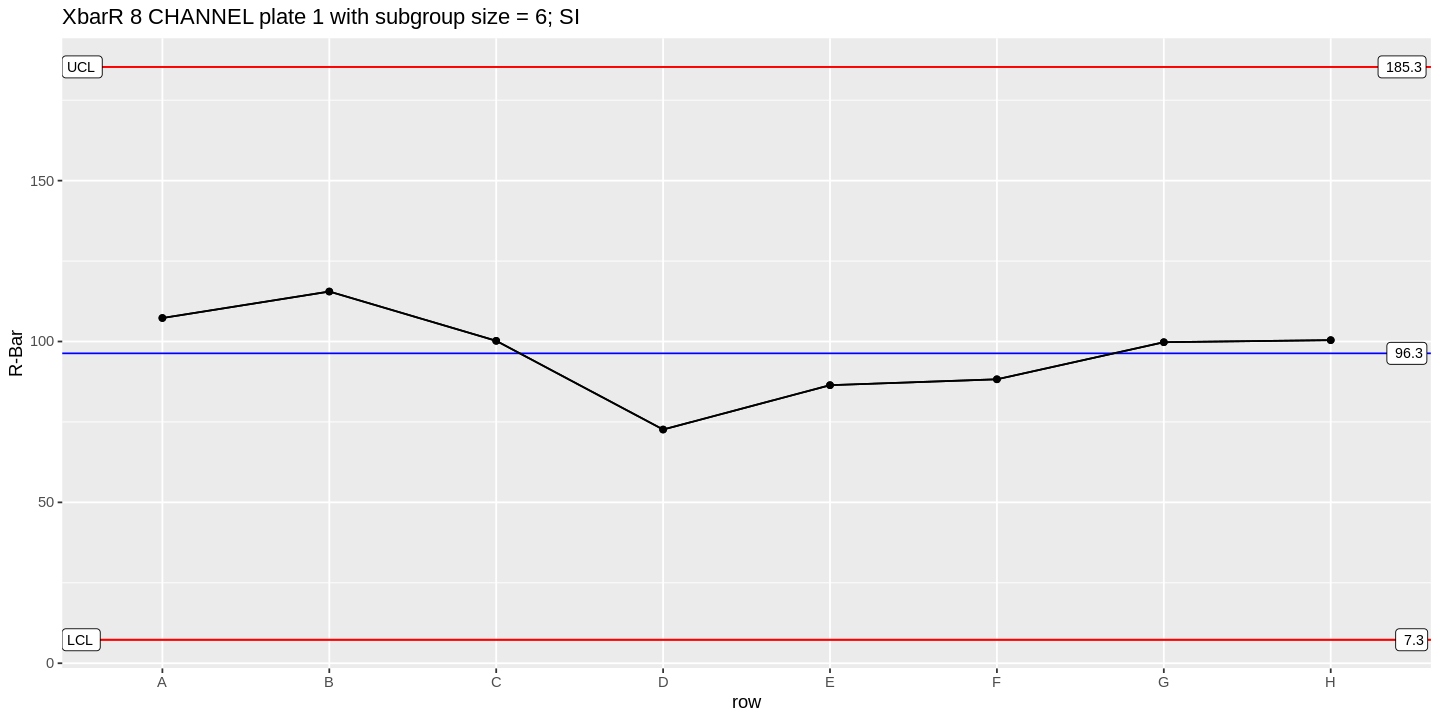

In [74]:
dff.8chl.si <- cbind(si.pos.8chl[[1]], row=rep(c("A","B","C","D","E","F","G","H"), each=7))
suppressWarnings(ggplot(dff.8chl.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 8 CHANNEL plate 1 with subgroup size = 6; SI"))

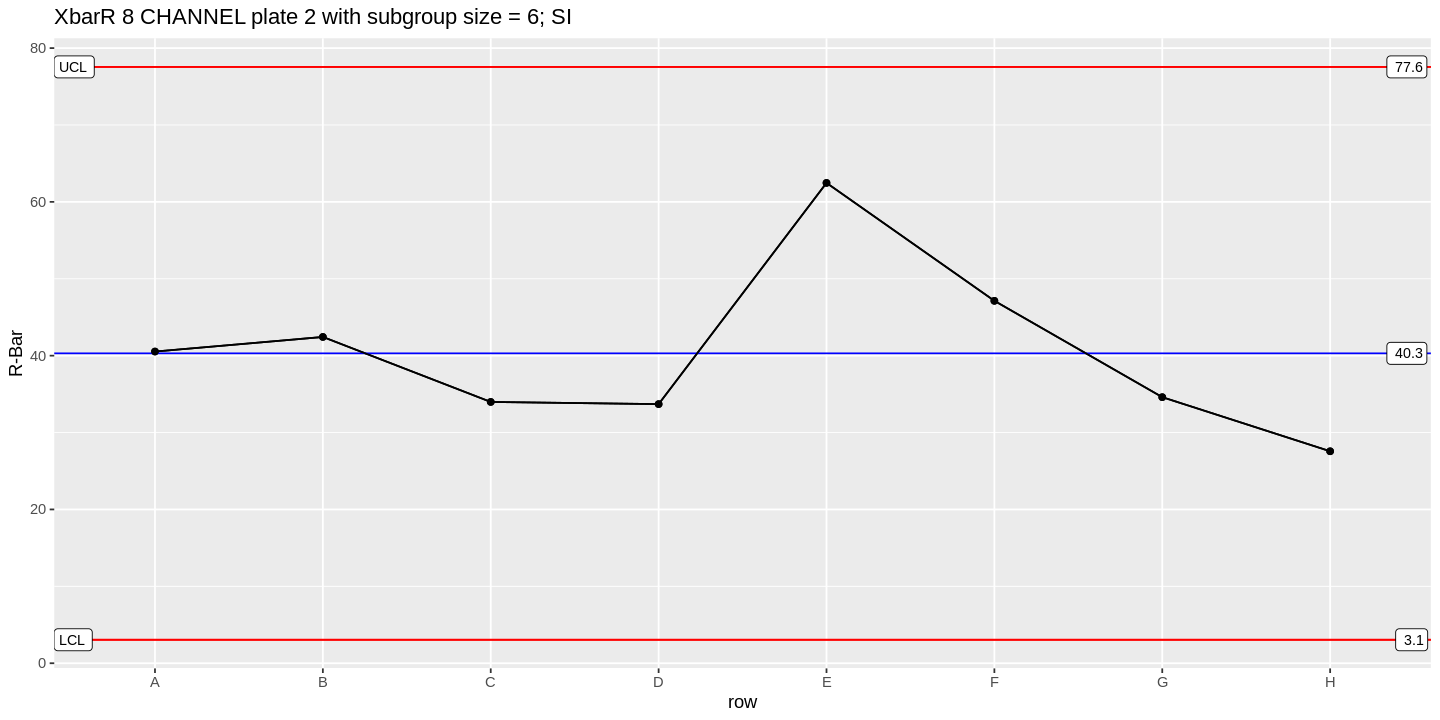

In [75]:
dff.8chl.si <- cbind(si.pos.8chl[[2]], row=rep(c("A","B","C","D","E","F","G","H"), each=7))
suppressWarnings(ggplot(dff.8chl.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 8 CHANNEL plate 2 with subgroup size = 6; SI"))

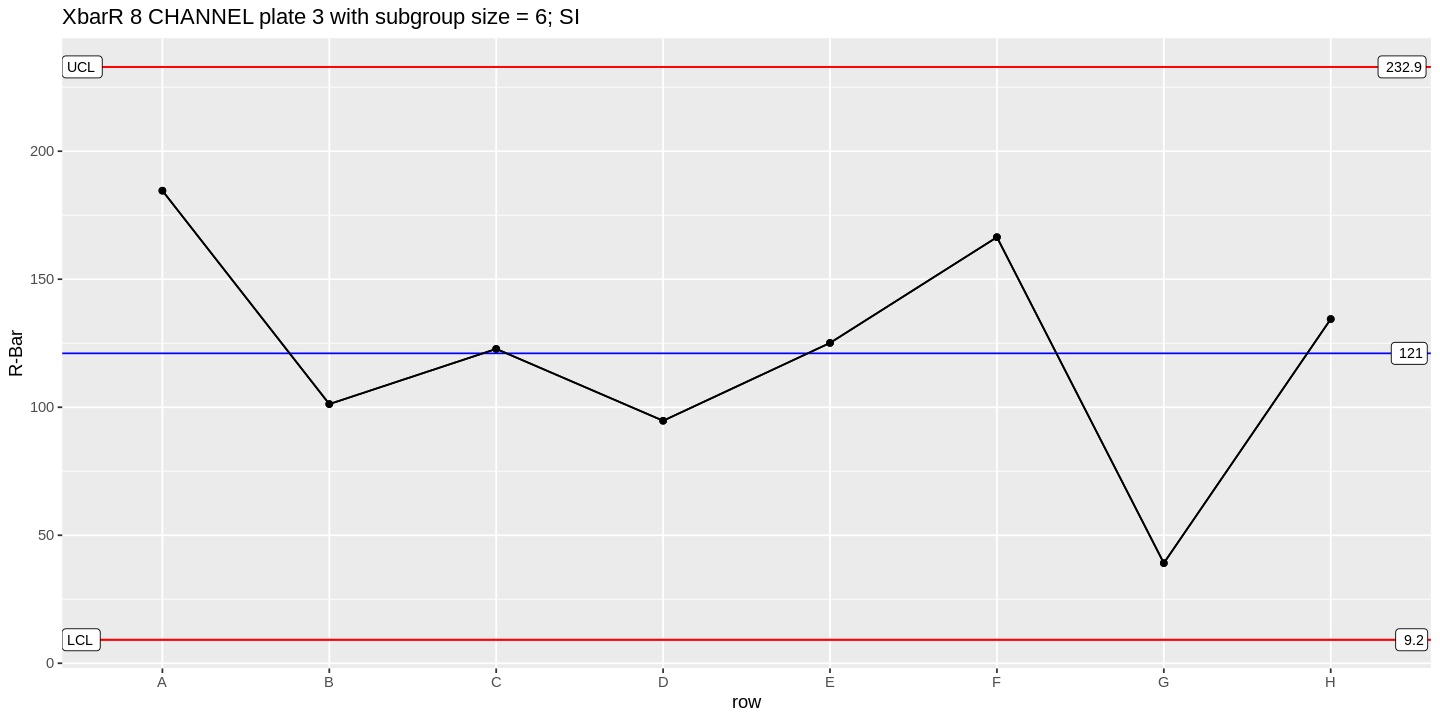

In [76]:
dff.8chl.si <- cbind(si.pos.8chl[[3]], row=rep(c("A","B","C","D","E","F","G","H"), each=7))
suppressWarnings(ggplot(dff.8chl.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 8 CHANNEL plate 3 with subgroup size = 6; SI"))

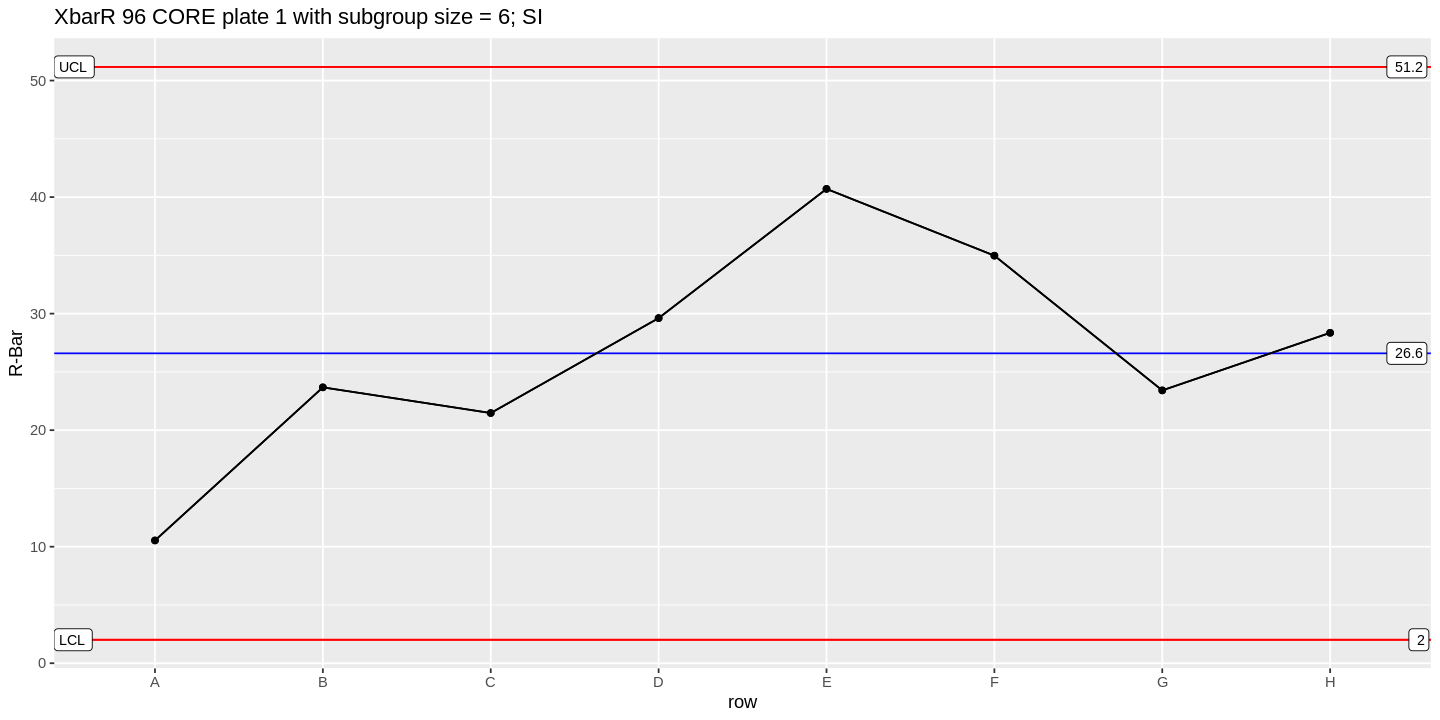

In [77]:
dff.96cr.si <- cbind(si.pos.96cr[[1]], row=rep(c("A","B","C","D","E","F","G","H"), each=7))
suppressWarnings(ggplot(dff.96cr.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 96 CORE plate 1 with subgroup size = 6; SI"))

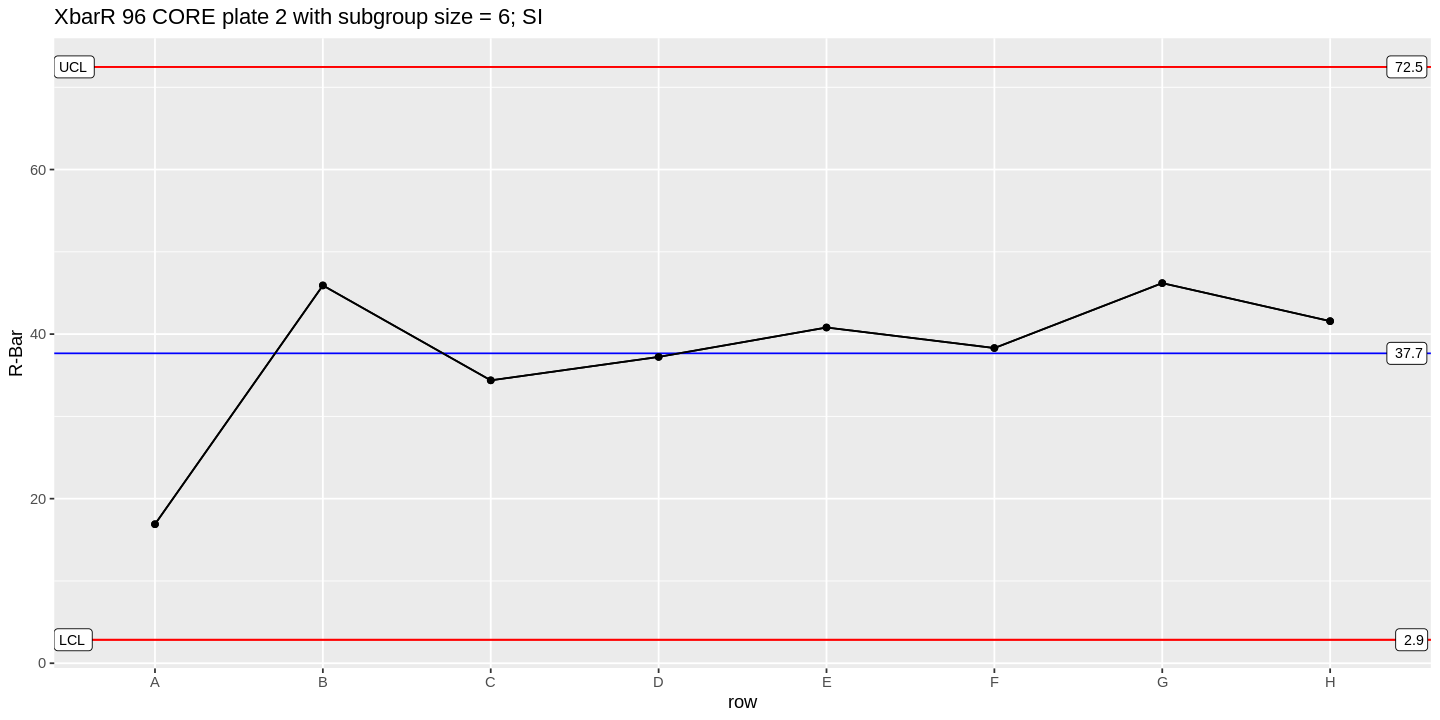

In [78]:
dff.96cr.si <- cbind(si.pos.96cr[[2]], row=rep(c("A","B","C","D","E","F","G","H"), each=7))
suppressWarnings(ggplot(dff.96cr.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 96 CORE plate 2 with subgroup size = 6; SI"))

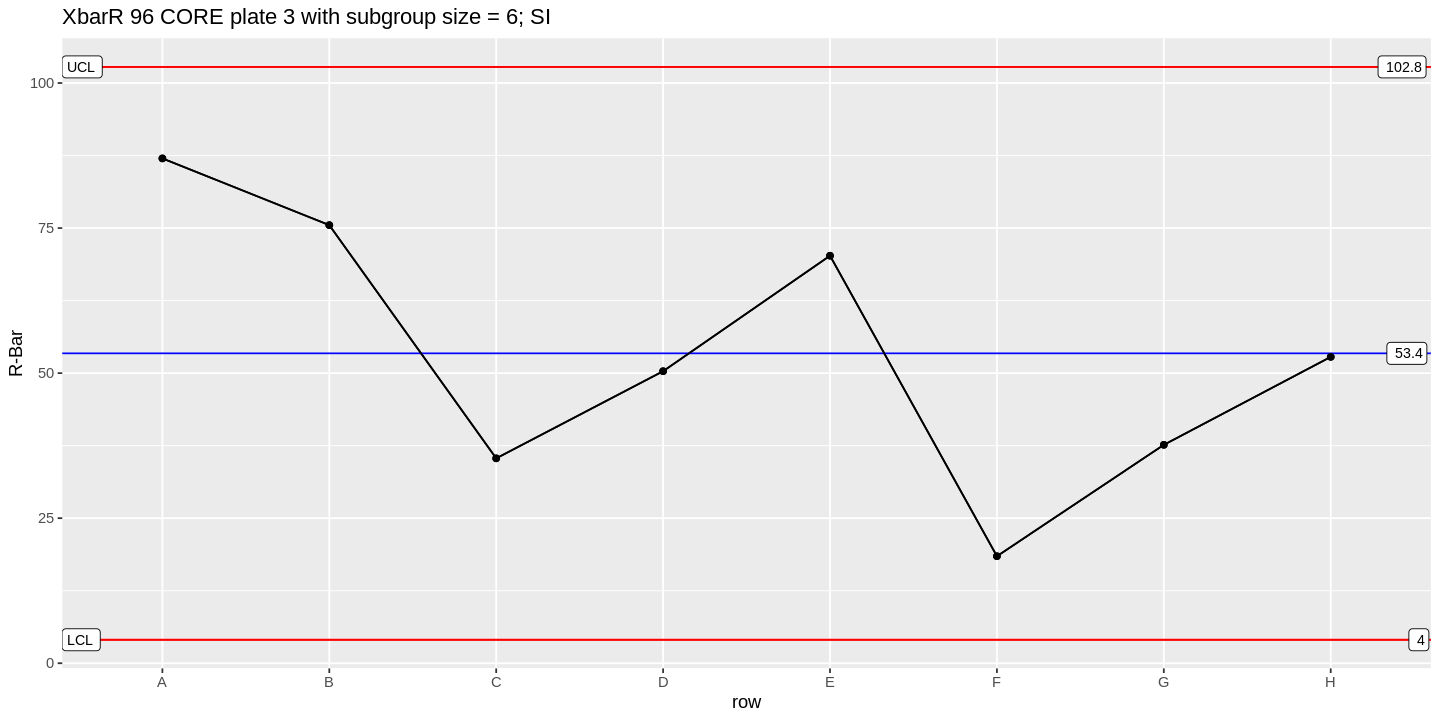

In [79]:
dff.96cr.si <- cbind(si.pos.96cr[[3]], row=rep(c("A","B","C","D","E","F","G","H"), each=7))
suppressWarnings(ggplot(dff.96cr.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR 96 CORE plate 3 with subgroup size = 6; SI"))

### Scatter of 96 vs 8

In [279]:
nrow(dff)

[1] 336

In [281]:
336/length(wellIDs)

[1] 6

In [282]:
dff <- reshape2::melt(cbind(df.8chl.si.cmb$si., df.96cr.si.cmb$si.)) 
colnames(dff) <- c("INDEX", "GROUP", "SI")
dff <- dff %>% 
       mutate(GROUP = ifelse(GROUP == 1,"8CHL", "96CR")) %>%
       mutate(PLATE = rep(df.8chl.si.cmb$group, 2)) %>%
       mutate(WELLID = rep(wellIDs, 6))

In [283]:
head(dff)

INDEX GROUP SI       PLATE   WELLID
1 1     8CHL  226.5883 Plate 1 A2    
2 2     8CHL  248.4831 Plate 1 A3    
3 3     8CHL  228.7705 Plate 1 A4    
4 4     8CHL  292.1198 Plate 1 A5    
5 5     8CHL  333.8854 Plate 1 A6    
6 6     8CHL  253.8196 Plate 1 A7

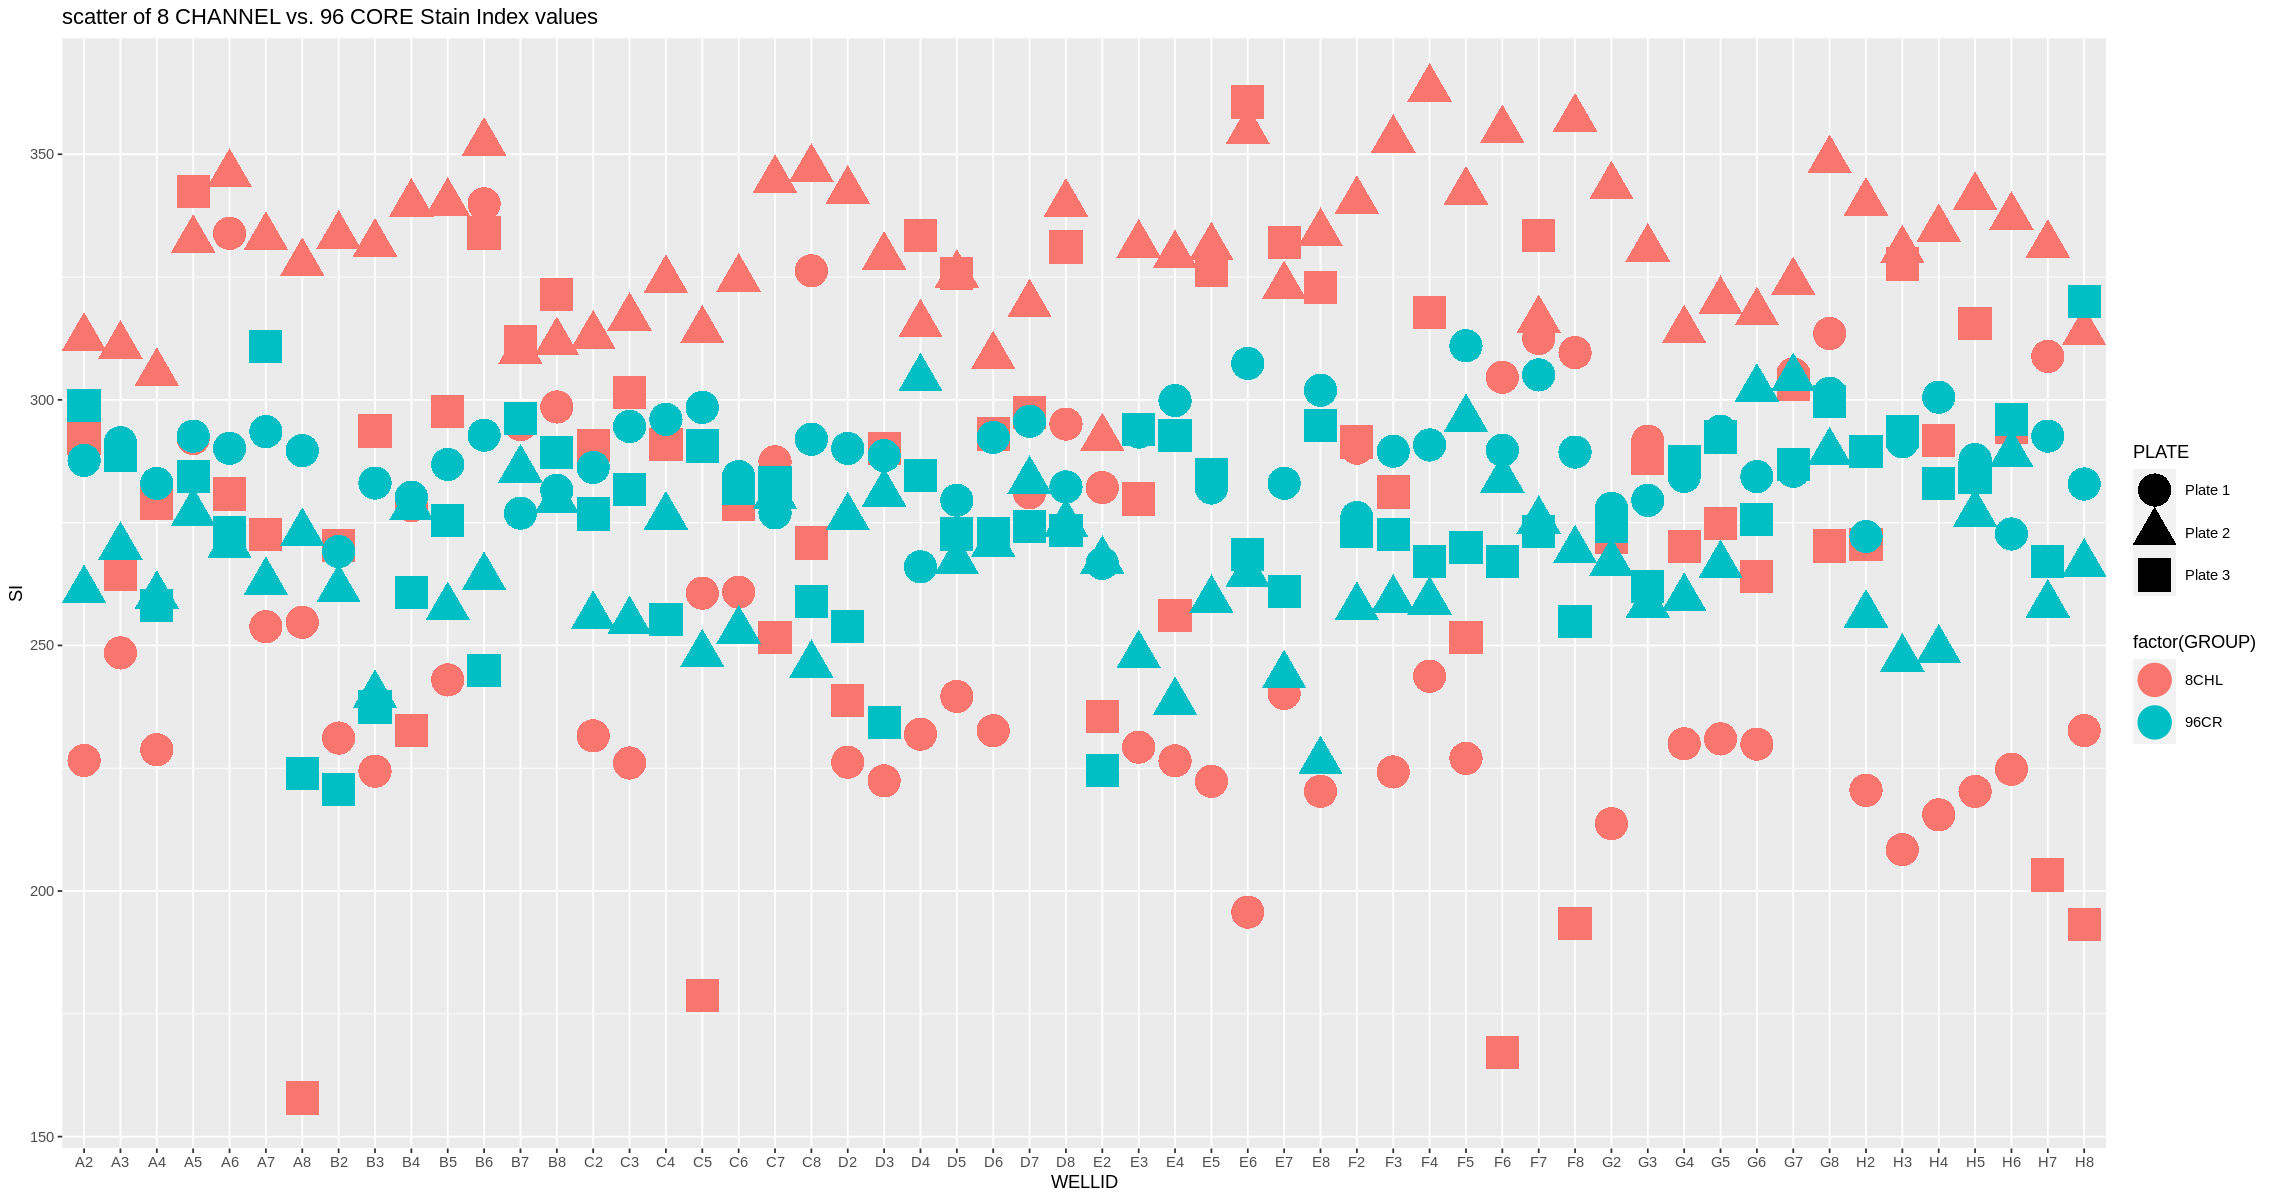

In [285]:
# using entire set of 3
ggplot(dff, aes(x = WELLID, y = SI, group = GROUP)) + 
    geom_point(size = 9, aes(colour = factor(GROUP), shape = PLATE)) + 
    ggtitle("scatter of 8 CHANNEL vs. 96 CORE Stain Index values") 

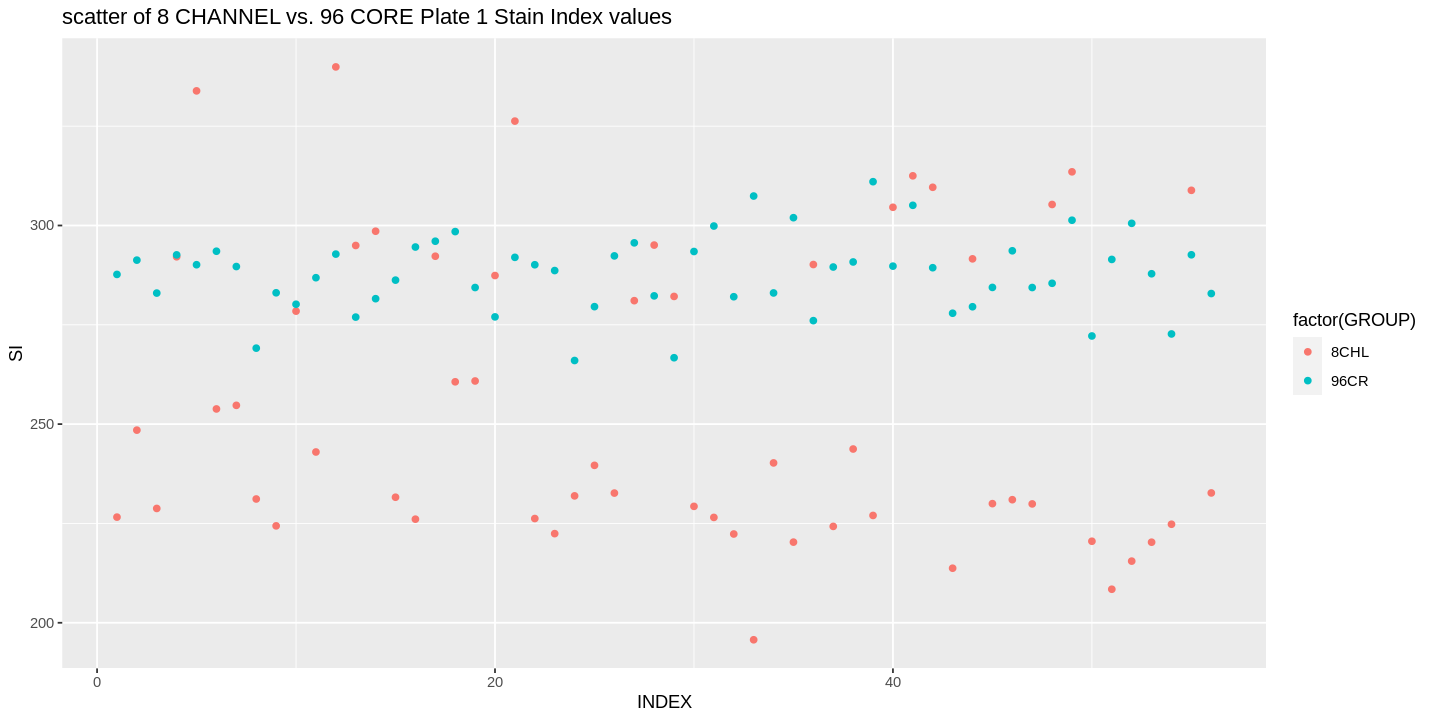

In [202]:
# first set
df <- dff %>% filter(PLATE == "Plate 1")
ggplot(df, aes(x = INDEX, y = SI)) + 
    geom_point(aes(colour = factor(GROUP))) + 
    ggtitle("scatter of 8 CHANNEL vs. 96 CORE Plate 1 Stain Index values")

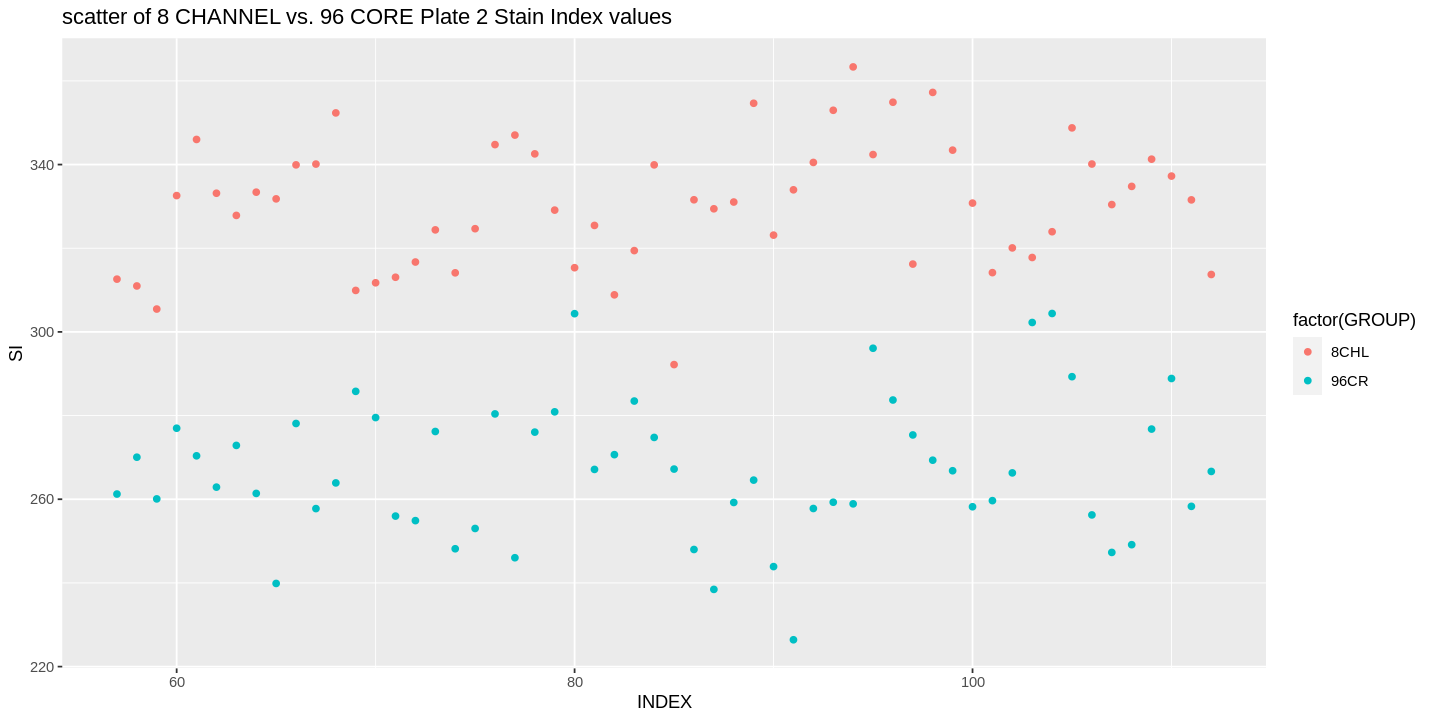

In [204]:
# second set
df <- dff %>% filter(PLATE == "Plate 2")
ggplot(df, aes(x = INDEX, y = SI)) + 
    geom_point(aes(colour = factor(GROUP))) + 
    ggtitle("scatter of 8 CHANNEL vs. 96 CORE Plate 2 Stain Index values")

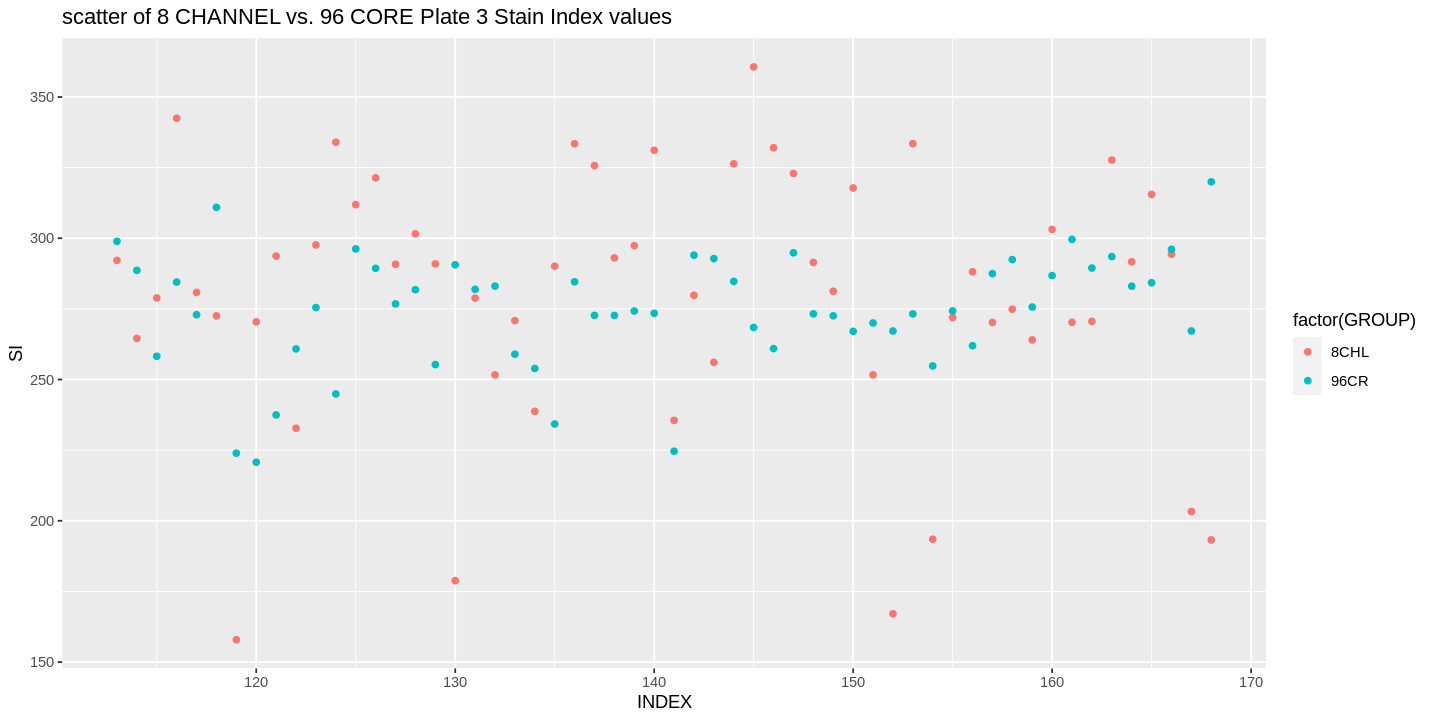

In [205]:
# third set
df <- dff %>% filter(PLATE == "Plate 3")
ggplot(df, aes(x = INDEX, y = SI)) + 
    geom_point(aes(colour = factor(GROUP))) + 
    ggtitle("scatter of 8 CHANNEL vs. 96 CORE Plate 3 Stain Index values")

# Conclusion

- Seems as though the experiment is not setup for statistically convincing data
- May be inherent to flow cytometry experiments
- Or could design a new experiment:
    - Run 1 plate at a time, 2x for 8 channel and 96 core head
    - After each plate finishes, immediately wash and start on flow cytometer (use 2x cytometers; this will help even out inherent variances that can be pooled)
    - Perhaps use a real cell counter and count cells of a plate to compare against the X20
    - Append to current dataset cell count with n=3 prior to washing